In [297]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Display all columns`
pd.set_option('display.max_columns', None)

# Set visualization style
sns.set_style('darkgrid')

In [3]:
# New
data = pd.read_excel(
    "Employee_users.xlsx",
    header=1,
    parse_dates = [2, 3]
)
data

User Group User           Plugged in at  \
0    Mitarbeiter*in Firmenfahrzeuge MIETHKE    G 2023-09-01 08:36:41.452   
1    Mitarbeiter*in Firmenfahrzeuge MIETHKE    F 2023-09-01 09:36:40.639   
2    Mitarbeiter*in Firmenfahrzeuge MIETHKE    F 2023-09-01 11:41:08.208   
3    Mitarbeiter*in Firmenfahrzeuge MIETHKE    G 2023-09-01 11:58:01.090   
4    Mitarbeiter*in Firmenfahrzeuge MIETHKE    C 2023-09-04 08:23:32.618   
..                                      ...  ...                     ...   
355  Mitarbeiter*in Firmenfahrzeuge MIETHKE    C 2024-01-30 13:22:05.439   
356  Mitarbeiter*in Firmenfahrzeuge MIETHKE    D 2024-01-31 09:44:08.440   
357  Mitarbeiter*in Firmenfahrzeuge MIETHKE    C 2024-01-31 13:13:53.423   
358  Mitarbeiter*in Firmenfahrzeuge MIETHKE    F 2024-01-31 14:52:41.343   
359  Mitarbeiter*in Firmenfahrzeuge MIETHKE    H 2024-01-31 16:11:56.037   

               Unplugged at Charging Duration Blocking Time  \
0   2023-09-01 10:24:40.874        1h 47m 27s    1h 47m 59s   
1   2023-09-01 11:23:58.970        1h 46m 52s    1h 47m 18s   
2   2023-09-01 14:33:57.371        1h 03m 29s    2h 52m 49s   
3   2023-09-01 15:37:25.712        3h 16m 14s    3h 39m 25s   
4   2023-09-04 16:32:27.521        5h 04m 48s    8h 08m 55s   
..                      ...               ...           ...   
355 2024-01-30 15:38:28.913        2h 15m 37s    2h 16m 23s   
356 2024-01-31 15:21:21.154        5h 35m 41s    5h 37m 13s   
357 2024-01-31 13:55:30.841        0h 40m 49s    0h 41m 37s   
358 2024-01-31 17:56:35.663        3h 03m 34s    3h 03m 54s   
359 2024-01-31 18:23:21.916        2h 04m 13s    2h 11m 26s   

                         Location Charging Station          Connector  \
0                         Ulanweg   KEBA_MIETHKE_1                  3   
1    Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2                  1   
2    Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2                  1   
3                         Ulanweg   KEBA_MIETHKE_1                  3   
4                         Ulanweg   KEBA_MIETHKE_1                  2   
..                            ...              ...                ...   
355  Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2                  1   
356  Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2                  1   
357  Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2                  2   
358                       Ulanweg     ABL_10332049  Ladepunkt 2 links   
359                       Ulanweg   KEBA_MIETHKE_1                  4   

          EVSE-ID  Kommentar  Price per kWh  Consumption(kWh)  Net Costs  \
0    DE*ONE*ET6BM        NaN              0             6.280          0   
1    DE*ONE*ENHW4        NaN              0             5.903          0   
2    DE*ONE*ENHW4        NaN              0             2.573          0   
3    DE*ONE*ET6BM        NaN              0             9.872          0   
4    DE*ONE*EKZC8        NaN              0            52.974          0   
..            ...        ...            ...               ...        ...   
355  DE*ONE*ENHW4        NaN              0            23.850          0   
356  DE*ONE*ENHW4        NaN              0            57.551          0   
357  DE*ONE*EJ5HL        NaN              0             7.092          0   
358  DE*ONE*EE94A        NaN              0            10.003          0   
359  DE*ONE*EC6M1        NaN              0            19.549          0   

     Tax Rate  Tax Costs  Gross Costs  Parking Fee Tariff  \
0          19          0            0                   0   
1          19          0            0                   0   
2          19          0            0                   0   
3          19          0            0                   0   
4          19          0            0                   0   
..        ...        ...          ...                 ...   
355        19          0            0                   0   
356        19          0            0                   0   
357        19          0

# DATA CLEANING

In [5]:
def rename_charge_station(df):
    if df['EVSE-ID'] == 'DE*ONE*E2859' or df['EVSE-ID'] == 'DE*ONE*EKZC8':
        charge_station = 'KEBA_MIETHKE_1_A'
    elif df['EVSE-ID'] =='DE*ONE*ET6BM' or df['EVSE-ID'] == 'DE*ONE*EC6M1':
        charge_station  = 'KEBA_MIETHKE_1_B'
    elif df['EVSE-ID'] == 'DE*ONE*E7RVQ' or df['EVSE-ID'] == 'DE*ONE*E3KHJ':
        charge_station = 'ABL_10332049_A'
    elif df['EVSE-ID'] == 'DE*ONE*E68JX' or df['EVSE-ID'] == 'DE*ONE*EE94A':
        charge_station = 'ABL_10332049_B'
    else:
        charge_station = 'KEBA_MIETHKE_2'
    return charge_station

In [6]:
def wrangle(dataset):
    data = pd.read_excel(
        dataset,
        header=1,
        parse_dates = [2, 3]
)

    data.drop(columns=['Kommentar', 'Price per kWh','Net Costs', 'Tax Rate', 'Tax Costs', 'Gross Costs',
                   'Parking Fee Tariff', 'Net Parking Fee Costs', 'Parking Fee Tax Rate',
                   'Parking Fee Tax Costs', 'Gross Parking Fee Costs', 'Total Costs', 'Connector'], inplace=True)
    
#     connector_name = {'Ladepunkt 1 links':'Point1','1':'Point1', 'Ladepunkt 1':'Point1','Ladepunkt 2':'Point2','2':'Point2','Ladepunkt 2':'Point2',
#                   'Ladepunkt 3':'Point3', '3':'Point3','Ladepunkt 3 rechts':'Point3','Ladepunkt 4 rechts':'Point4','Ladepunkt 4':'Point4','4':'Point4', 
#                  'Ladepunkt 2 links': 'Point2'}
    
#    data['Connector'] = data['Connector'].replace(connector_name)
    
    # Rename charge station based on evse-id
    data['Charging Station'] = data.apply(rename_charge_station, axis=1)
    
    # Extract month when vehicles were plugged and unplugged
    data['Plugged_in_month'] = data['Plugged in at'].dt.month_name()
    data['Unplugged_month'] = data['Unplugged at'].dt.month_name()

    # Extract dayname when vehicles were plugged and unplugged
    data['Plugged_in_dayname'] = data['Plugged in at'].dt.day_name()
    data['Unplugged_dayname'] = data['Unplugged at'].dt.day_name()
    
    # Extract time when vehicles were plugged and unplugged
    data['Plugged_in_time'] = data['Plugged in at'].dt.time
    data['Unplugged_time'] = data['Unplugged at'].dt.time
    
    # Extract the hour of plug-in and plug-out
    data['Plugged_in_time_hour'] = data['Plugged_in_time'].astype(str).str.split(':').str[0]
    data['Unplugged_time_hour'] = data['Unplugged_time'].astype(str).str.split(':').str[0]
    
#     # Use lambda functions to extract date and time components
#     data['Year_un'] = data['Unplugged at'].dt.year
#     data['Month_un'] = data['Unplugged at'].dt.strftime('%b')
#     data['Day_of_week_un'] = data['Unplugged at'].dt.day_name()

#     # Extract hour, minute, and second components
#     data['Hour_un'] = data['Unplugged at'].dt.hour
#     data['Minute_un'] = data['Unplugged at'].dt.minute
#     data['Second_un'] = data['Unplugged at'].dt.second

    # Convert dayname and month to categorical variables
    data['Plugged_in_month'] = pd.Categorical(
        data['Plugged_in_month'],
        categories=['September', 'October', 'November', 'December', 'January']
    )
    data['Unplugged_month'] = pd.Categorical(
        data['Unplugged_month'],
        categories=['September', 'October', 'November', 'December', 'January']
    )
    data['Plugged_in_dayname'] = pd.Categorical(
        data['Plugged_in_dayname'],
        categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    )
    data['Unplugged_dayname'] = pd.Categorical(
        data['Unplugged_dayname'],
        categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    )

    # Extracting 'Charging Duration' components
    data[['C_Hours', 'C_Minutes', 'C_Seconds']] = data['Charging Duration'].str.extract(r'(\d+)h (\d+)m (\d+)s').astype(int)
    data[['B_Hours', 'B_Minutes', 'B_Seconds']] = data['Blocking Time'].str.extract(r'(\d+)h (\d+)m (\d+)s').astype(int)

    # Convert 'Charging Duration' to total minutes as float
    data['Charging Duration'] = data['C_Hours'] + (data['C_Minutes'] / 60) + (data['C_Seconds'] / 3600)
    data['Blocking Time'] = data['B_Hours'] + (data['B_Minutes'] / 60) + (data['B_Seconds'] / 3600)
    
    # Calculate hogging time
    data['Hogging time'] = data['Blocking Time']- data['Charging Duration']

    # Drop intermediate columns
    data.drop(['C_Hours', 'B_Hours', 'C_Minutes', 'B_Minutes', 'C_Seconds', 'B_Seconds'], axis=1, inplace=True)

    
    # Convert 'Datetime' column to DateTime format
    #data['Unplugged at'] = pd.to_datetime(data['Unplugged at'])

    # Use lambda functions to extract year and month
    #data['Year_un'] = data['Unplugged at'].apply(lambda x: x.year)
    #data['Month_un'] = data['Unplugged at'].apply(lambda x: x.strftime('%b'))
    #data[['Hours', 'Minutes', 'Seconds']] = data['Charging Duration'].str.extract(r'(\d+)h (\d+)m (\d+)s').astype(int)
    # Convert 'Charging Duration' to total minutes as float
    #data['Charging Duration (Minutes)'] = data['Hours'] * 60 + data['Minutes'] + data['Seconds'] / 60.0
    
    # Drop intermediate columns
    #data.drop(['Hours', 'Minutes', 'Seconds'], axis=1, inplace=True)
    # Extract hour of the day and day of the week
    #data['Hour_pl'] = data['Plugged in at'].dt.hour
    #data['Day_of_week_pl'] = data['Plugged in at'].dt.day_name()
    #Perform one-hot encoding for the 'Month_un' column
#             features = df[['Year_un', 'Month_un', 'Charging Duration (Minutes)', 'Consumption(KWh)']]
#             features_encoded = pd.get_dummies(features, columns=['Month_un'], drop_first=True)
    # Assuming 'df' is your DataFrame
    

    return data
    

In [7]:
# New
employee_data = wrangle("Employee_users.xlsx")
employee_data.head()

User Group User           Plugged in at  \
0  Mitarbeiter*in Firmenfahrzeuge MIETHKE    G 2023-09-01 08:36:41.452   
1  Mitarbeiter*in Firmenfahrzeuge MIETHKE    F 2023-09-01 09:36:40.639   
2  Mitarbeiter*in Firmenfahrzeuge MIETHKE    F 2023-09-01 11:41:08.208   
3  Mitarbeiter*in Firmenfahrzeuge MIETHKE    G 2023-09-01 11:58:01.090   
4  Mitarbeiter*in Firmenfahrzeuge MIETHKE    C 2023-09-04 08:23:32.618   

             Unplugged at  Charging Duration  Blocking Time  \
0 2023-09-01 10:24:40.874           1.790833       1.799722   
1 2023-09-01 11:23:58.970           1.781111       1.788333   
2 2023-09-01 14:33:57.371           1.058056       2.880278   
3 2023-09-01 15:37:25.712           3.270556       3.656944   
4 2023-09-04 16:32:27.521           5.080000       8.148611   

                       Location  Charging Station       EVSE-ID  \
0                       Ulanweg  KEBA_MIETHKE_1_B  DE*ONE*ET6BM   
1  Fritz-von-der-Lancken-Straße    KEBA_MIETHKE_2  DE*ONE*ENHW4   
2  Fritz-von-der-Lancken-Straße    KEBA_MIETHKE_2  DE*ONE*ENHW4   
3                       Ulanweg  KEBA_MIETHKE_1_B  DE*ONE*ET6BM   
4                       Ulanweg  KEBA_MIETHKE_1_A  DE*ONE*EKZC8   

   Consumption(kWh) Plugged_in_month Unplugged_month Plugged_in_dayname  \
0             6.280        September       September             Friday   
1             5.903        September       September             Friday   
2             2.573        September       September             Friday   
3             9.872        September       September             Friday   
4            52.974        September       September             Monday   

  Unplugged_dayname  Plugged_in_time   Unplugged_time Plugged_in_time_hour  \
0            Friday  08:36:41.452000  10:24:40.874000                   08   
1            Friday  09:36:40.639000  11:23:58.970000                   09   
2            Friday  11:41:08.208000  14:33:57.371000                   11   
3            Friday  11:58:01.090000  15:37:25.712000                   11   
4            Monday  08:23:32.618000  16:32:27.521000                   08   

  Unplugged_time_hour  Hogging time  
0                  10      0.008889  
1                  11      0.007222  
2                  14      1.822222  
3                  15      0.386389  
4                  16      3.068611

In [61]:
# Old
df = wrangle("Employee_users.xlsx")
df

User Group User           Plugged in at  \
0    Mitarbeiter*in Firmenfahrzeuge MIETHKE    G 2023-09-01 08:36:41.452   
1    Mitarbeiter*in Firmenfahrzeuge MIETHKE    F 2023-09-01 09:36:40.639   
2    Mitarbeiter*in Firmenfahrzeuge MIETHKE    F 2023-09-01 11:41:08.208   
3    Mitarbeiter*in Firmenfahrzeuge MIETHKE    G 2023-09-01 11:58:01.090   
4    Mitarbeiter*in Firmenfahrzeuge MIETHKE    C 2023-09-04 08:23:32.618   
..                                      ...  ...                     ...   
355  Mitarbeiter*in Firmenfahrzeuge MIETHKE    C 2024-01-30 13:22:05.439   
356  Mitarbeiter*in Firmenfahrzeuge MIETHKE    D 2024-01-31 09:44:08.440   
357  Mitarbeiter*in Firmenfahrzeuge MIETHKE    C 2024-01-31 13:13:53.423   
358  Mitarbeiter*in Firmenfahrzeuge MIETHKE    F 2024-01-31 14:52:41.343   
359  Mitarbeiter*in Firmenfahrzeuge MIETHKE    H 2024-01-31 16:11:56.037   

               Unplugged at Charging Duration Blocking time  \
0   2023-09-01 10:24:40.874        1h 47m 27s    1h 47m 59s   
1   2023-09-01 11:23:58.970        1h 46m 52s    1h 47m 18s   
2   2023-09-01 14:33:57.371        1h 03m 29s    2h 52m 49s   
3   2023-09-01 15:37:25.712        3h 16m 14s    3h 39m 25s   
4   2023-09-04 16:32:27.521        5h 04m 48s    8h 08m 55s   
..                      ...               ...           ...   
355 2024-01-30 15:38:28.913        2h 15m 37s    2h 16m 23s   
356 2024-01-31 15:21:21.154        5h 35m 41s    5h 37m 13s   
357 2024-01-31 13:55:30.841        0h 40m 49s    0h 41m 37s   
358 2024-01-31 17:56:35.663        3h 03m 34s    3h 03m 54s   
359 2024-01-31 18:23:21.916        2h 04m 13s    2h 11m 26s   

                         Location Charging Station Connector       EVSE-ID  \
0                         Ulanweg   KEBA_MIETHKE_1    Point3  DE*ONE*ET6BM   
1    Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2    Point1  DE*ONE*ENHW4   
2    Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2    Point1  DE*ONE*ENHW4   
3                         Ulanweg   KEBA_MIETHKE_1    Point3  DE*ONE*ET6BM   
4                         Ulanweg   KEBA_MIETHKE_1    Point2  DE*ONE*EKZC8   
..                            ...              ...       ...           ...   
355  Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2    Point1  DE*ONE*ENHW4   
356  Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2    Point1  DE*ONE*ENHW4   
357  Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2    Point2  DE*ONE*EJ5HL   
358                       Ulanweg     ABL_10332049    Point2  DE*ONE*EE94A   
359                       Ulanweg   KEBA_MIETHKE_1    Point4  DE*ONE*EC6M1   

     Consumption(KWh)  Year_un Month_un Day_of_week_un  Hour_un  Minute_un  \
0               6.280     2023      Sep         Friday       10         24   
1               5.903     2023      Sep         Friday       11         23   
2               2.573     2023      Sep         Friday       14         33   
3               9.872     2023      Sep         Friday       15         37   
4              52.974     2023      Sep         Monday       16         32   
..                ...      ...      ...            ...      ...        ...   
355            23.850     2024      Jan        Tuesday       15         38   
356            57.551     2024      Jan      Wednesday       15         21   
357             7.092     2024      Jan      Wednesday       13         55   
358            10.003     2024      Jan      Wednesday       17         56   
359            19.549     2024      Jan      Wednesday       18         23   

     Second_un  Charging Duration (Minutes)  
0           40                   107.450000  
1           58                   106.866667  
2           57                    63.483333  
3           25                   196.233333  
4           27                   304.800000  
..         ...                          ...  
355         28                   135.616667  
356         21                   335.683333  
357         30                    40.816667  
358         35               

In [8]:
pd.crosstab(employee_data['Location'],employee_data['EVSE-ID'])

EVSE-ID                       DE*ONE*E2859  DE*ONE*E3KHJ  DE*ONE*E68JX  \
Location                                                                 
Fritz-von-der-Lancken-Straße             0             0             0   
Ulanweg                                 40            35            50   

EVSE-ID                       DE*ONE*E7RVQ  DE*ONE*EC6M1  DE*ONE*EE94A  \
Location                                                                 
Fritz-von-der-Lancken-Straße             0             0             0   
Ulanweg                                 35            28            51   

EVSE-ID                       DE*ONE*EJ5HL  DE*ONE*EKZC8  DE*ONE*ENHW4  \
Location                                                                 
Fritz-von-der-Lancken-Straße            27             0            47   
Ulanweg                                  0            33             0   

EVSE-ID                       DE*ONE*ET6BM  
Location                                    
Fritz-von-der-Lancken-Straße             0  
Ulanweg                                 14

In [9]:
pd.crosstab(employee_data['Location'],employee_data['User'])

User                          A   B   C   D   E   F   G   H   I
Location                                                       
Fritz-von-der-Lancken-Straße  0   6  11  29   0  24   0   0   4
Ulanweg                       7  35  35  18  15   5  64  75  32

In [13]:
employee_data.pivot_table(index='Charging Station', columns=['Plugged_in_month'], values=['Charging Duration'], aggfunc='sum')

Charging Duration                                            
Plugged_in_month         September    October   November   December    January
Charging Station                                                              
ABL_10332049_A           29.566111  13.394444  51.309444  25.916667  61.400278
ABL_10332049_B           62.385833  55.945556  49.448611  56.402500  83.506389
KEBA_MIETHKE_1_A         16.776389  30.586667  34.879444  44.594167  44.238611
KEBA_MIETHKE_1_B         35.382500  12.647778  15.196389  27.791389  20.216389
KEBA_MIETHKE_2          145.798333  14.157222  37.728056  41.880556  86.445833

In [17]:
employee_data.pivot_table(index='Plugged_in_dayname', values=['Charging Duration'], aggfunc='sum')

Charging Duration
Plugged_in_dayname                   
Sunday                       0.000000
Monday                     202.219167
Tuesday                    184.004444
Wednesday                  186.657778
Thursday                   287.953611
Friday                     233.588889
Saturday                     3.171667

In [18]:
employee_data.pivot_table(index='Plugged_in_month', values=['Charging Duration'], aggfunc='sum')

Charging Duration
Plugged_in_month                   
September                289.909167
October                  126.731667
November                 188.561944
December                 196.585278
January                  295.807500

In [21]:
pivot = employee_data.pivot_table(index='Unplugged_time_hour', values=['Charging Duration'], aggfunc='sum').sort_values('Charging Duration')
pivot

Charging Duration
Unplugged_time_hour                   
08                            1.851111
22                            4.347778
21                            8.454722
20                           14.160000
19                           15.137222
09                           25.614167
10                           38.338889
11                           53.311111
12                           54.484444
13                           75.790000
15                          100.799722
18                          123.506667
14                          181.235833
17                          190.737222
16                          209.826667

## Peak charging hour:

In [49]:
peak_charging_hour = employee_data.pivot_table(index='Unplugged_time_hour', values='Charging Duration', aggfunc='mean')
print(f"Peak charging hour: {peak_charging_hour.idxmax()[0]}")

Peak charging hour: 14


## Off peak charging hour

In [50]:
off_peak_charging_hour = employee_data.pivot_table(index='Unplugged_time_hour', values='Charging Duration', aggfunc='mean')
print(f"Off peak charging hour: {off_peak_charging_hour.idxmin()[0]}")

Off peak charging hour: 08


## Peak charging day

In [52]:
peak_charging_day = employee_data.pivot_table(index='Unplugged_dayname', values='Charging Duration', aggfunc='mean')
print(f"Peak charging day: {peak_charging_day.idxmax()[0]}")

Peak charging day: Tuesday


## Least charging day

In [54]:
least_charging_day = employee_data.pivot_table(index='Unplugged_dayname', values='Charging Duration', aggfunc='mean')
print(f"Least charging day: {peak_charging_day.idxmin()[0]}")

Least charging day: Saturday


## Peak charging month

In [55]:
peak_charging_month = employee_data.pivot_table(index='Unplugged_month', values='Charging Duration', aggfunc='mean')
print(f"Peak charging month: {peak_charging_month.idxmax()[0]}")

Peak charging month: September


## Least charging month

In [68]:
least_charging_month = employee_data.pivot_table(index='Unplugged_month', values='Charging Duration', aggfunc='mean')
print(f"Least charging month: {least_charging_month.idxmin()[0]}")

Least charging month: November


## Peak consumption hour

In [57]:
peak_consumption_hour = employee_data.pivot_table(index='Unplugged_time_hour', values='Consumption(kWh)', aggfunc='mean')
print(f"Peak consumption hour: {peak_consumption_hour.idxmax()[0]}")

Peak consumption hour: 19


## Off peak consumption hour

In [58]:
off_peak_consumption_hour = employee_data.pivot_table(index='Unplugged_time_hour', values='Consumption(kWh)', aggfunc='mean')
print(f"Off peak consumption hour: {off_peak_consumption_hour.idxmin()[0]}")

Off peak consumption hour: 08


## Peak consumption day

In [59]:
peak_consumption_day = employee_data.pivot_table(index='Unplugged_dayname', values='Consumption(kWh)', aggfunc='mean')
print(f"Peak consumption day: {peak_consumption_day.idxmax()[0]}")

Peak consumption day: Monday


## Least consumption day

In [65]:
least_consumption_day = employee_data.pivot_table(index='Unplugged_dayname', values='Consumption(kWh)', aggfunc='mean')
print(f"Least consumption day: {least_consumption_day.idxmin()[0]}")

Least consumption day: Saturday


## Peak consumption month

In [64]:
peak_consumption_month = employee_data.pivot_table(index='Unplugged_month', values='Consumption(kWh)', aggfunc='mean')
print(f"Peak consumption month: {peak_consumption_month.idxmax()[0]}")

Peak consumption month: October


## Least consumption month

In [63]:
least_consumption_month = employee_data.pivot_table(index='Unplugged_month', values='Consumption(kWh)', aggfunc='mean')
print(f"Least consumption month: {least_consumption_month.idxmin()[0]}")

Least consumption month: September


## Hourly variation

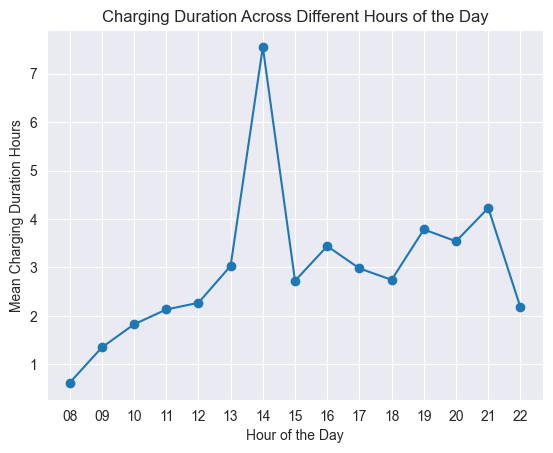

In [75]:
plt.plot(peak_charging_hour.index, peak_charging_hour['Charging Duration'], marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Charging Duration Hours')
plt.title('Charging Duration Across Different Hours of the Day')
#plt.xticks(range(24))  # Assuming 24 hours in a day
#plt.grid(True)
plt.show()

# EXPLORATORY DATA ANALYSIS

In [76]:
# Extract daytime data
employee_data_daytime = employee_data.set_index('Plugged in at').between_time('6:00', '18:00').reset_index()
# Extract nighttime data
employee_data_nighttime = employee_data.set_index('Plugged in at').between_time('18:01', '5:59').reset_index()

In [77]:
# Split into each month
employee_data_september = employee_data[employee_data['Plugged_in_month'] == 'September']
employee_data_october = employee_data[employee_data['Plugged_in_month'] == 'October']
employee_data_november = employee_data[employee_data['Plugged_in_month'] == 'November']
employee_data_december = employee_data[employee_data['Plugged_in_month'] == 'December']
employee_data_january = employee_data[employee_data['Plugged_in_month'] == 'January']

### Distribution of Connection time

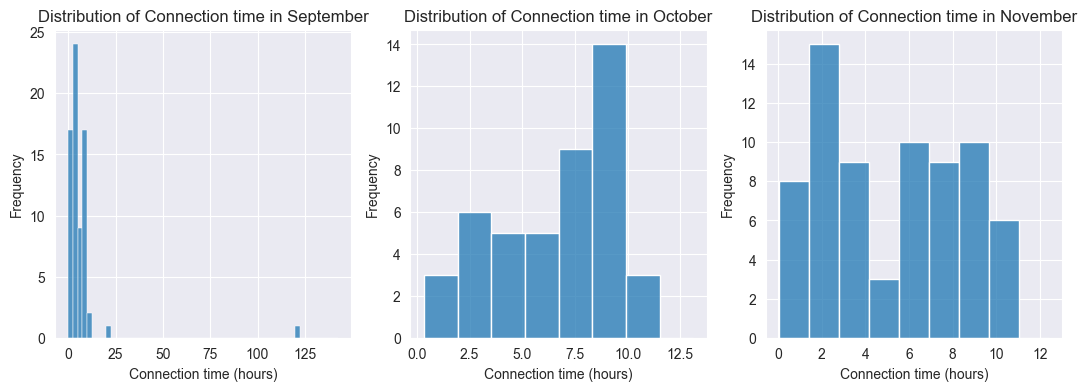

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.histplot(
    data=employee_data_september,
    x='Blocking Time',
    ax=ax[0],
    binrange=(employee_data_september['Blocking Time'].min(), employee_data_september['Blocking Time'].max() + 20)
)
ax[0].set_title('Distribution of Connection time in September')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Connection time (hours)')

# October
sns.histplot(
    data=employee_data_october,
    x='Blocking Time',
    ax=ax[1],
    binrange=(employee_data_october['Blocking Time'].min(), employee_data_october['Blocking Time'].max() + 2)
)
ax[1].set_title('Distribution of Connection time in October')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Connection time (hours)')

# November
sns.histplot(
    data=employee_data_november,
    x='Blocking Time',
    ax=ax[2],
    binrange=(employee_data_november['Blocking Time'].min(), employee_data_november['Blocking Time'].max() + 2)
)
ax[2].set_title('Distribution of Connection time in November')
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Connection time (hours)')

# Save figure
#plt.savefig('../Images/Employees/Redo/connection-time-distribution-1', bbox_inches='tight')
plt.show()

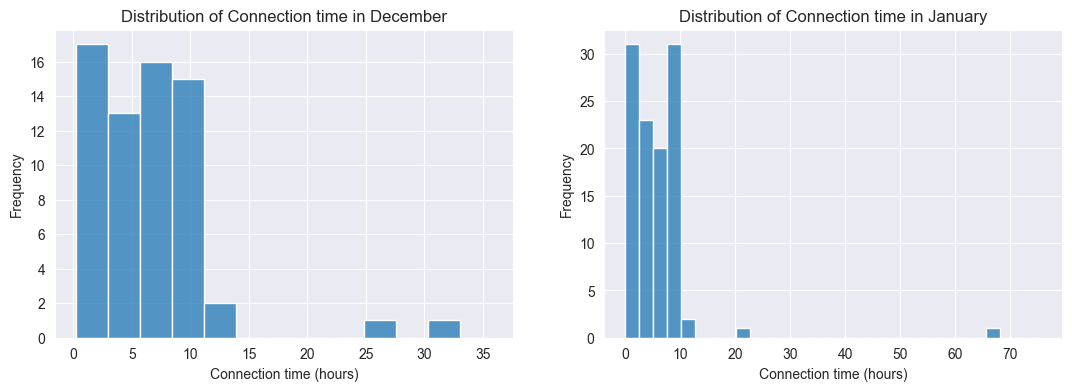

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.histplot(
    data=employee_data_december,
    x='Blocking Time',
    ax=ax[0],
    binrange=(employee_data_december['Blocking Time'].min(), employee_data_december['Blocking Time'].max() + 5)
)
ax[0].set_title('Distribution of Connection time in December')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Connection time (hours)')

# January
sns.histplot(
    data=employee_data_january,
    x='Blocking Time',
    ax=ax[1],
    binrange=(employee_data_january['Blocking Time'].min(), employee_data_january['Blocking Time'].max() + 10)
)
ax[1].set_title('Distribution of Connection time in January')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Connection time (hours)')

# Save figure
#plt.savefig('../Images/Employees/Redo/connection-time-distribution-2', bbox_inches='tight')
plt.show()

### Correct outliers

These are values whose connection time do not seem to match the consumption

#### September

In [314]:
employee_data_september[(employee_data_september['Consumption(kWh)'] >= 4) & (employee_data_september['Consumption(kWh)'] <= 5)]

User Group User           Plugged in at  \
30  Mitarbeiter*in Firmenfahrzeuge MIETHKE    F 2023-09-14 11:58:48.197   
44  Mitarbeiter*in Firmenfahrzeuge MIETHKE    G 2023-09-20 19:02:36.093   

              Unplugged at  Charging Duration  Blocking Time  \
30 2023-09-19 14:17:37.258         122.309167     122.313611   
44 2023-09-20 20:29:41.200           1.443611       1.451389   

                        Location Charging Station       EVSE-ID  \
30  Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2  DE*ONE*ENHW4   
44                       Ulanweg   ABL_10332049_A  DE*ONE*E7RVQ   

    Consumption(kWh) Plugged_in_month Unplugged_month Plugged_in_dayname  \
30             4.733        September       September           Thursday   
44             4.469        September       September          Wednesday   

   Unplugged_dayname  Plugged_in_time   Unplugged_time Plugged_in_time_hour  \
30           Tuesday  11:58:48.197000  14:17:37.258000                   11   
44         Wednesday  19:02:36.093000  20:29:41.200000                   19   

   Unplugged_time_hour  Hogging time  
30                  14      0.004444  
44                  20      0.007778

In [315]:
# Replace blocking time based on similar consumption with other sessions
employee_data_september.loc[30, 'Blocking Time'] = (4.733 * 1.451389) / 4.469

# Replace charge time based on similar consumption with other sessions
employee_data_september.loc[30, 'Charging Duration'] = (4.733 * 1.443611) / 4.469

#### December

In [316]:
employee_data_december[employee_data_december['Blocking Time'] > 20]

User Group User           Plugged in at  \
227  Mitarbeiter*in Firmenfahrzeuge MIETHKE    C 2023-12-15 08:30:47.486   
230  Mitarbeiter*in Firmenfahrzeuge MIETHKE    I 2023-12-15 14:43:56.068   

               Unplugged at  Charging Duration  Blocking Time  \
227 2023-12-16 15:18:02.379           2.734722      30.787500   
230 2023-12-16 15:59:24.292           3.686667      25.257778   

                         Location Charging Station       EVSE-ID  \
227                       Ulanweg   ABL_10332049_A  DE*ONE*E7RVQ   
230  Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2  DE*ONE*EJ5HL   

     Consumption(kWh) Plugged_in_month Unplugged_month Plugged_in_dayname  \
227            28.628         December        December             Friday   
230            24.257         December        December             Friday   

    Unplugged_dayname  Plugged_in_time   Unplugged_time Plugged_in_time_hour  \
227          Saturday  08:30:47.486000  15:18:02.379000                   08   
230          Saturday  14:43:56.068000  15:59:24.292000                   14   

    Unplugged_time_hour  Hogging time  
227                  15     28.052778  
230                  15     21.571111

#### January

In [317]:
employee_data_january[(employee_data_january['Consumption(kWh)'] >= 5) & (employee_data_january['Consumption(kWh)'] <= 6)]

User Group User           Plugged in at  \
296  Mitarbeiter*in Firmenfahrzeuge MIETHKE    G 2024-01-12 15:42:48.519   
325  Mitarbeiter*in Firmenfahrzeuge MIETHKE    F 2024-01-19 09:42:13.672   
326  Mitarbeiter*in Firmenfahrzeuge MIETHKE    F 2024-01-19 11:39:37.081   

               Unplugged at  Charging Duration  Blocking Time  \
296 2024-01-15 09:23:13.742           2.237222      65.673611   
325 2024-01-19 11:19:18.132           1.613333       1.617778   
326 2024-01-19 15:36:49.086           1.853611       3.953333   

                         Location  Charging Station       EVSE-ID  \
296                       Ulanweg  KEBA_MIETHKE_1_A  DE*ONE*EKZC8   
325  Fritz-von-der-Lancken-Straße    KEBA_MIETHKE_2  DE*ONE*EJ5HL   
326  Fritz-von-der-Lancken-Straße    KEBA_MIETHKE_2  DE*ONE*EJ5HL   

     Consumption(kWh) Plugged_in_month Unplugged_month Plugged_in_dayname  \
296             5.349          January         January             Friday   
325             5.291          January         January             Friday   
326             5.108          January         January             Friday   

    Unplugged_dayname  Plugged_in_time   Unplugged_time Plugged_in_time_hour  \
296            Monday  15:42:48.519000  09:23:13.742000                   15   
325            Friday  09:42:13.672000  11:19:18.132000                   09   
326            Friday  11:39:37.081000  15:36:49.086000                   11   

    Unplugged_time_hour  Hogging time  
296                  09     63.436389  
325                  11      0.004444  
326                  15      2.099722

In [318]:
# Replace the connection time with the mean connection time of other sessions with similar consumption
employee_data_january.loc[296, 'Blocking Time'] = (1.617778 + 3.953333) / 2

Redo the plots without outliers

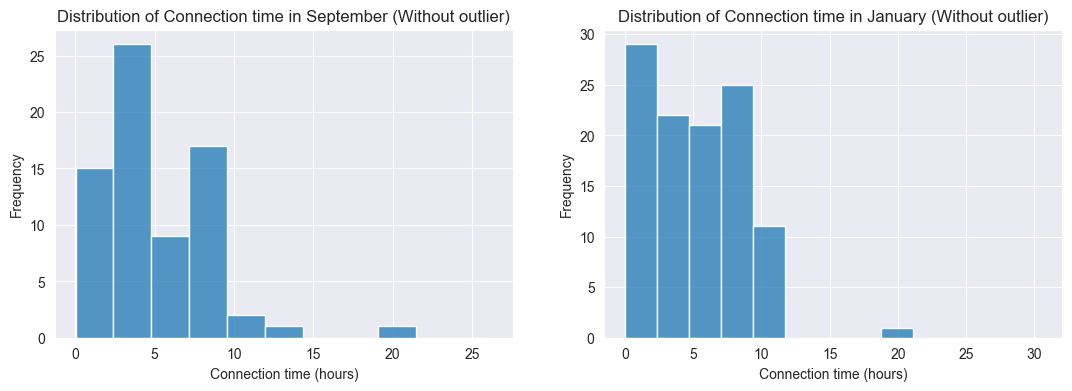

In [319]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.histplot(
    data=employee_data_september,
    x='Blocking Time',
    ax=ax[0],
    binrange=(employee_data_september['Blocking Time'].min(), employee_data_september['Blocking Time'].max() + 5)
)
ax[0].set_title('Distribution of Connection time in September (Without outlier)')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Connection time (hours)')

# January
sns.histplot(
    data=employee_data_january,
    x='Blocking Time',
    ax=ax[1],
    binrange=(employee_data_january['Blocking Time'].min(), employee_data_january['Blocking Time'].max() + 10)
)
ax[1].set_title('Distribution of Connection time in January (Without outlier)')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Connection time (hours)')

# Save figure
#plt.savefig('../Images/Employees/Redo/connection-time-distribution-without-outlier', bbox_inches='tight')
plt.show()

### Connection time (monthly)

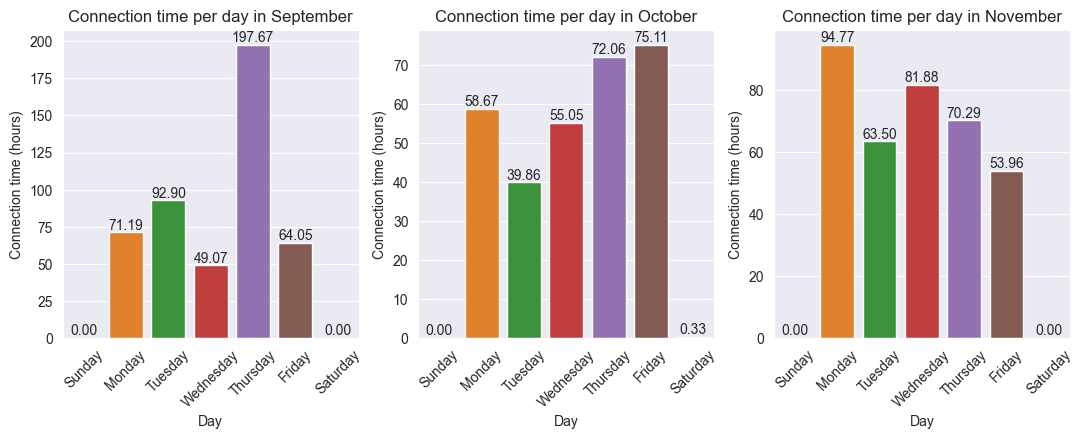

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.barplot(
    data=employee_data_september.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('Connection time per day in September')
ax[0].set_ylabel('Connection time (hours)')
ax[0].set_xlabel('Day')
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# October
sns.barplot(
    data=employee_data_october.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('Connection time per day in October')
ax[1].set_ylabel('Connection time (hours)')
ax[1].set_xlabel('Day')
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# November
sns.barplot(
    data=employee_data_november.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[2]
)
ax[2].tick_params(axis='x', rotation=45)
ax[2].set_title('Connection time per day in November')
ax[2].set_ylabel('Connection time (hours)')
ax[2].set_xlabel('Day')
ax[2].bar_label(ax[2].containers[0], fontsize=10, fmt='%.2f')

# Save figure
#plt.savefig('../Images/Employees/Redo/connection-time-per-day-1', bbox_inches='tight')
plt.show()

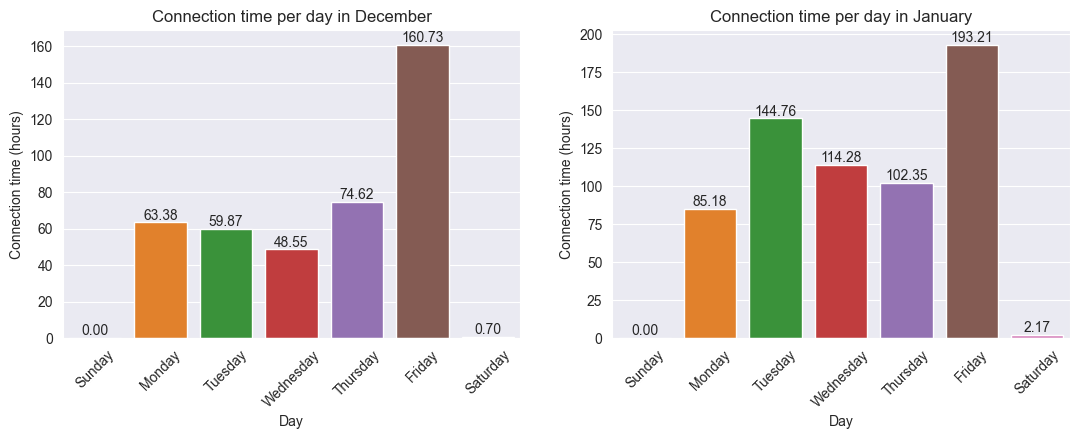

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.barplot(
    data=employee_data_december.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Connection time per day in December')
ax[0].set_ylabel('Connection time (hours)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# January
sns.barplot(
    data=employee_data_january.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Connection time per day in January')
ax[1].set_ylabel('Connection time (hours)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
#plt.savefig('../Images/Employees/Redo/connection-time-per-day-2', bbox_inches='tight')
plt.show()

#### Without outliers

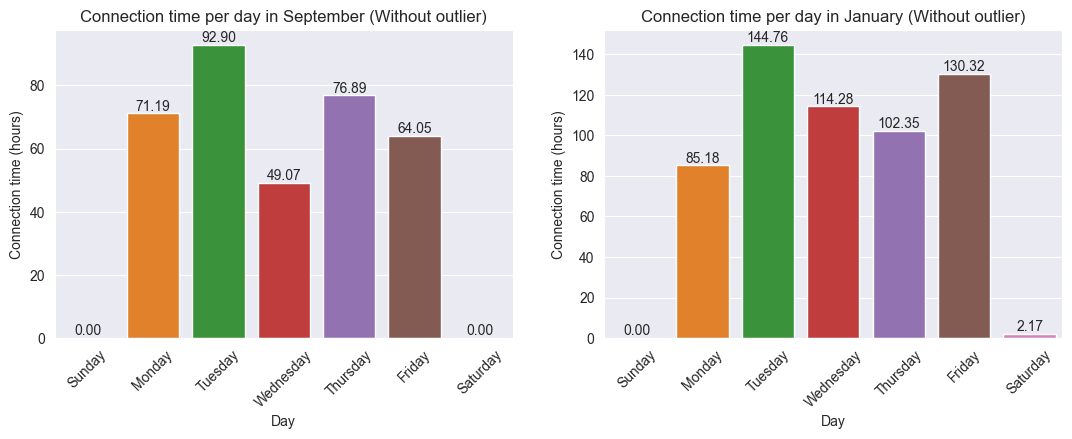

In [320]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.barplot(
    data=employee_data_september.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Connection time per day in September (Without outlier)')
ax[0].set_ylabel('Connection time (hours)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# January
sns.barplot(
    data=employee_data_january.sort_values('Plugged_in_dayname'),
    y='Blocking Time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Connection time per day in January (Without outlier)')
ax[1].set_ylabel('Connection time (hours)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
#plt.savefig('../Images/Employees/Redo/connection-time-per-day-without-outlier', bbox_inches='tight')
plt.show()

### Distribution of Charge time

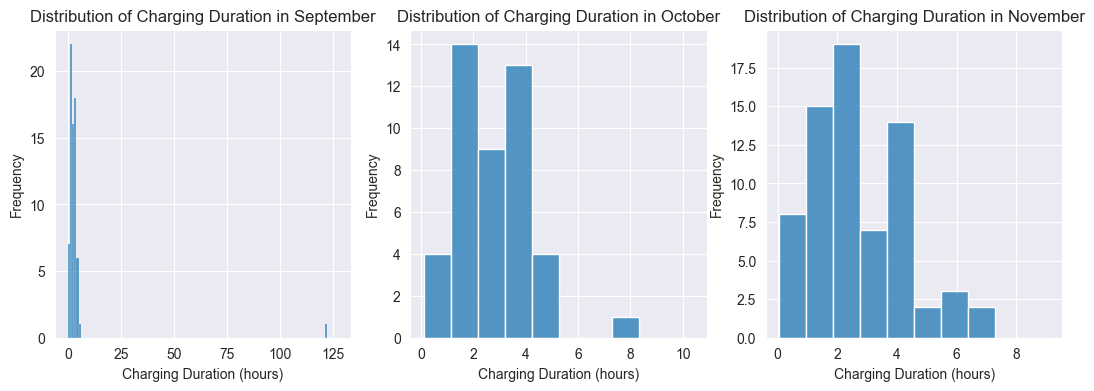

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.histplot(
    data=employee_data_september,
    x='Charging Duration',
    ax=ax[0],
    binrange=(employee_data_september['Charging Duration'].min(), employee_data_september['Charging Duration'].max() + 5)
)
ax[0].set_title('Distribution of Charging Duration in September')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Charging Duration (hours)')

# October
sns.histplot(
    data=employee_data_october,
    x='Charging Duration',
    ax=ax[1],
    binrange=(employee_data_october['Charging Duration'].min(), employee_data_october['Charging Duration'].max() + 3)
)
ax[1].set_title('Distribution of Charging Duration in October')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Charging Duration (hours)')

# November
sns.histplot(
    data=employee_data_november,
    x='Charging Duration',
    ax=ax[2],
    binrange=(employee_data_november['Charging Duration'].min(), employee_data_november['Charging Duration'].max() + 2)
)
ax[2].set_title('Distribution of Charging Duration in November')
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Charging Duration (hours)')

# Save figure
#plt.savefig('../Images/Employees/Redo/charge-time-distribution-1', bbox_inches='tight')
plt.show()

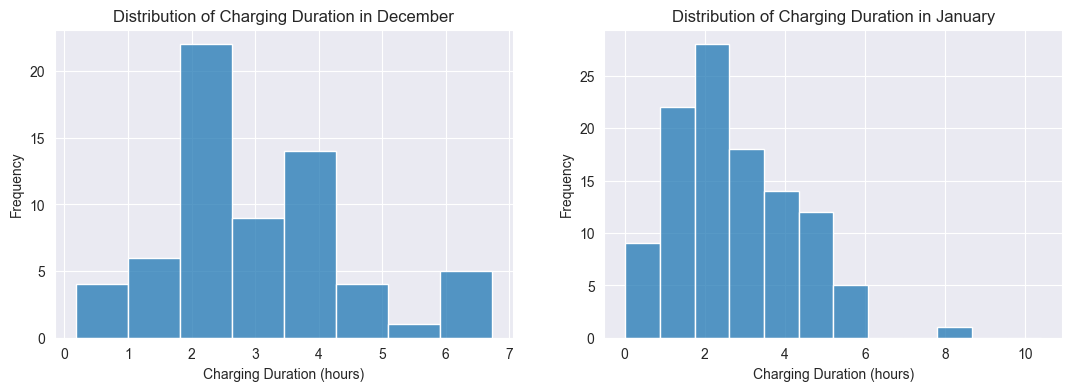

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.histplot(
    data=employee_data_december,
    x='Charging Duration',
    ax=ax[0]
)
ax[0].set_title('Distribution of Charging Duration in December')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Charging Duration (hours)')

# January
sns.histplot(
    data=employee_data_january,
    x='Charging Duration',
    ax=ax[1],
    binrange=(employee_data_january['Charging Duration'].min(), employee_data_january['Charging Duration'].max() + 2)
)
ax[1].set_title('Distribution of Charging Duration in January')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Charging Duration (hours)')

# Save figure
#plt.savefig('../Images/Employees/Redo/charge-time-distribution-2', bbox_inches='tight')
plt.show()

### Correct outliers

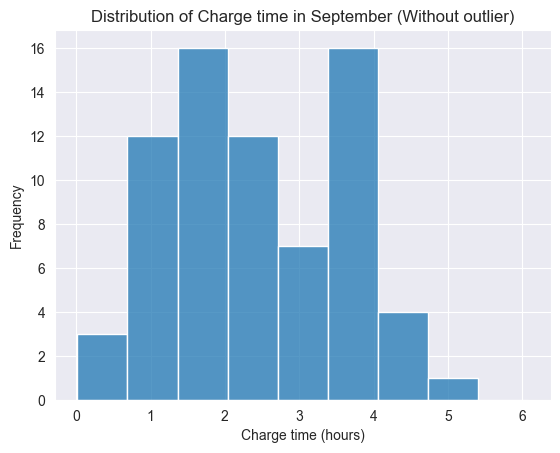

In [321]:
# September
sns.histplot(
    data=employee_data_september,
    x='Charging Duration',
    binrange=(employee_data_september['Charging Duration'].min(), employee_data_september['Charging Duration'].max() + 1)
)
plt.title('Distribution of Charge time in September (Without outlier)')
plt.ylabel('Frequency')
plt.xlabel('Charge time (hours)')

# Save figure
#plt.savefig('../Images/Employees/Redo/charge-time-distribution-without-outlier', bbox_inches='tight')
plt.show()

### Distribution of Consumption

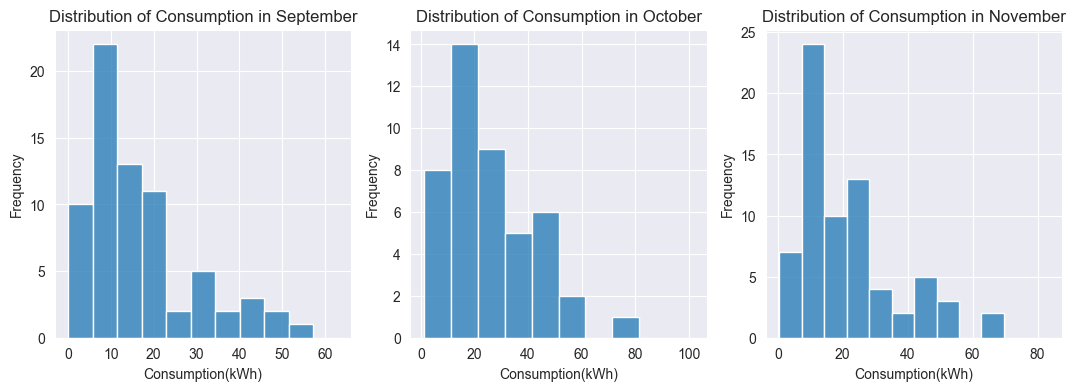

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.histplot(
    data=employee_data_september,
    x='Consumption(kWh)',
    ax=ax[0],
    binrange=(employee_data_september['Consumption(kWh)'].min(), employee_data_september['Consumption(kWh)'].max() + 10)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Consumption(kWh)')
ax[0].set_title('Distribution of Consumption in September')

# October
sns.histplot(
    data=employee_data_october,
    x='Consumption(kWh)',
    ax=ax[1],
    binrange=(employee_data_october['Consumption(kWh)'].min(), employee_data_october['Consumption(kWh)'].max() + 30)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Consumption(kWh)')
ax[1].set_title('Distribution of Consumption in October')

# November
sns.histplot(
    data=employee_data_november,
    x='Consumption(kWh)',
    ax=ax[2],
    binrange=(employee_data_november['Consumption(kWh)'].min(), employee_data_november['Consumption(kWh)'].max() + 20)
)
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Consumption(kWh)')
ax[2].set_title('Distribution of Consumption in November')

# Save figure
#plt.savefig('../Images/Employees/Redo/consumption-distribution-1', bbox_inches='tight')
plt.show()

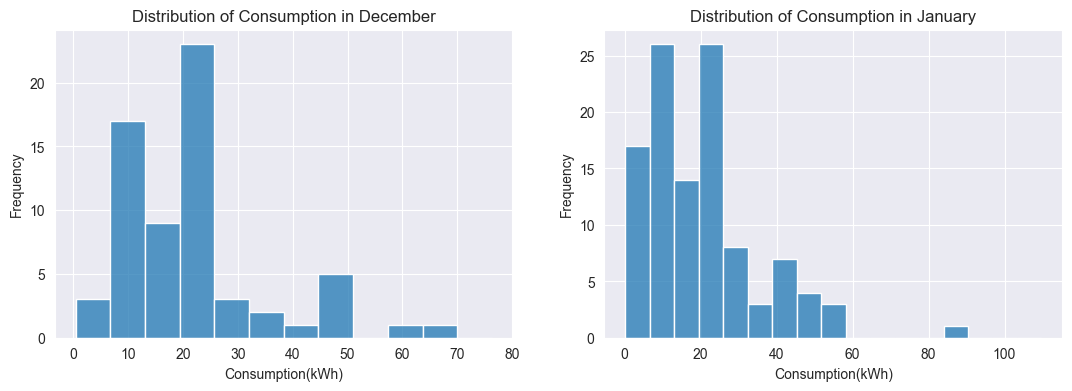

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.histplot(
    data=employee_data_december,
    x='Consumption(kWh)',
    ax=ax[0],
    binrange=(employee_data_december['Consumption(kWh)'].min(), employee_data_december['Consumption(kWh)'].max() + 10)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Consumption(kWh)')
ax[0].set_title('Distribution of Consumption in December')

# January
sns.histplot(
    data=employee_data_january,
    x='Consumption(kWh)',
    ax=ax[1],
    binrange=(employee_data_january['Consumption(kWh)'].min(), employee_data_january['Consumption(kWh)'].max() + 20)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Consumption(kWh)')
ax[1].set_title('Distribution of Consumption in January')

# Save figure
#plt.savefig('../Images/Employees/Redo/consumption-distribution-2', bbox_inches='tight')
plt.show()

### Correct outliers

#### October

In [322]:
# Obtain the index of the charge session with above 70 kWh energy consumption
employee_data_october[employee_data_october['Consumption(kWh)'] >= 70]

User Group User           Plugged in at  \
93  Mitarbeiter*in Firmenfahrzeuge MIETHKE    D 2023-10-16 08:44:26.539   

              Unplugged at  Charging Duration  Blocking Time  \
93 2023-10-16 16:10:37.952              7.395       7.436389   

                        Location Charging Station       EVSE-ID  \
93  Fritz-von-der-Lancken-Straße   KEBA_MIETHKE_2  DE*ONE*EJ5HL   

    Consumption(kWh) Plugged_in_month Unplugged_month Plugged_in_dayname  \
93            71.712          October         October             Monday   

   Unplugged_dayname  Plugged_in_time   Unplugged_time Plugged_in_time_hour  \
93            Monday  08:44:26.539000  16:10:37.952000                   08   

   Unplugged_time_hour  Hogging time  
93                  16      0.041389

In [323]:
# Obtain the mean consumption of charge sessions that have a blocking time duration of 7 to 8 hours
mean_consumption = employee_data_october[(employee_data_october['Blocking Time'] >= 7) & employee_data_october['Blocking Time'] <= 8]['Consumption(kWh)'].mean()

# Replace the outlier consumption with the mean consumption
employee_data_october.loc[93, 'Consumption(kWh)'] = mean_consumption

#### November

In [324]:
# Obtain the index of the charge session with above 60 kWh energy consumption
employee_data_november[employee_data_november['Consumption(kWh)'] >= 60]

User Group User           Plugged in at  \
147  Mitarbeiter*in Firmenfahrzeuge MIETHKE    A 2023-11-14 14:12:41.657   
173  Mitarbeiter*in Firmenfahrzeuge MIETHKE    C 2023-11-27 08:38:46.929   

               Unplugged at  Charging Duration  Blocking Time Location  \
147 2023-11-14 20:53:57.454           6.675833       6.687778  Ulanweg   
173 2023-11-27 17:43:42.415           7.092778       9.081944  Ulanweg   

     Charging Station       EVSE-ID  Consumption(kWh) Plugged_in_month  \
147  KEBA_MIETHKE_1_B  DE*ONE*EC6M1            63.414         November   
173    ABL_10332049_A  DE*ONE*E3KHJ            63.479         November   

    Unplugged_month Plugged_in_dayname Unplugged_dayname  Plugged_in_time  \
147        November            Tuesday           Tuesday  14:12:41.657000   
173        November             Monday            Monday  08:38:46.929000   

      Unplugged_time Plugged_in_time_hour Unplugged_time_hour  Hogging time  
147  20:53:57.454000                   14                  20      0.011944  
173  17:43:42.415000                   08                  17      1.989167

In [325]:
# Obtain the mean consumption of charge sessions that have a blocking time duration of 6 to 9.1 hours
mean_consumption = employee_data_november[(employee_data_november['Blocking Time'] >= 6) & employee_data_november['Blocking Time'] <= 9.1]['Consumption(kWh)'].mean()

# Replace the outlier consumption with the mean consumption
employee_data_november.loc[[147, 173], 'Consumption(kWh)'] = mean_consumption

#### December

In [326]:
# Obtain the index of the charge session with above 55 kWh energy consumption
employee_data_december[employee_data_december['Consumption(kWh)'] >= 55]

User Group User           Plugged in at  \
207  Mitarbeiter*in Firmenfahrzeuge MIETHKE    E 2023-12-07 08:59:49.441   
241  Mitarbeiter*in Firmenfahrzeuge MIETHKE    D 2023-12-20 09:02:25.783   

               Unplugged at  Charging Duration  Blocking Time  \
207 2023-12-07 18:20:21.998           6.297222         9.3425   
241 2023-12-20 16:52:04.453           6.725556         7.8275   

                         Location  Charging Station       EVSE-ID  \
207                       Ulanweg  KEBA_MIETHKE_1_A  DE*ONE*EKZC8   
241  Fritz-von-der-Lancken-Straße    KEBA_MIETHKE_2  DE*ONE*EJ5HL   

     Consumption(kWh) Plugged_in_month Unplugged_month Plugged_in_dayname  \
207            66.322         December        December           Thursday   
241            63.468         December        December          Wednesday   

    Unplugged_dayname  Plugged_in_time   Unplugged_time Plugged_in_time_hour  \
207          Thursday  08:59:49.441000  18:20:21.998000                   08   
241         Wednesday  09:02:25.783000  16:52:04.453000                   09   

    Unplugged_time_hour  Hogging time  
207                  18      3.045278  
241                  16      1.101944

In [327]:
# Obtain the mean consumption of charge sessions that have a blocking time duration of 7 to 10 hours
mean_consumption = employee_data_december[(employee_data_december['Blocking Time'] >= 7) & employee_data_december['Blocking Time'] <= 10]['Consumption(kWh)'].mean()

# Replace the outlier consumption with the mean consumption
employee_data_december.loc[[207, 241], 'Consumption(kWh)'] = mean_consumption

#### January

In [328]:
# Obtain the index of the charge session with above 80 kWh energy consumption
employee_data_january[employee_data_january['Consumption(kWh)'] >= 80]

User Group User           Plugged in at  \
351  Mitarbeiter*in Firmenfahrzeuge MIETHKE    A 2024-01-29 11:14:07.858   

               Unplugged at  Charging Duration  Blocking Time Location  \
351 2024-01-29 19:40:42.398           8.406111       8.443056  Ulanweg   

    Charging Station       EVSE-ID  Consumption(kWh) Plugged_in_month  \
351   ABL_10332049_B  DE*ONE*E68JX            89.725          January   

    Unplugged_month Plugged_in_dayname Unplugged_dayname  Plugged_in_time  \
351         January             Monday            Monday  11:14:07.858000   

      Unplugged_time Plugged_in_time_hour Unplugged_time_hour  Hogging time  
351  19:40:42.398000                   11                  19      0.036944

In [329]:
# Obtain the mean consumption of charge sessions that have a blocking duration of 8 to 9 hours
mean_consumption = employee_data_january[(employee_data_january['Blocking Time'] >= 8) & employee_data_january['Blocking Time'] <= 9]['Consumption(kWh)'].mean()

# Replace the outlier consumption with the mean consumption
employee_data_january.loc[351, 'Consumption(kWh)'] = mean_consumption

Redo the plots without outliers

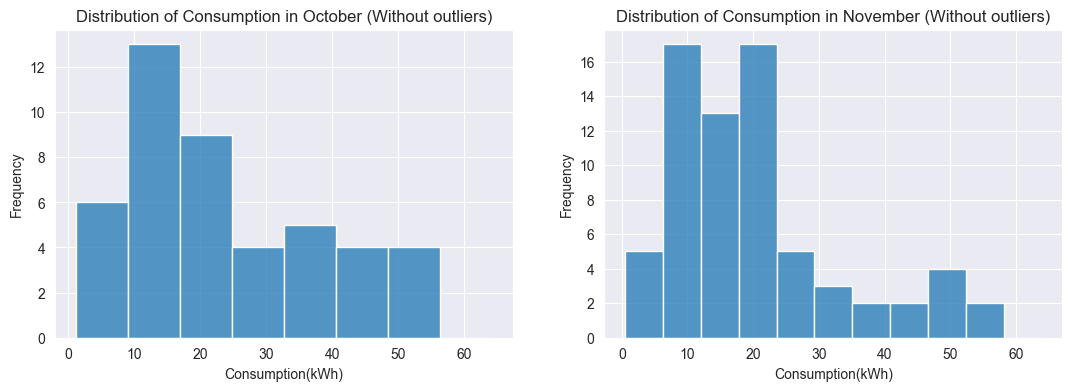

In [330]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# October
sns.histplot(
    data=employee_data_october,
    x='Consumption(kWh)',
    ax=ax[0],
    binrange=(employee_data_october['Consumption(kWh)'].min(), employee_data_october['Consumption(kWh)'].max() + 10)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Consumption(kWh)')
ax[0].set_title('Distribution of Consumption in October (Without outliers)')

# November
sns.histplot(
    data=employee_data_november,
    x='Consumption(kWh)',
    ax=ax[1],
    binrange=(employee_data_november['Consumption(kWh)'].min(), employee_data_november['Consumption(kWh)'].max() + 10)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Consumption(kWh)')
ax[1].set_title('Distribution of Consumption in November (Without outliers)')

# Save figure
#plt.savefig('../Images/Employees/Redo/consumption-distribution-1-without-outlier', bbox_inches='tight')
plt.show()

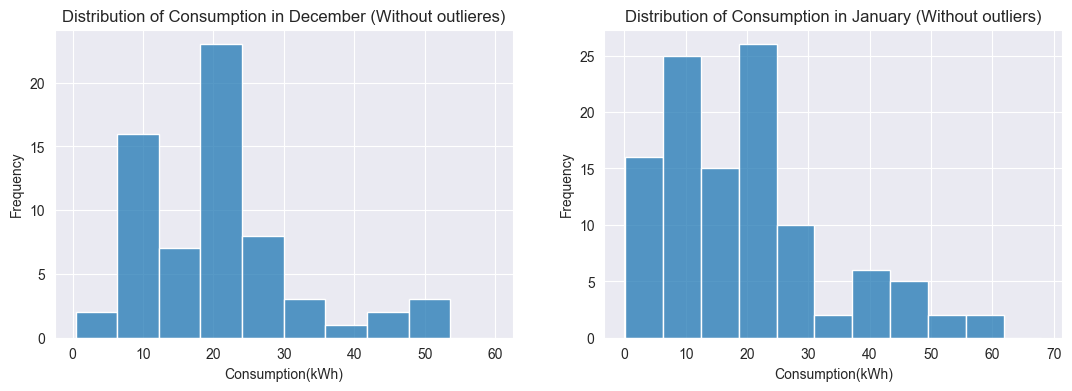

In [331]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.histplot(
    data=employee_data_december,
    x='Consumption(kWh)',
    ax=ax[0],
    binrange=(employee_data_december['Consumption(kWh)'].min(), employee_data_december['Consumption(kWh)'].max() + 10)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Consumption(kWh)')
ax[0].set_title('Distribution of Consumption in December (Without outlieres)')

# January
sns.histplot(
    data=employee_data_january,
    x='Consumption(kWh)',
    ax=ax[1],
    binrange=(employee_data_january['Consumption(kWh)'].min(), employee_data_january['Consumption(kWh)'].max() + 10)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Consumption(kWh)')
ax[1].set_title('Distribution of Consumption in January (Without outliers)')

# Save figure
#plt.savefig('../Images/Employees/Redo/consumption-distribution-2-without-outlier', bbox_inches='tight')
plt.show()

### Consumption (monthly)

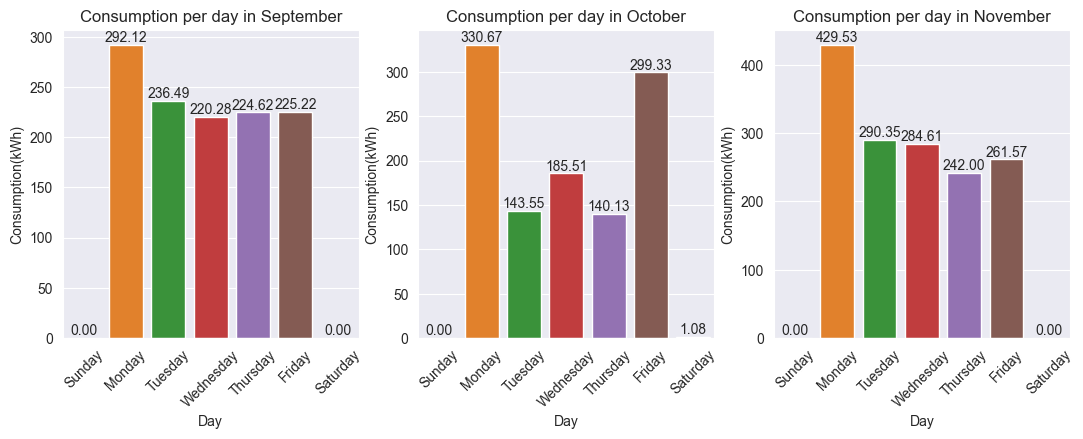

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.barplot(
    data=employee_data_september.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Consumption per day in September')
ax[0].set_ylabel('Consumption(kWh)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# October
sns.barplot(
    data=employee_data_october.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Consumption per day in October')
ax[1].set_ylabel('Consumption(kWh)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# November
sns.barplot(
    data=employee_data_november.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[2]
)
ax[2].set_title('Consumption per day in November')
ax[2].set_ylabel('Consumption(kWh)')
ax[2].set_xlabel('Day')
ax[2].tick_params(axis='x', rotation=45)
ax[2].bar_label(ax[2].containers[0], fontsize=10, fmt='%.2f')

# Save figure
#plt.savefig('../Images/Employees/Redo/consumption-per-day-1', bbox_inches='tight')
plt.show()

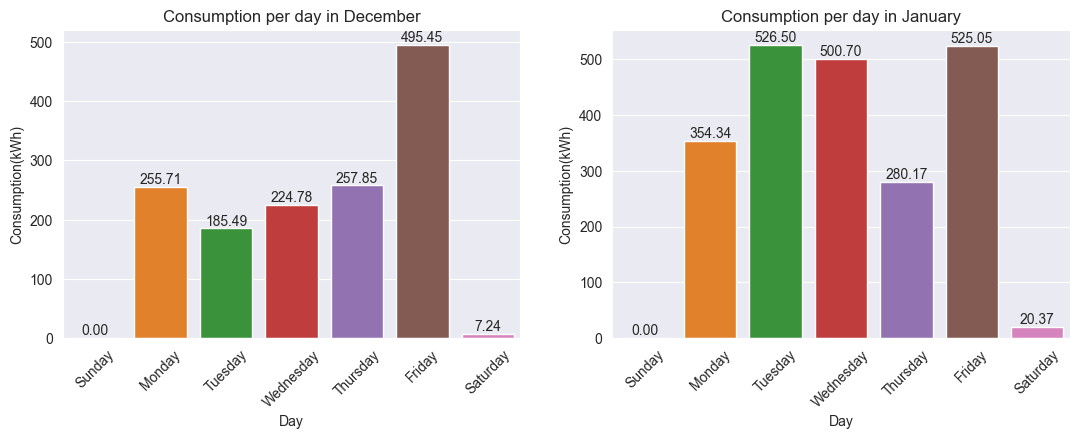

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.barplot(
    data=employee_data_december.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Consumption per day in December')
ax[0].set_ylabel('Consumption(kWh)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# January
sns.barplot(
    data=employee_data_january.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Consumption per day in January')
ax[1].set_ylabel('Consumption(kWh)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
#plt.savefig('../Images/Employees/Redo/consumption-per-day-2', bbox_inches='tight')
plt.show()

#### Without outlier

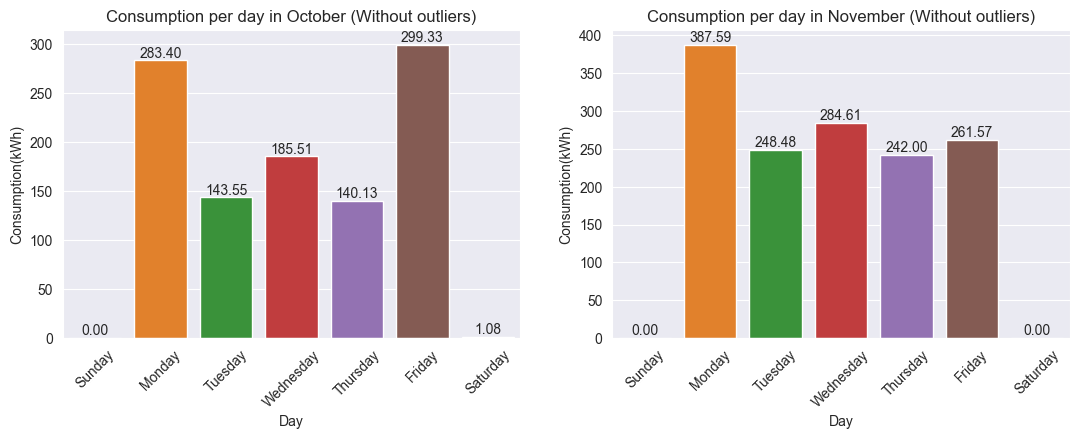

In [332]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# October
sns.barplot(
    data=employee_data_october.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Consumption per day in October (Without outliers)')
ax[0].set_ylabel('Consumption(kWh)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# November
sns.barplot(
    data=employee_data_november.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Consumption per day in November (Without outliers)')
ax[1].set_ylabel('Consumption(kWh)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
#plt.savefig('../Images/Employees/Redo/consumption-per-day-1-without-outlier', bbox_inches='tight')
plt.show()

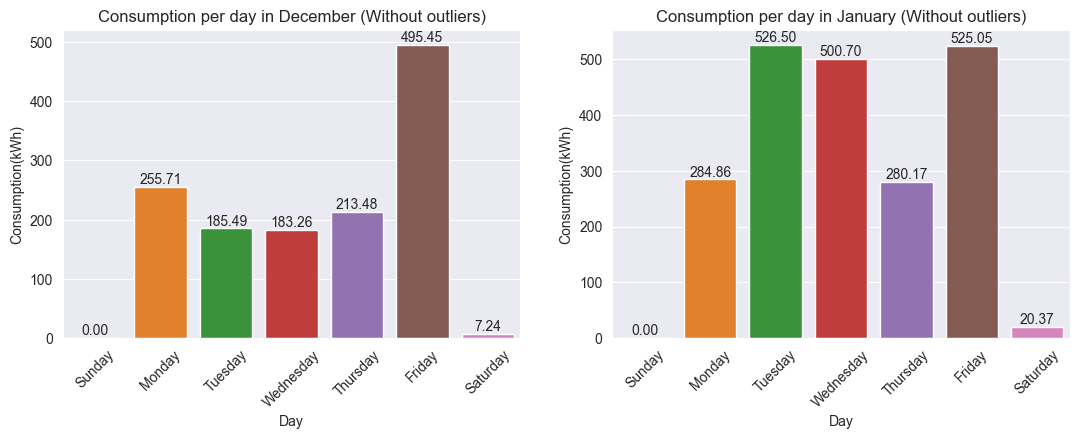

In [333]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.barplot(
    data=employee_data_december.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Consumption per day in December (Without outliers)')
ax[0].set_ylabel('Consumption(kWh)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# January
sns.barplot(
    data=employee_data_january.sort_values('Plugged_in_dayname'),
    y='Consumption(kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Consumption per day in January (Without outliers)')
ax[1].set_ylabel('Consumption(kWh)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
#plt.savefig('../Images/Employees/Redo/consumption-per-day-2-without-outlier', bbox_inches='tight')
plt.show()

### Distribution of Hogging time

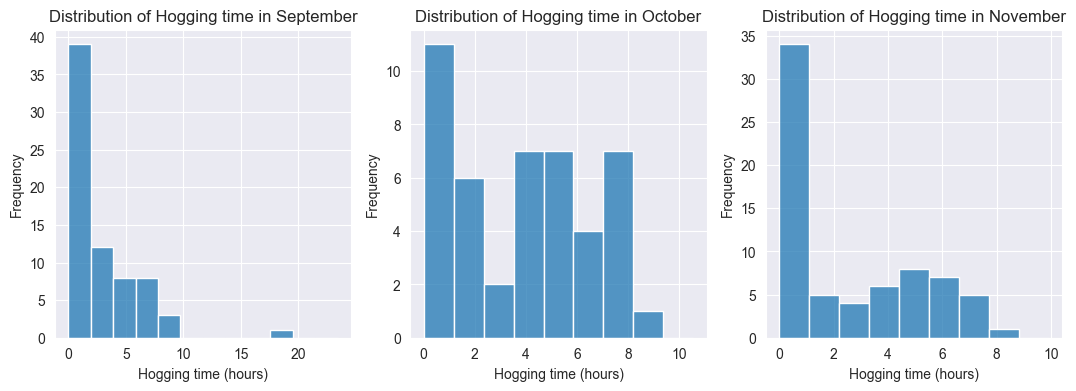

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.histplot(
    data=employee_data_september,
    x='Hogging time',
    ax=ax[0],
    binrange=(employee_data_september['Hogging time'].min(), employee_data_september['Hogging time'].max() + 5)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Hogging time (hours)')
ax[0].set_title('Distribution of Hogging time in September')

# October
sns.histplot(
    data=employee_data_october,
    x='Hogging time',
    ax=ax[1],
    binrange=(employee_data_october['Hogging time'].min(), employee_data_october['Hogging time'].max() + 2)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Hogging time (hours)')
ax[1].set_title('Distribution of Hogging time in October')

# November
sns.histplot(
    data=employee_data_november,
    x='Hogging time',
    ax=ax[2],
    binrange=(employee_data_november['Hogging time'].min(), employee_data_november['Hogging time'].max() + 2)
)
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Hogging time (hours)')
ax[2].set_title('Distribution of Hogging time in November')

# Save figure
#plt.savefig('../Images/Employees/Redo/hogging-time-distribution-1', bbox_inches='tight')
plt.show()

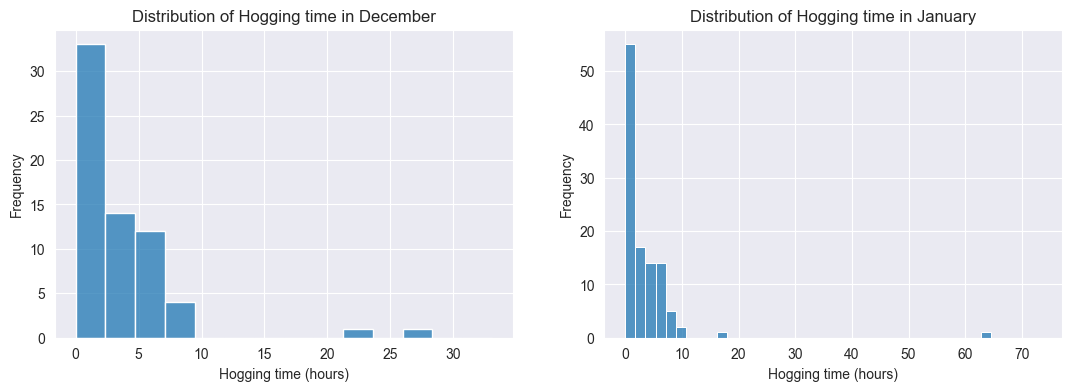

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.histplot(
    data=employee_data_december,
    x='Hogging time',
    ax=ax[0],
    binrange=(employee_data_december['Hogging time'].min(), employee_data_december['Hogging time'].max() + 5)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Hogging time (hours)')
ax[0].set_title('Distribution of Hogging time in December')

# October
sns.histplot(
    data=employee_data_january,
    x='Hogging time',
    ax=ax[1],
    binrange=(employee_data_january['Hogging time'].min(), employee_data_january['Hogging time'].max() + 10)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Hogging time (hours)')
ax[1].set_title('Distribution of Hogging time in January')

# Save figure
#plt.savefig('../Images/Employees/Redo/hogging-time-distribution-2', bbox_inches='tight')
plt.show()

#### Hogging time percentage per month

In [90]:
employee_data_hogging_month = employee_data.groupby('Plugged_in_month')['Hogging time'].sum().reset_index()

In [91]:
employee_data_hogging_month['Percentage'] = (employee_data_hogging_month['Hogging time'] / employee_data_hogging_month['Hogging time'].sum()) * 100

In [92]:
employee_data_hogging_month

Plugged_in_month  Hogging time  Percentage
0        September    184.970833   16.929673
1          October    174.330000   15.955758
2         November    175.847222   16.094624
3         December    211.280000   19.337650
4          January    346.155556   31.682294

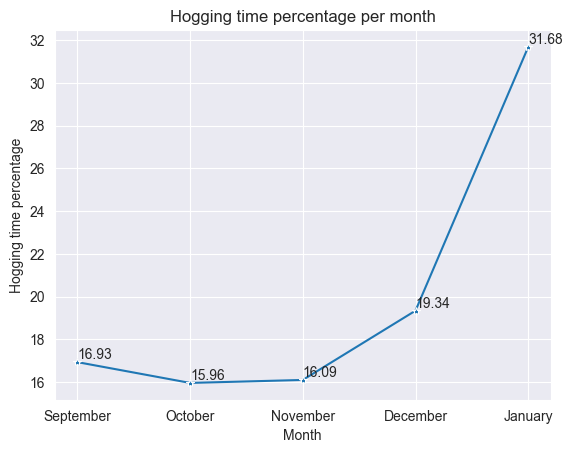

In [93]:
ax = sns.lineplot(
    data=employee_data_hogging_month,
    x='Plugged_in_month',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*'
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
for i, (x_val, y_val) in enumerate(zip(employee_data_hogging_month['Plugged_in_month'], employee_data_hogging_month['Percentage'])):
    plt.text(i, y_val, f'{y_val:.2f}', ha='left', va='bottom')
plt.xlabel('Month')
plt.ylabel('Hogging time percentage')
plt.title('Hogging time percentage per month')

# Save figure
#plt.savefig('../Images/Employees/Redo/hogging-time-percentage-per-month', bbox_inches='tight')
plt.show()

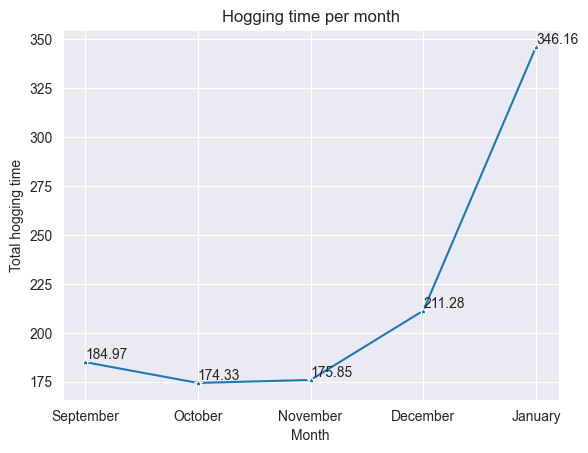

In [101]:
ax = sns.lineplot(
    data=employee_data,
    x='Plugged_in_month',
    y='Hogging time',
    estimator='sum',
    ci=None,
    marker='*'
)
plt.xlabel('Month')
plt.ylabel('Total hogging time')
plt.title('Hogging time per month')
for i, (x_val, y_val) in enumerate(zip(employee_data_hogging_month['Plugged_in_month'], employee_data_hogging_month['Hogging time'])):
    plt.text(i, y_val, f'{y_val:.2f}', ha='left', va='bottom')

# Save figure
#plt.savefig('../Images/Employees/Redo/hogging-time-per-month', bbox_inches='tight')
plt.show()

In [102]:
employee_data_hogging_day = employee_data.groupby('Plugged_in_dayname')['Hogging time'].sum().reset_index()
employee_data_hogging_day['Percentage'] = (employee_data_hogging_day['Hogging time'] / employee_data_hogging_day['Hogging time'].sum()) * 100

In [105]:
def get_hogging_time_percentage(month):
    employee_data_month = employee_data[employee_data['Plugged_in_month'] == month]
    employee_data_month = employee_data_month.groupby('Plugged_in_dayname')['Hogging time'].sum().reset_index()
    employee_data_month['Percentage'] = (employee_data_month['Hogging time'] / employee_data_month['Hogging time'].sum()) * 100
    return employee_data_month

In [110]:
employee_data_hogging_september = get_hogging_time_percentage('September')
employee_data_hogging_october = get_hogging_time_percentage('October')
employee_data_hogging_november = get_hogging_time_percentage('November')
employee_data_hogging_december = get_hogging_time_percentage('November')
employee_data_hogging_january = get_hogging_time_percentage('January')

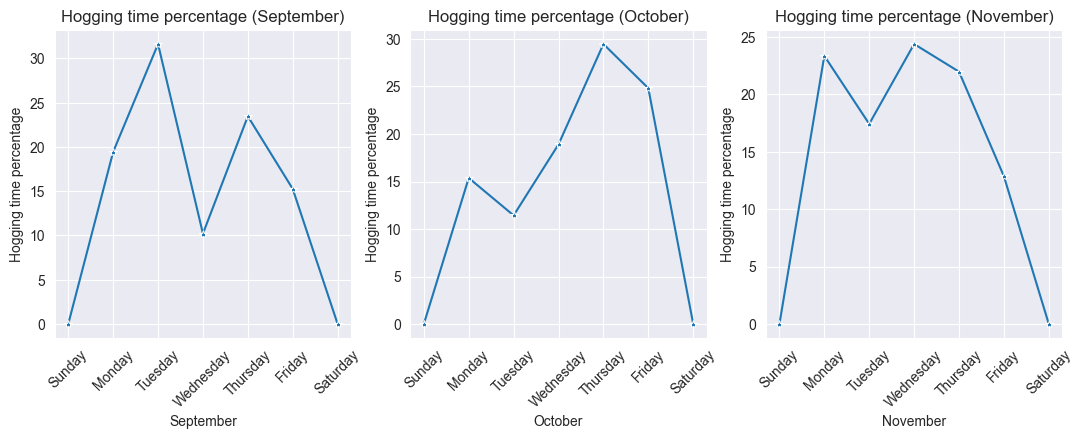

In [123]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.lineplot(
    data=employee_data_hogging_september,
    x='Plugged_in_dayname',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*',
    ax=ax[0]
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
# for i, (x_val, y_val) in enumerate(zip(employee_data_hogging_september['Plugged_in_dayname'], employee_data_hogging_month['Percentage'])):
#     ax[0].text(i, y_val, f'{y_val:.0f}', ha='left', va='bottom')
ax[0].set_xlabel('September')
ax[0].set_ylabel('Hogging time percentage')
ax[0].set_title('Hogging time percentage (September)')
ax[0].tick_params(axis='x', rotation=45)

# October
sns.lineplot(
    data=employee_data_hogging_october,
    x='Plugged_in_dayname',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*',
    ax=ax[1]
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
# for i, (x_val, y_val) in enumerate(zip(employee_data_hogging_month['Plugged_in_month'], employee_data_hogging_month['Percentage'])):
#     plt.text(i, y_val, f'{y_val:.2f}', ha='left', va='bottom')
ax[1].set_xlabel('October')
ax[1].set_ylabel('Hogging time percentage')
ax[1].set_title('Hogging time percentage (October)')
ax[1].tick_params(axis='x', rotation=45)

# November
sns.lineplot(
    data=employee_data_hogging_november,
    x='Plugged_in_dayname',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*',
    ax=ax[2]
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
# for i, (x_val, y_val) in enumerate(zip(employee_data_hogging_month['Plugged_in_month'], employee_data_hogging_month['Percentage'])):
#     plt.text(i, y_val, f'{y_val:.2f}', ha='left', va='bottom')
ax[2].set_xlabel('November')
ax[2].set_ylabel('Hogging time percentage')
ax[2].set_title('Hogging time percentage (November)')
ax[2].tick_params(axis='x', rotation=45)

# Save figure
#plt.savefig('../Images/Employees/Redo/hogging-time-percentage-per-month', bbox_inches='tight')
plt.show()

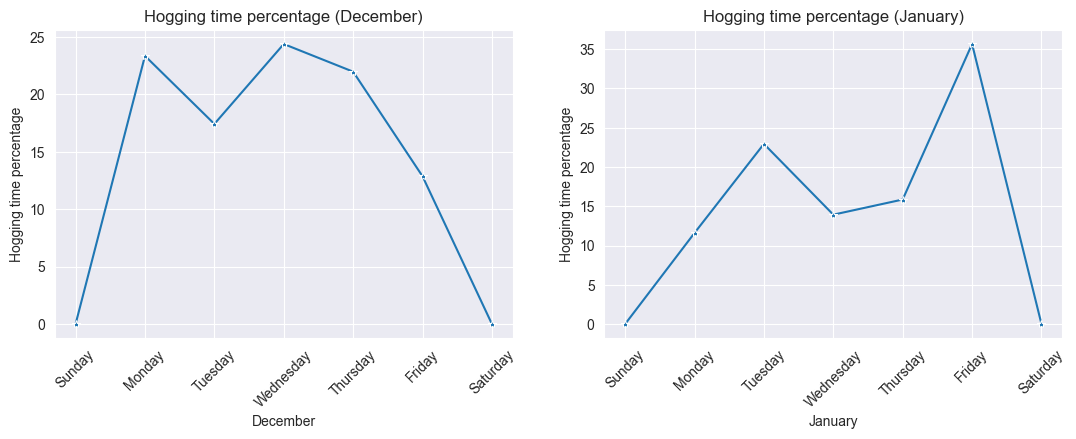

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.lineplot(
    data=employee_data_hogging_december,
    x='Plugged_in_dayname',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*',
    ax=ax[0]
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
# for i, (x_val, y_val) in enumerate(zip(employee_data_hogging_september['Plugged_in_dayname'], employee_data_hogging_month['Percentage'])):
#     ax[0].text(i, y_val, f'{y_val:.0f}', ha='left', va='bottom')
ax[0].set_xlabel('December')
ax[0].set_ylabel('Hogging time percentage')
ax[0].set_title('Hogging time percentage (December)')
ax[0].tick_params(axis='x', rotation=45)

# January
sns.lineplot(
    data=employee_data_hogging_january,
    x='Plugged_in_dayname',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*',
    ax=ax[1]
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
# for i, (x_val, y_val) in enumerate(zip(employee_data_hogging_month['Plugged_in_month'], employee_data_hogging_month['Percentage'])):
#     plt.text(i, y_val, f'{y_val:.2f}', ha='left', va='bottom')
ax[1].set_xlabel('January')
ax[1].set_ylabel('Hogging time percentage')
ax[1].set_title('Hogging time percentage (January)')
ax[1].tick_params(axis='x', rotation=45)

# Save figure
#plt.savefig('../Images/Employees/Redo/hogging-time-percentage-per-month', bbox_inches='tight')
plt.show()

#### Calculate hogging time without outliers

In [334]:
# Obtain the hogging time for the corrected data
employee_data_september['Hogging time'] = employee_data_september['Blocking Time'] - employee_data_september['Charging Duration']
employee_data_october['Hogging time'] = employee_data_october['Blocking Time'] - employee_data_october['Charging Duration']
employee_data_november['Hogging time'] = employee_data_november['Blocking Time'] - employee_data_november['Charging Duration']
employee_data_december['Hogging time'] = employee_data_december['Blocking Time'] - employee_data_december['Charging Duration']
employee_data_january['Hogging time'] = employee_data_january['Blocking Time'] - employee_data_january['Charging Duration']

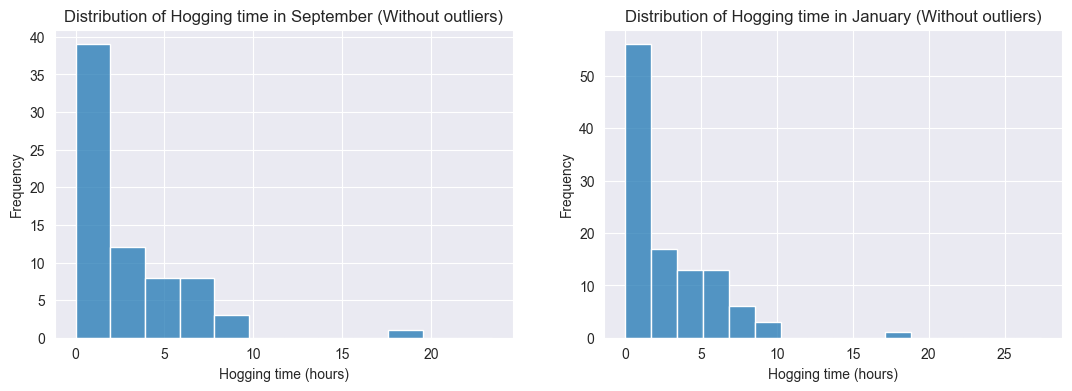

In [335]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.histplot(
    data=employee_data_september,
    x='Hogging time',
    ax=ax[0],
    binrange=(employee_data_september['Hogging time'].min(), employee_data_september['Hogging time'].max() + 5)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Hogging time (hours)')
ax[0].set_title('Distribution of Hogging time in September (Without outliers)')

# October
sns.histplot(
    data=employee_data_january,
    x='Hogging time',
    ax=ax[1],
    binrange=(employee_data_january['Hogging time'].min(), employee_data_january['Hogging time'].max() + 10)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Hogging time (hours)')
ax[1].set_title('Distribution of Hogging time in January (Without outliers)')

# Save figure
#plt.savefig('../Images/Employees/Redo/hogging-time-distribution-2-without-outlier', bbox_inches='tight')
plt.show()

### Connection and Charge time (monthly)

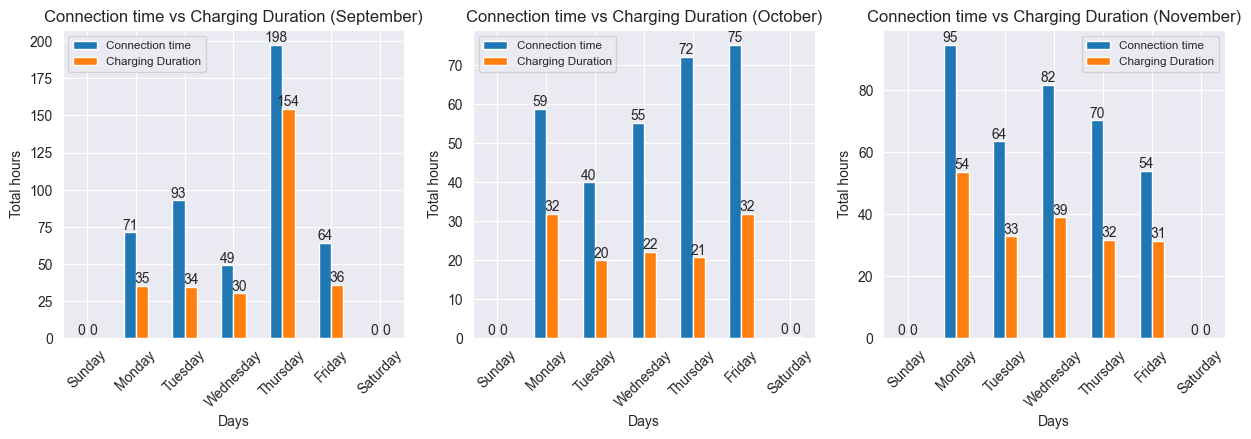

In [126]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# September
employee_data_september.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[0])
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Total hours')
ax[0].legend(['Connection time', 'Charging Duration'], fontsize=8.5)
ax[0].set_title('Connection time vs Charging Duration (September)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=10, fmt='%.0f')

# October
employee_data_october.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[1])
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Total hours')
ax[1].legend(['Connection time', 'Charging Duration'], loc='upper left', fontsize=8.5)
ax[1].set_title('Connection time vs Charging Duration (October)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=10, fmt='%.0f')

# November
employee_data_november.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[2])
#ax[2].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Total hours')
ax[2].legend(['Connection time', 'Charging Duration'], loc='upper right', fontsize=8.5)
ax[2].set_title('Connection time vs Charging Duration (November)')
ax[2].tick_params(axis='x', rotation=45)
ax[2].bar_label(ax[2].containers[0], fontsize=10, fmt='%.0f')
ax[2].bar_label(ax[2].containers[1], fontsize=10, fmt='%.0f')

# Save figure
#plt.savefig('../Images/Employees/Redo/average-connection-charge-time-per-day-1', bbox_inches='tight')
plt.show()

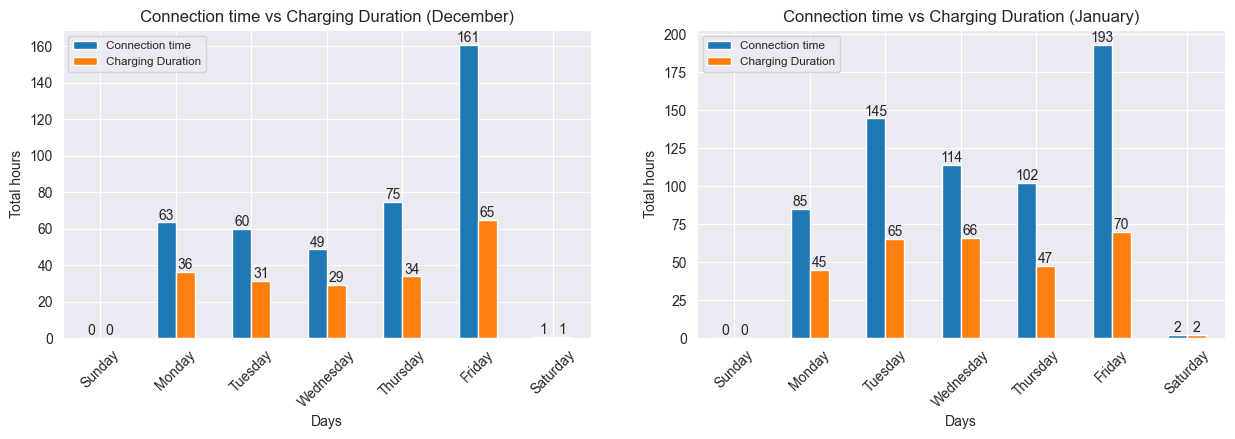

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# September
employee_data_december.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[0])
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Total hours')
ax[0].legend(['Connection time', 'Charging Duration'], fontsize=8.5)
ax[0].set_title('Connection time vs Charging Duration (December)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=10, fmt='%.0f')

# October
employee_data_january.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[1])
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Total hours')
ax[1].legend(['Connection time', 'Charging Duration'], loc='upper left', fontsize=8.5)
ax[1].set_title('Connection time vs Charging Duration (January)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=10, fmt='%.0f')

# Save figure
#plt.savefig('../Images/Employees/Redo/average-connection-charge-time-2', bbox_inches='tight')
plt.show()

#### Without outliers

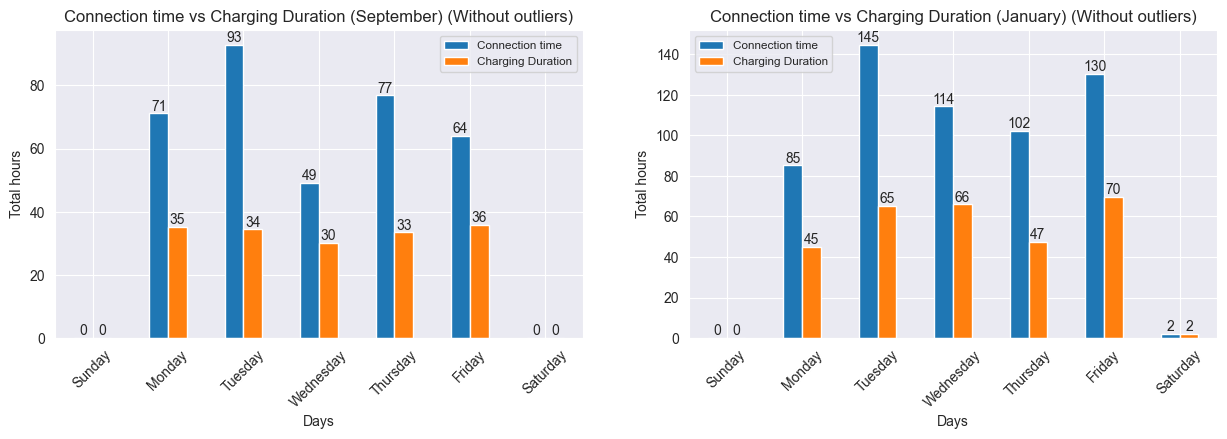

In [336]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# September
employee_data_september.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[0])
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Total hours')
ax[0].legend(['Connection time', 'Charging Duration'], fontsize=8.5)
ax[0].set_title('Connection time vs Charging Duration (September) (Without outliers)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=10, fmt='%.0f')

# January
employee_data_january.groupby('Plugged_in_dayname')[['Blocking Time', 'Charging Duration']].sum().plot(kind='bar', ax=ax[1])
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Total hours')
ax[1].legend(['Connection time', 'Charging Duration'], loc='upper left', fontsize=8.5)
ax[1].set_title('Connection time vs Charging Duration (January) (Without outliers)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=10, fmt='%.0f')

# Save figure
#plt.savefig('../Images/Employees/Redo/average-connection-charge-time-2-without-outlier', bbox_inches='tight')
plt.show()

### Number of Charge sessions

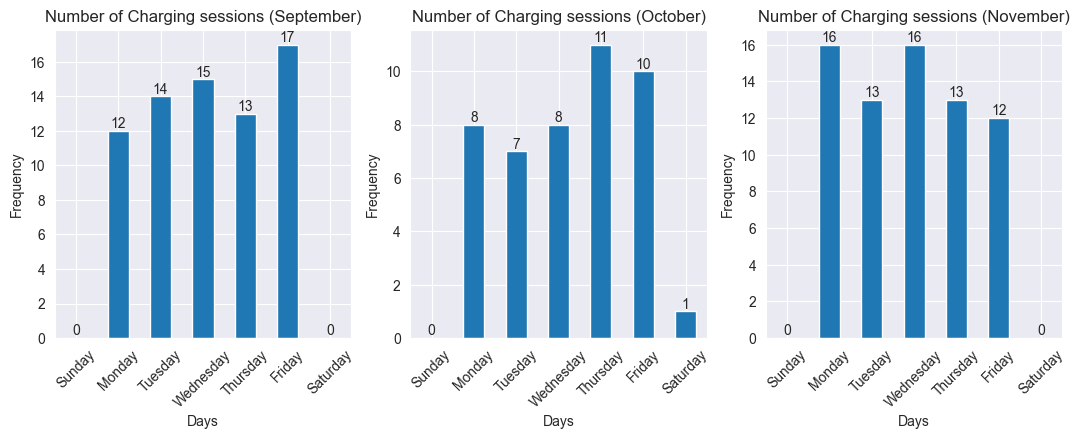

In [128]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))

# September
employee_data_september.groupby('Plugged_in_dayname')['Charging Duration'].count().plot(kind='bar', ax=ax[0])
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Number of Charging sessions (September)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10)

# October
employee_data_october.groupby('Plugged_in_dayname')['Charging Duration'].count().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Number of Charging sessions (October)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10)

# November
employee_data_november.groupby('Plugged_in_dayname')['Charging Duration'].count().plot(kind='bar', ax=ax[2])
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Number of Charging sessions (November)')
ax[2].tick_params(axis='x', rotation=45)
ax[2].bar_label(ax[2].containers[0], fontsize=10)

# Save figure
#plt.savefig('../Images/Employees/Redo/charge-sessions-per-day-1', bbox_inches='tight')
plt.show()

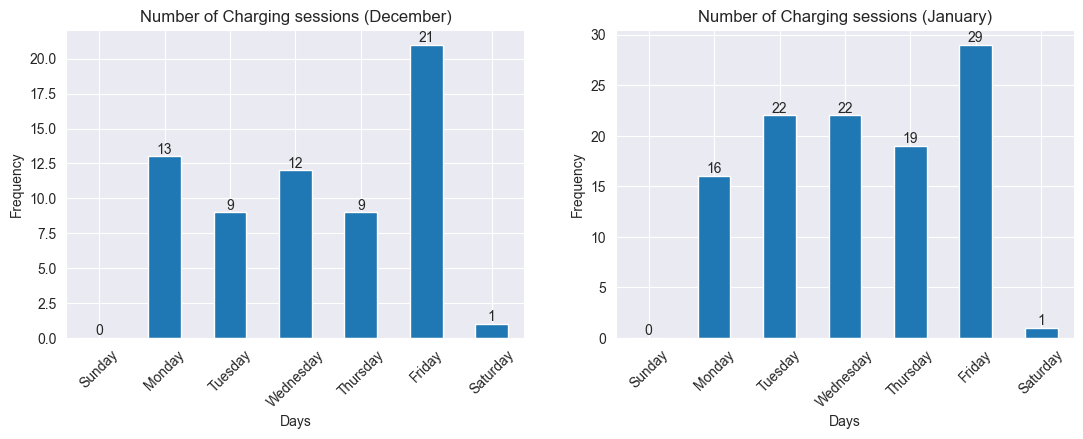

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

# December
employee_data_december.groupby('Plugged_in_dayname')['Charging Duration'].count().plot(kind='bar', ax=ax[0])
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Number of Charging sessions (December)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10)

# January
employee_data_january.groupby('Plugged_in_dayname')['Charging Duration'].count().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Number of Charging sessions (January)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10)

# Save figure
#plt.savefig('../Images/Employees/Redo/charge-sessions-per-day-2', bbox_inches='tight')
plt.show()

### Number of charge sessions by plug-in and unplugged times

In [130]:
plug_in = employee_data.groupby(['Plugged_in_time_hour'])['Plugged_in_time_hour'].value_counts(dropna=False).reset_index()
plug_out = employee_data.groupby(['Unplugged_time_hour'])['Unplugged_time_hour'].value_counts(dropna=False).reset_index()

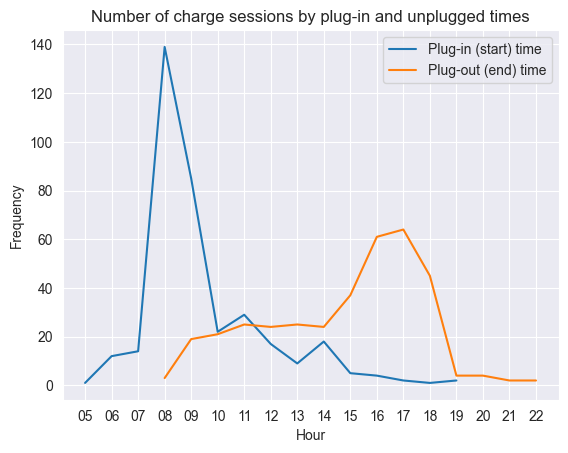

In [131]:
sns.lineplot(
    data=plug_in,
    x='Plugged_in_time_hour',
    y='count',
    label='Plug-in (start) time',
)
sns.lineplot(
    data=plug_out,
    x='Unplugged_time_hour',
    y='count',
    label='Plug-out (end) time',
)
plt.title('Number of charge sessions by plug-in and unplugged times')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.legend()

# Save figure
#plt.savefig('../Images/Employees/Redo/number-of-charge-sessions-per-plugin-unplugged-times', bbox_inches='tight')
plt.show()

### Connection time of each employee

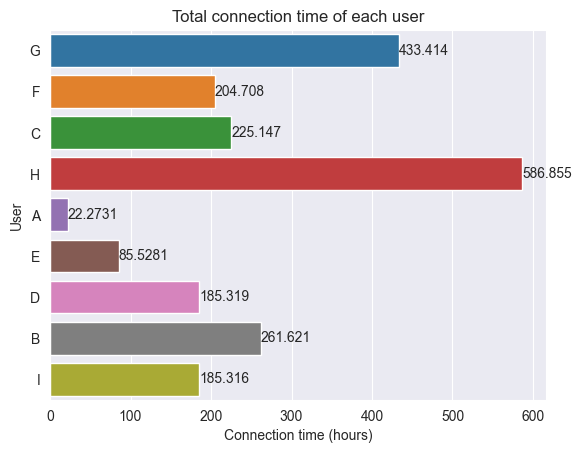

In [132]:
ax = sns.barplot(
    data=employee_data,
    y='User',
    x='Blocking Time',
    estimator='sum',
    errorbar=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Connection time (hours)')
plt.title('Total connection time of each user')

# Save figure
#plt.savefig('../Images/Employees/Redo/blocking-time-user', bbox_inches='tight')
plt.show()

#### Without outlier

In [337]:
# Join the five months dataframes to a single one reflecting the corrected outliers
employee_data_concat = pd.concat([
    employee_data_september,
    employee_data_october,
    employee_data_november,
    employee_data_december,
    employee_data_january
], axis=0)

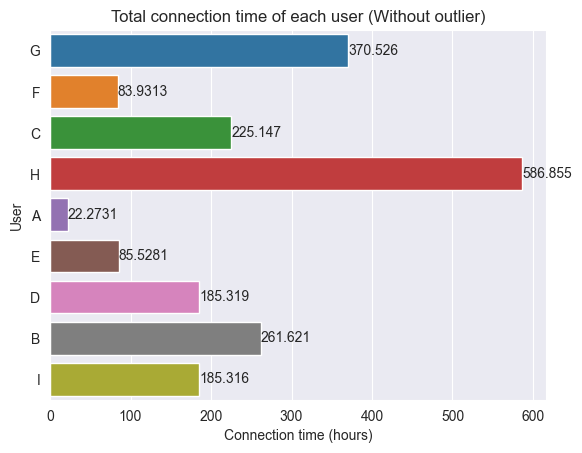

In [338]:
ax = sns.barplot(
    data=employee_data_concat,
    y='User',
    x='Blocking Time',
    estimator='sum',
    errorbar=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Connection time (hours)')
plt.title('Total connection time of each user (Without outlier)')

# Save figure
#plt.savefig('../Images/Employees/Redo/blocking-time-user-without-outlier', bbox_inches='tight')
plt.show()

### Charge time of each employee

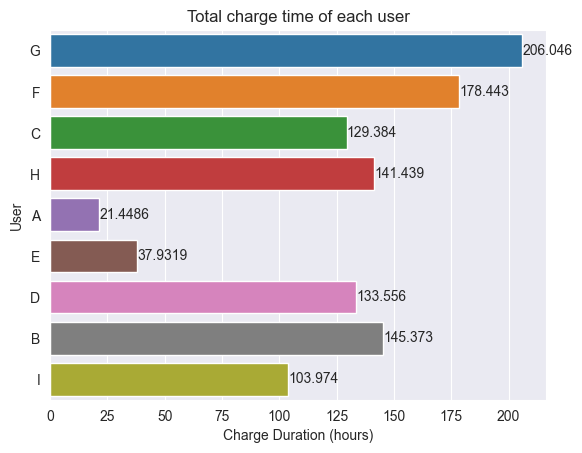

In [133]:
ax = sns.barplot(
    data=employee_data,
    y='User',
    x='Charging Duration',
    estimator='sum',
    errorbar=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Charge Duration (hours)')
plt.title('Total charge time of each user')

# Save figure
#plt.savefig('../Images/Employees/Redo/charge-session-user', bbox_inches='tight')
plt.show()

#### Without outlier

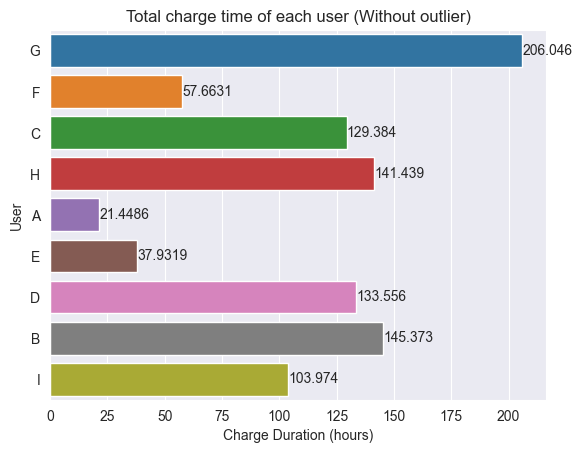

In [339]:
ax = sns.barplot(
    data=employee_data_concat,
    y='User',
    x='Charging Duration',
    estimator='sum',
    errorbar=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Charge Duration (hours)')
plt.title('Total charge time of each user (Without outlier)')

# Save figure
#plt.savefig('../Images/Employees/Redo/charge-session-user-without-outlier', bbox_inches='tight')
plt.show()

### Hogging time of each employee

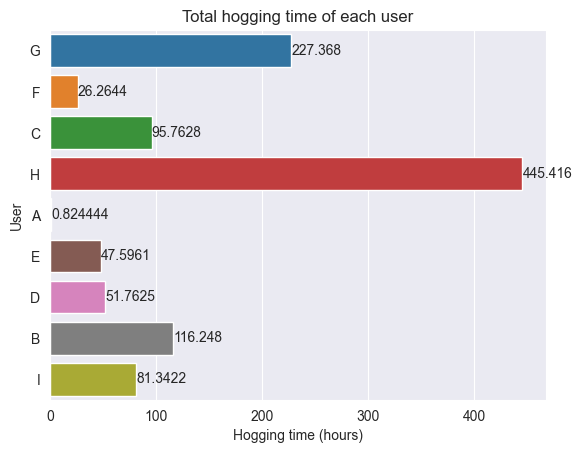

In [134]:
ax = sns.barplot(
    data=employee_data,
    y='User',
    x='Hogging time',
    estimator='sum',
    errorbar=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Hogging time (hours)')
plt.title('Total hogging time of each user')

# Save figure
#plt.savefig('../Images/Employees/Redo/hogging-time-user', bbox_inches='tight')
plt.show()

#### Without outlier

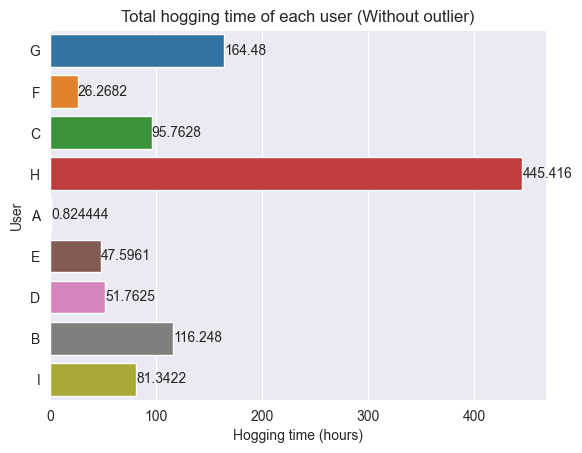

In [340]:
ax = sns.barplot(
    data=employee_data_concat,
    y='User',
    x='Hogging time',
    estimator='sum',
    errorbar=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Hogging time (hours)')
plt.title('Total hogging time of each user (Without outlier)')

# Save figure
#plt.savefig('../Images/Employees/Redo/hogging-time-user-without-outlier', bbox_inches='tight')
plt.show()

### Charge utilization of vehicles

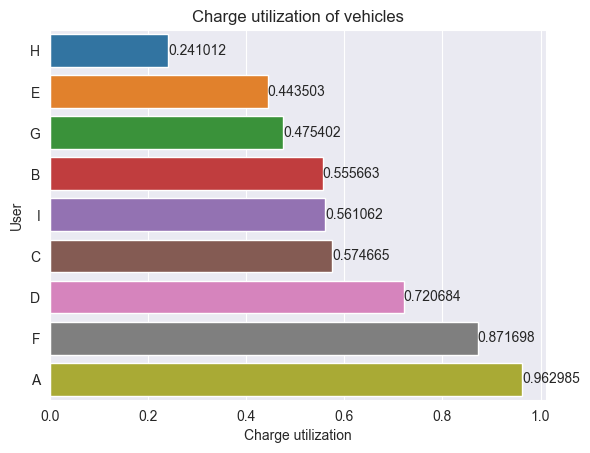

In [135]:
# Calculate charge utilization
employee_data_charge_util = employee_data.groupby('User')[['Blocking Time', 'Charging Duration']].sum().reset_index()
employee_data_charge_util['Charge utilization'] = employee_data_charge_util['Charging Duration'] / employee_data_charge_util['Blocking Time']

# Display a barplot of charge utilization of each employee
ax = sns.barplot(
    data=employee_data_charge_util.sort_values(['Charge utilization']),
    x='Charge utilization',
    y='User'
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Charge utilization of vehicles')

# Save figure
#plt.savefig('../Images/Employees/Redo/charge-utilization-user', bbox_inches='tight')
plt.show()

#### Without outliers

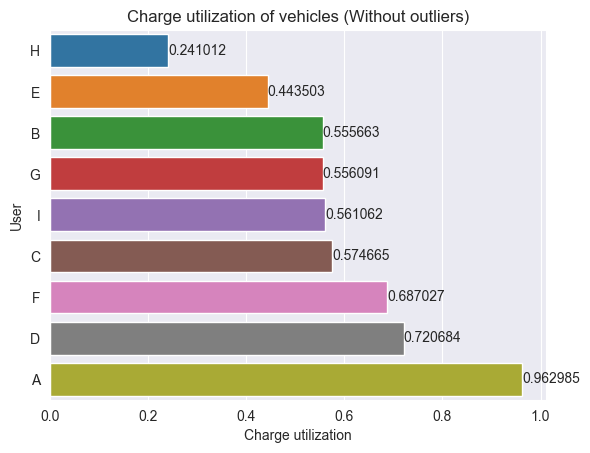

In [341]:
# Calculate charge utilization
employee_data_charge_util = employee_data_concat.groupby('User')[['Blocking Time', 'Charging Duration']].sum().reset_index()
employee_data_charge_util['Charge utilization'] = employee_data_charge_util['Charging Duration'] / employee_data_charge_util['Blocking Time']

# Display a barplot of charge utilization of each employee
ax = sns.barplot(
    data=employee_data_charge_util.sort_values(['Charge utilization']),
    x='Charge utilization',
    y='User'
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Charge utilization of vehicles (Without outliers)')

# Save figure
#plt.savefig('../Images/Employees/Redo/charge-utilization-user-without-outlier', bbox_inches='tight')
plt.show()

### Consumption per month

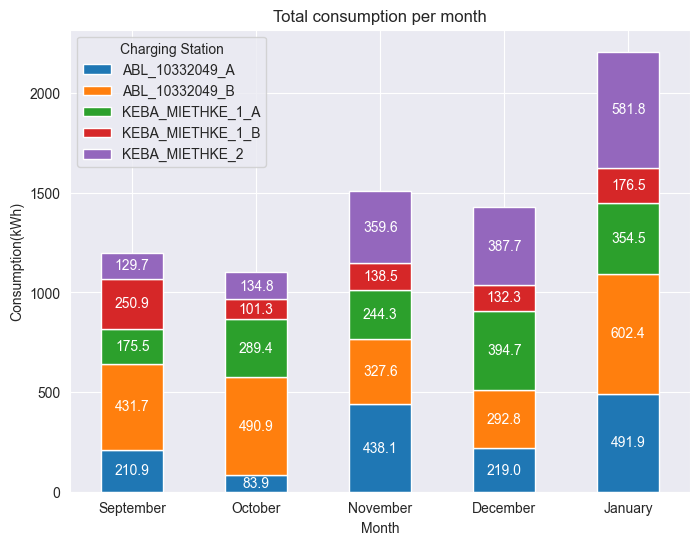

In [232]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
df = employee_data.pivot_table(index='Plugged_in_month', columns='Charging Station', values='Consumption(kWh)', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=0)
#ax.set_figsize(12,8)
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Consumption(kWh)')
ax.set_xlabel('Month')
ax.set_title('Total consumption per month')
plt.show()

In [224]:
# # Stack the consumption of each station per month
# x = (
#     so.Plot(employee_data, x="Plugged_in_month", y='Consumption(kWh)', color="Charging Station")
#     .add(so.Bar(), so.Agg('sum'), so.Stack())
#     .label(y='Consumption(kWh)', x='Month', title='Total consumption per month')
# )

# x.show()
# # Save figure
# #x.save('../Images/Employees/Redo/consumption-per-month')

In [225]:
employee_data.groupby(['Plugged_in_month'])['Consumption(kWh)'].sum()

Plugged_in_month
September    1198.732
October      1100.265
November     1508.063
December     1426.529
January      2207.120
Name: Consumption(kWh), dtype: float64

#### Without outliers

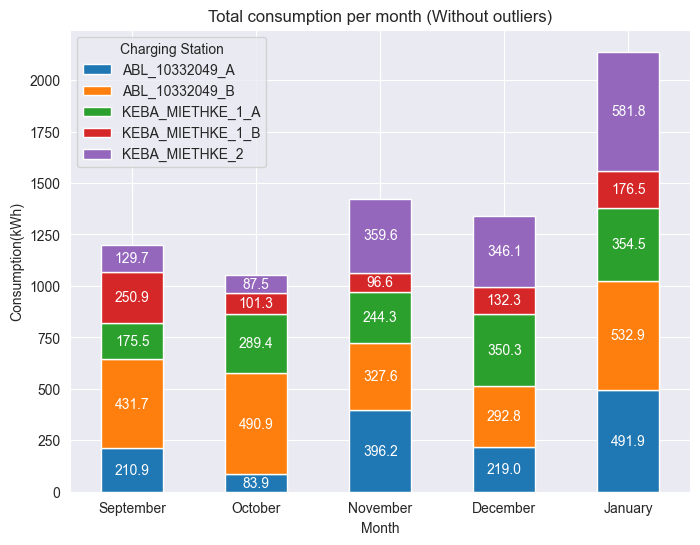

In [346]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
df = employee_data_concat.pivot_table(index='Plugged_in_month', columns='Charging Station', values='Consumption(kWh)', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=0)
#ax.set_figsize(12,8)
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Consumption(kWh)')
ax.set_xlabel('Month')
ax.set_title('Total consumption per month (Without outliers)')
plt.show()

In [342]:
# # Stack the consumption of each station per month
# x = (
#     so.Plot(employee_data_concat, x="Plugged_in_month", y='Consumption(kWh)', color="Charging Station")
#     .add(so.Bar(), so.Agg('sum'), so.Stack())
#     .label(y='Consumption(kWh)', x='Month', title='Total consumption per month (Without outliers)')
# )
# x.show()
# # Save figure
# #x.save('../Images/Employees/Redo/consumption-per-month-without-outlier')

In [344]:
# Consumption per month for corrected data (Without outliers)
employee_data_concat.groupby(['Plugged_in_month'])['Consumption(kWh)'].sum()

Plugged_in_month
September    1198.732000
October      1053.003333
November     1424.257514
December     1340.632200
January      2137.643807
Name: Consumption(kWh), dtype: float64

### Consumption per Charging Station

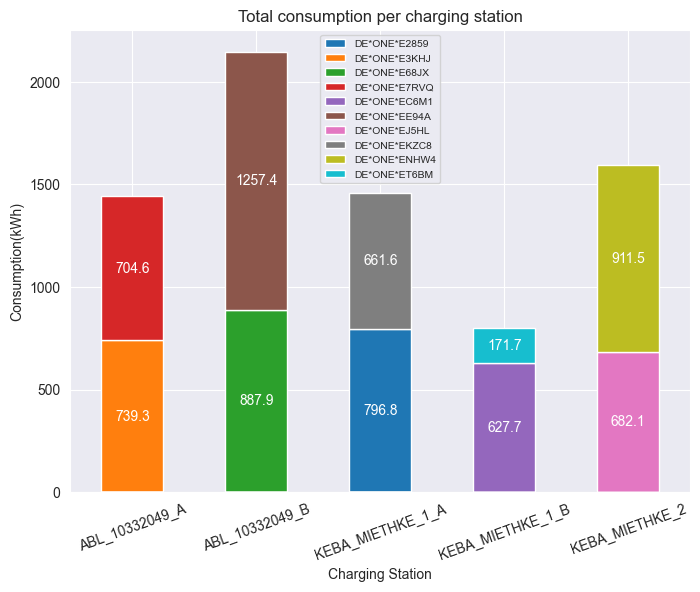

In [236]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
df = employee_data.pivot_table(index='Charging Station', columns='EVSE-ID', values='Consumption(kWh)', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)
#ax.set_figsize(12,8)
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Consumption(kWh)')
ax.set_xlabel('Charging Station')
ax.set_title('Total consumption per charging station')
ax.legend(loc='upper center', fontsize=7.5)
plt.show()

In [237]:
# # Stack the consumption of each charge points per station
# x = (
#     so.Plot(employee_data, x="Charging Station", y='Consumption(kWh)', color="EVSE-ID")
#     .add(so.Bar(), so.Agg('sum'), so.Stack())
#     .label(y='Consumption(kWh)', title='Total consumption per charge station')
# )
# x.layout(size=(10,6)).show()
# # Save figure
# #x.layout(size=(10,6)).save('../Images/Employees/Redo/consumption-per-charge-station')

#### Without outtliers

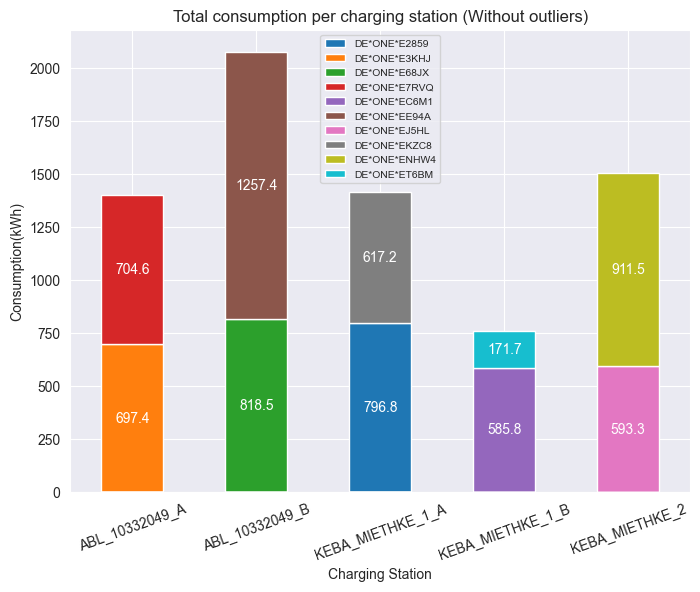

In [347]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
df = employee_data_concat.pivot_table(index='Charging Station', columns='EVSE-ID', values='Consumption(kWh)', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)
#ax.set_figsize(12,8)
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Consumption(kWh)')
ax.set_xlabel('Charging Station')
ax.set_title('Total consumption per charging station (Without outliers)')
ax.legend(loc='upper center', fontsize=7.5)
plt.show()

In [345]:
# # Stack the consumption of each charge points per station
# x = (
#     so.Plot(employee_data_concat, x="Charging Station", y='Consumption(kWh)', color="EVSE-ID")
#     .add(so.Bar(), so.Agg('sum'), so.Stack())
#     .label(y='Consumption(kWh)', title='Total consumption per charge station (Without outliers)')
# )
# x.layout(size=(10,6)).show()
# # Save figure
# #x.layout(size=(10,6)).save('../Images/Employees/Redo/consumption-per-charge-station-without-outlier')

### Consumption per charge point

Might not need it since it already shows in Consumption per charging station

In [239]:
# Consumption per charge points
employee_data.groupby(['Location', 'Charging Station', 'EVSE-ID'])['Consumption(kWh)'].sum()

Location                      Charging Station  EVSE-ID     
Fritz-von-der-Lancken-Straße  KEBA_MIETHKE_2    DE*ONE*EJ5HL     682.054
                                                DE*ONE*ENHW4     911.517
Ulanweg                       ABL_10332049_A    DE*ONE*E3KHJ     739.301
                                                DE*ONE*E7RVQ     704.635
                              ABL_10332049_B    DE*ONE*E68JX     887.947
                                                DE*ONE*EE94A    1257.396
                              KEBA_MIETHKE_1_A  DE*ONE*E2859     796.810
                                                DE*ONE*EKZC8     661.597
                              KEBA_MIETHKE_1_B  DE*ONE*EC6M1     627.719
                                                DE*ONE*ET6BM     171.733
Name: Consumption(kWh), dtype: float64

In [348]:
# Consumption per charge points for corrected data (Without outliers)
employee_data_concat.groupby(['Location', 'Charging Station', 'EVSE-ID'])['Consumption(kWh)'].sum()

Location                      Charging Station  EVSE-ID     
Fritz-von-der-Lancken-Straße  KEBA_MIETHKE_2    DE*ONE*EJ5HL     593.270933
                                                DE*ONE*ENHW4     911.517000
Ulanweg                       ABL_10332049_A    DE*ONE*E3KHJ     697.365757
                                                DE*ONE*E7RVQ     704.635000
                              ABL_10332049_B    DE*ONE*E68JX     818.470807
                                                DE*ONE*EE94A    1257.396000
                              KEBA_MIETHKE_1_A  DE*ONE*E2859     796.810000
                                                DE*ONE*EKZC8     617.221600
                              KEBA_MIETHKE_1_B  DE*ONE*EC6M1     585.848757
                                                DE*ONE*ET6BM     171.733000
Name: Consumption(kWh), dtype: float64

In [349]:
# ax = sns.barplot(
#     data=employee_data_concat,
#     x='Consumption(kWh)',
#     y='EVSE-ID',
#     ci=None,
#     estimator='sum'
# )
# ax.bar_label(ax.containers[0])
# plt.xlabel('Consumption(kWh)')
# plt.ylabel('EVSE-ID')
# plt.title('Consumption per charge point (Without outliers)')

# # Save figure
# #plt.savefig('../Images/Employees/Redo/consumption-per-charge-point-without-outliers', bbox_inches='tight')
# plt.show()

### Connection time per charge station

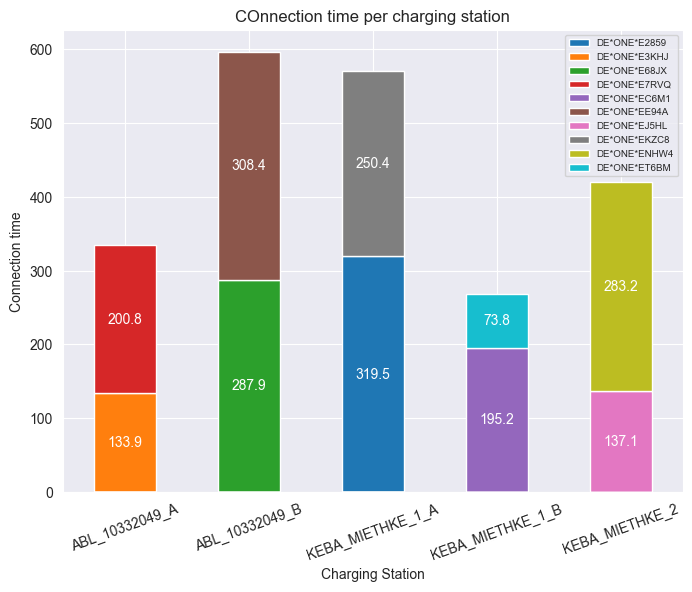

In [249]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
df = employee_data.pivot_table(index='Charging Station', columns='EVSE-ID', values='Blocking Time', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)
#ax.set_figsize(12,8)
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Connection time')
ax.set_xlabel('Charging Station')
ax.set_title('COnnection time per charging station')
ax.legend(loc='upper right', fontsize=7)
plt.show()

In [245]:
# ax = sns.barplot(
#     employee_data,
#     x='Blocking Time',
#     y='EVSE-ID',
#     ci=None,
#     estimator='sum'
# )

# ax.bar_label(ax.containers[0])
# plt.title('Total connection time per charge point')
# plt.ylabel('EVSE-ID')
# plt.xlabel('Connection time')

# #plt.savefig('../Images/Employees/Redo/connection-time-per-charge-point', bbox_inches='tight')
# plt.show()

In [246]:
employee_data.groupby(['Location', 'Charging Station', 'EVSE-ID'])['Blocking Time'].sum()

Location                      Charging Station  EVSE-ID     
Fritz-von-der-Lancken-Straße  KEBA_MIETHKE_2    DE*ONE*EJ5HL    137.113056
                                                DE*ONE*ENHW4    283.156389
Ulanweg                       ABL_10332049_A    DE*ONE*E3KHJ    133.898889
                                                DE*ONE*E7RVQ    200.776667
                              ABL_10332049_B    DE*ONE*E68JX    287.868889
                                                DE*ONE*EE94A    308.431667
                              KEBA_MIETHKE_1_A  DE*ONE*E2859    319.534722
                                                DE*ONE*EKZC8    250.439444
                              KEBA_MIETHKE_1_B  DE*ONE*EC6M1    195.190556
                                                DE*ONE*ET6BM     73.768889
Name: Blocking Time, dtype: float64

In [94]:
employee_data.groupby(['Location', 'Charging Station'])['Blocking Time'].sum()

Location                      Charging Station
Fritz-von-der-Lancken-Straße  KEBA_MIETHKE_2      420.269444
Ulanweg                       ABL_10332049_A      334.675556
                              ABL_10332049_B      596.300556
                              KEBA_MIETHKE_1_A    569.974167
                              KEBA_MIETHKE_1_B    268.959444
Name: Blocking Time, dtype: float64

#### Without outliers

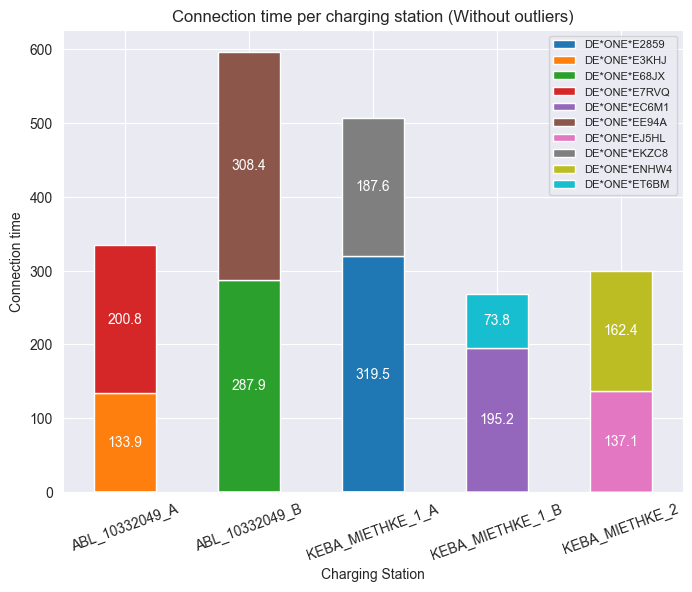

In [353]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
df = employee_data_concat.pivot_table(index='Charging Station', columns='EVSE-ID', values='Blocking Time', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)
#ax.set_figsize(12,8)
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Connection time')
ax.set_xlabel('Charging Station')
ax.set_title('Connection time per charging station (Without outliers)')
ax.legend(loc='upper right', fontsize=8)
plt.show()

In [350]:
# ax = sns.barplot(
#     employee_data_concat,
#     x='Blocking Time',
#     y='EVSE-ID',
#     ci=None,
#     estimator='sum'
# )

# ax.bar_label(ax.containers[0])
# plt.title('Total connection time per charge point')
# plt.ylabel('EVSE-ID')
# plt.xlabel('Connection time')

# #plt.savefig('../Images/Employees/Redo/connection-time-per-charge-point', bbox_inches='tight')
# plt.show()

In [314]:
employee_data.groupby(['Location', 'Charging Station', 'EVSE-ID'])['Blocking Time'].sum()

Location                      Charging Station  EVSE-ID     
Fritz-von-der-Lancken-Straße  KEBA_MIETHKE_2    DE*ONE*EJ5HL    137.113056
                                                DE*ONE*ENHW4    283.156389
Ulanweg                       ABL_10332049_A    DE*ONE*E3KHJ    133.898889
                                                DE*ONE*E7RVQ    200.776667
                              ABL_10332049_B    DE*ONE*E68JX    287.868889
                                                DE*ONE*EE94A    308.431667
                              KEBA_MIETHKE_1_A  DE*ONE*E2859    319.534722
                                                DE*ONE*EKZC8    250.439444
                              KEBA_MIETHKE_1_B  DE*ONE*EC6M1    195.190556
                                                DE*ONE*ET6BM     73.768889
Name: Blocking Time, dtype: float64

### Charge time per charge station

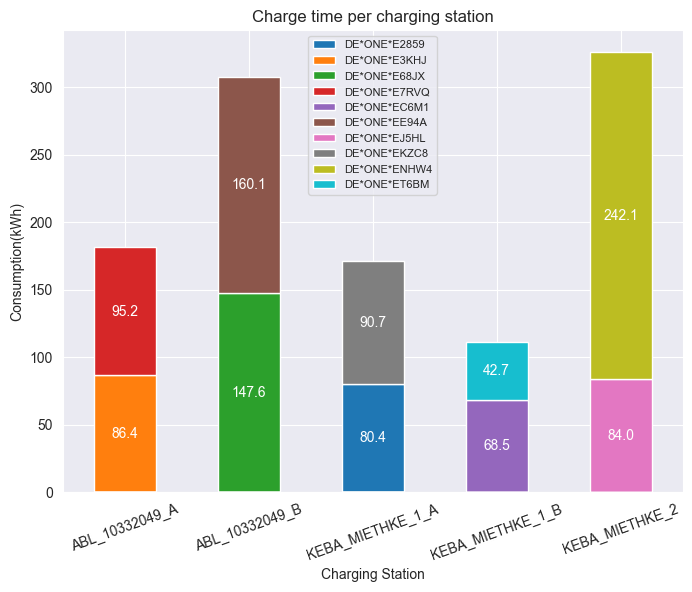

In [250]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
df = employee_data.pivot_table(index='Charging Station', columns='EVSE-ID', values='Charging Duration', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)
#ax.set_figsize(12,8)
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Consumption(kWh)')
ax.set_xlabel('Charging Station')
ax.set_title('Charge time per charging station')
ax.legend(loc='upper center', fontsize=8)
plt.show()

In [251]:
# ax = sns.barplot(
#     employee_data,
#     x='Charging Duration',
#     y='EVSE-ID',
#     ci=None,
#     estimator='sum'
# )

# ax.bar_label(ax.containers[0])
# plt.title('Total charge duration per charge point')
# plt.ylabel('EVSE-ID')
# plt.xlabel('Charge time')

# #plt.savefig('../Images/Employees/Redo/charge-time-per-charge-point', bbox_inches='tight')
# plt.show()

#### Without outliers

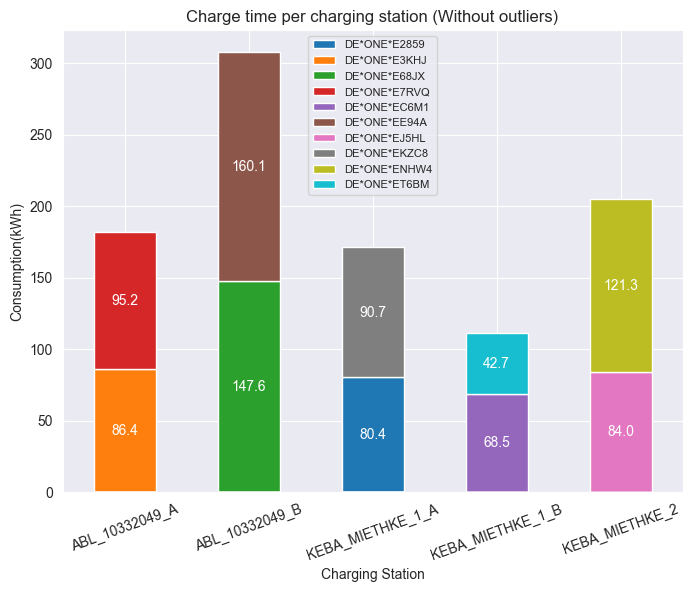

In [356]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
df = employee_data_concat.pivot_table(index='Charging Station', columns='EVSE-ID', values='Charging Duration', aggfunc='sum')
ax = df.plot.bar(stacked=True, ax=ax, rot=20)
#ax.set_figsize(12,8)
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center', color='white')
ax.set_ylabel('Consumption(kWh)')
ax.set_xlabel('Charging Station')
ax.set_title('Charge time per charging station (Without outliers)')
ax.legend(loc='upper center', fontsize=8)
plt.show()

In [354]:
# ax = sns.barplot(
#     employee_data_concat,
#     x='Charging Duration',
#     y='EVSE-ID',
#     ci=None,
#     estimator='sum'
# )

# ax.bar_label(ax.containers[0])
# plt.title('Total charge Duration per charge point')
# plt.ylabel('EVSE-ID')
# plt.xlabel('Charge time')

# #plt.savefig('../Images/Employees/Redo/charge-time-per-charge-point', bbox_inches='tight')
# plt.show()

### Capacity utilization

In [252]:
# Create a pivot table that contains the total connection time in each month in the charge stations
employee_data_blocking_time_sum = pd.pivot_table(employee_data, values='Blocking Time', columns=['Plugged_in_month'], index=['Charging Station'], aggfunc="sum")

In [147]:
#employee_data_blocking_time_sum

In [253]:
# Convert the pivot table to a long format
employee_data_blocking_time_month = pd.melt(
    employee_data_blocking_time_sum.reset_index(),
    id_vars=['Charging Station'],
    value_vars=['September', 'October', 'November', 'December', 'January'],
    var_name = 'Month',
    value_name = 'Blocking Time'
)

In [254]:
# Create a function that calculates capacity utilization for each month
def capacity_util(df):
    #months = df['Month'].values
    if df['Month'] == 9:
        capacity = (df['Blocking Time'] / 504) * 100
    elif df['Month'] == 10:
        capacity = (df['Blocking Time'] / 480) * 100
    elif df['Month'] == 11:
        capacity = (df['Blocking Time'] / 528) * 100
    elif df['Month'] == 12:
        capacity = (df['Blocking Time'] / 408) * 100
    else:
        capacity = (df['Blocking Time'] / 552) * 100
    return capacity

In [255]:
# Create the capacity utilization column
employee_data_blocking_time_month['Capacity utilization'] = employee_data_blocking_time_month.apply(capacity_util, axis=1)

In [256]:
# Convert the months to a categorical variable in order to sort it
employee_data_blocking_time_month['Month'] = pd.Categorical(
    employee_data_blocking_time_month['Month'],
    categories=['September', 'October', 'November', 'December', 'January']
)

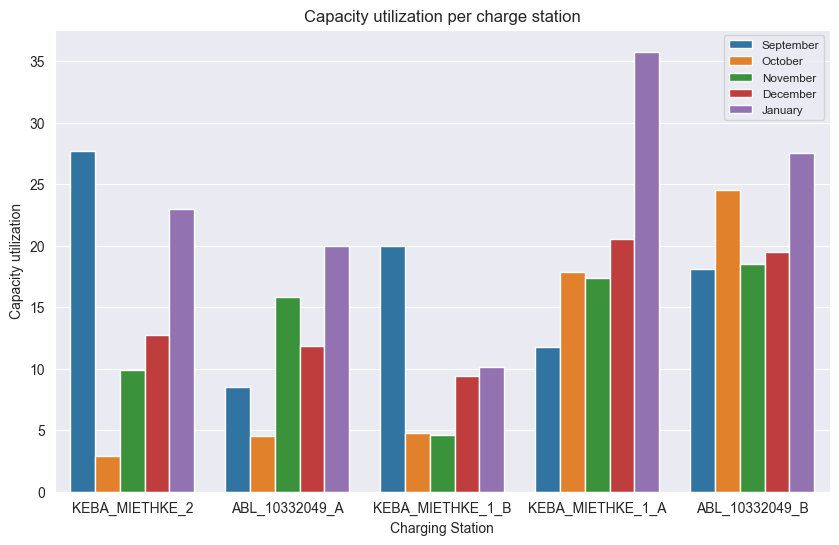

In [257]:
# Create a barplot of the capacity utilization of each month in each charge station
plt.figure(figsize=(10,6))
sns.barplot(
    data=employee_data_blocking_time_month.sort_values('Capacity utilization'),
    x='Charging Station',
    y='Capacity utilization',
    hue='Month'
)
plt.title('Capacity utilization per charge station')
#plt.xticks(rotation=15)
#plt.legend([9, 10, 11, 12, 1], labels=['September', 'October', 'November', 'December', 'January'])
plt.legend(fontsize=8.5)

# Save figure
#plt.savefig('../Images/Employees/Redo/capacity-utilization-per-charge-station')
plt.show()

In [258]:
employee_data_blocking_time_month.groupby('Charging Station')['Capacity utilization'].mean()

Charging Station
ABL_10332049_A      12.125926
ABL_10332049_B      21.605093
KEBA_MIETHKE_1_A    20.651238
KEBA_MIETHKE_1_B     9.744907
KEBA_MIETHKE_2      15.227154
Name: Capacity utilization, dtype: float64

#### Without outliers

In [357]:
# Create a pivot table that contains the total connection time in each month in the charge stations
employee_data_concat_blocking_time_sum = pd.pivot_table(employee_data_concat, values='Blocking Time', columns=['Plugged_in_month'], index=['Charging Station'], aggfunc="sum")

In [358]:
# Convert the pivot table to a long format
employee_data_concat_blocking_time_month = pd.melt(
    employee_data_concat_blocking_time_sum.reset_index(),
    id_vars=['Charging Station'],
    value_vars=['September', 'October', 'November', 'December', 'January'],
    var_name = 'Month',
    value_name = 'Blocking Time'
)

In [359]:
# Create the capacity utilization column
employee_data_concat_blocking_time_month['Capacity utilization'] = employee_data_concat_blocking_time_month.apply(capacity_util, axis=1)

In [360]:
# Convert the months to a categorical variable in order to sort it
employee_data_concat_blocking_time_month['Month'] = pd.Categorical(
    employee_data_concat_blocking_time_month['Month'],
    categories=['September', 'October', 'November', 'December', 'January']
)

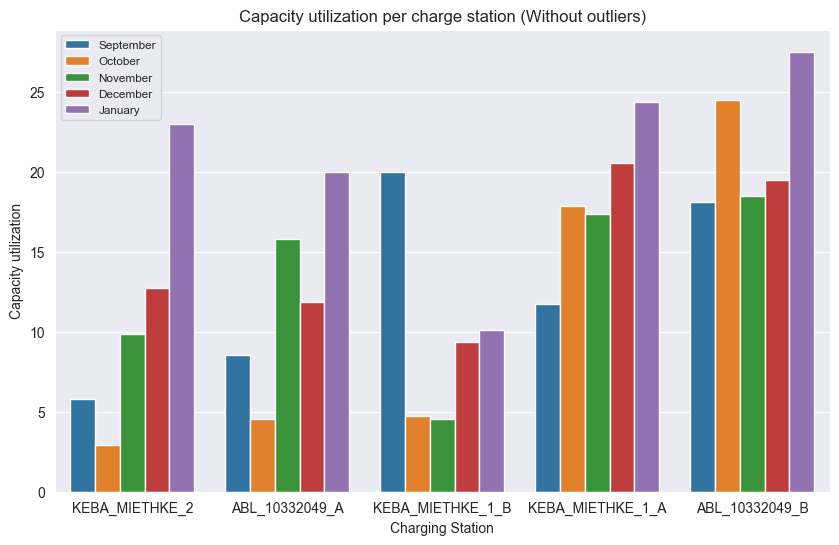

In [361]:
# Create a barplot of the capacity utilization of each month in each charge station
plt.figure(figsize=(10,6))
sns.barplot(
    data=employee_data_concat_blocking_time_month.sort_values('Capacity utilization'),
    x='Charging Station',
    y='Capacity utilization',
    hue='Month'
)
plt.title('Capacity utilization per charge station (Without outliers)')
#plt.xticks(rotation=15)
#plt.legend([9, 10, 11, 12, 1], labels=['September', 'October', 'November', 'December', 'January'])
plt.legend(fontsize=8.5)

# Save figure
#plt.savefig('../Images/Employees/Redo/capacity-utilization-per-charge-station-without-outlier')
plt.show()

In [362]:
employee_data_concat_blocking_time_month.groupby('Charging Station')['Capacity utilization'].mean()

Charging Station
ABL_10332049_A      12.125926
ABL_10332049_B      21.605093
KEBA_MIETHKE_1_A    18.372685
KEBA_MIETHKE_1_B     9.744907
KEBA_MIETHKE_2      10.851194
Name: Capacity utilization, dtype: float64

### Daytime users Blocking time

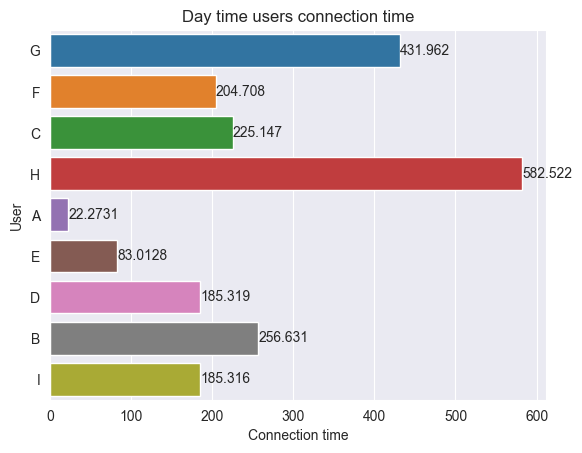

In [260]:
ax = sns.barplot(
    data=employee_data_daytime,
    y='User',
    x='Blocking Time',
    estimator='sum',
    ci=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Connection time')
plt.title('Day time users connection time')

# Save figure
#plt.savefig('../Images/Employees/Redo/day-time-users-connection-time', bbox_inches='tight')
plt.show()

### Daytime users Charge time

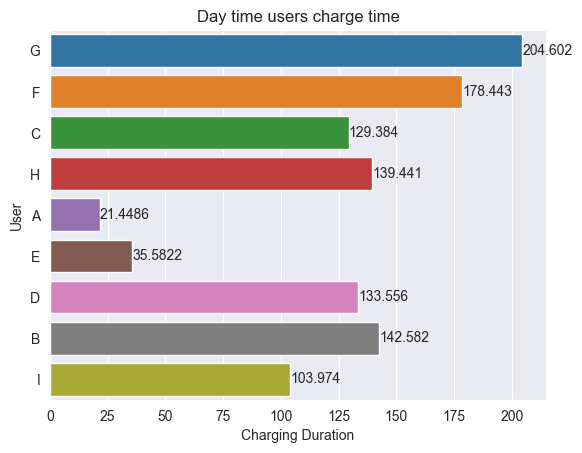

In [261]:
ax = sns.barplot(
    data=employee_data_daytime,
    y='User',
    x='Charging Duration',
    estimator='sum',
    ci=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Charging Duration')
plt.title('Day time users charge time')

# Save figure
#plt.savefig('../Images/Employees/Redo/day-time-users-charge-time', bbox_inches='tight')
plt.show()

### Nightime users Blocking time

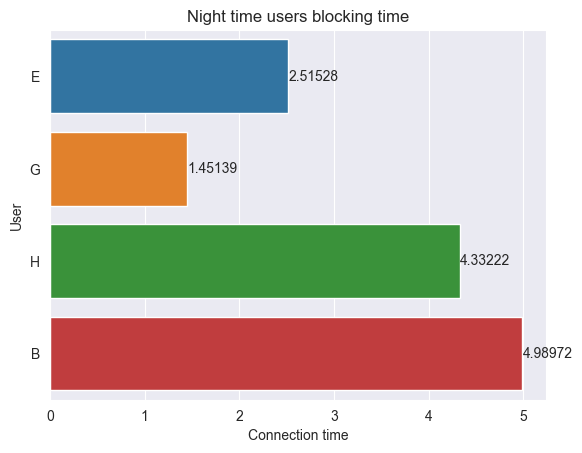

In [263]:
ax = sns.barplot(
    data=employee_data_nighttime,
    y='User',
    x='Blocking Time',
    estimator='sum',
    ci=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Connection time')
plt.title('Night time users blocking time')

# Save figure
#plt.savefig('../Images/Employees/Redo/night-time-users-connection-time', bbox_inches='tight')
plt.show()

### Nightime users Charge time

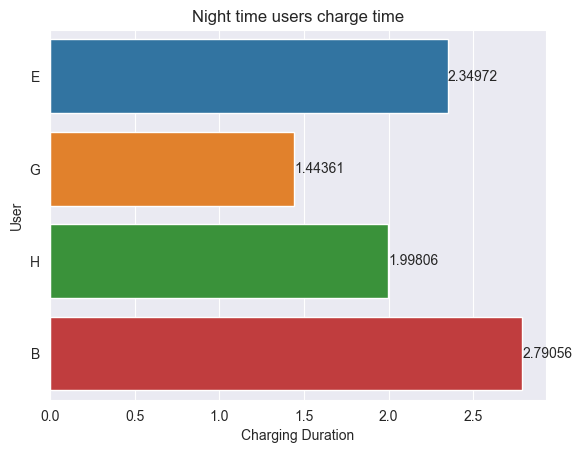

In [264]:
ax = sns.barplot(
    data=employee_data_nighttime,
    y='User',
    x='Charging Duration',
    estimator='sum',
    ci=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Night time users charge time')

# Save figure
#plt.savefig('../Images/Employees/Redo/night-time-users-charge-time', bbox_inches='tight')
plt.show()

### Hogging time of daytime users

In [275]:
employee_data_daytime_hogging_user = employee_data_daytime.groupby('User')['Hogging time'].sum().reset_index()

In [270]:
employee_data_daytime_hogging_user['Percentage'] = (employee_data_daytime_hogging_user['Hogging time'] / employee_data_daytime_hogging_user['Hogging time'].sum()) * 100

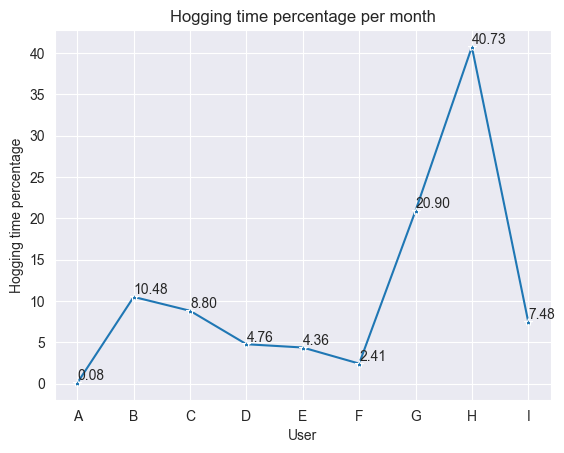

In [271]:
ax = sns.lineplot(
    data=employee_data_daytime_hogging_user,
    x='User',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*'
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
for i, (x_val, y_val) in enumerate(zip(employee_data_daytime_hogging_user['User'], employee_data_daytime_hogging_user['Percentage'])):
    plt.text(i, y_val, f'{y_val:.2f}', ha='left', va='bottom')
plt.xlabel('User')
plt.ylabel('Hogging time percentage')
plt.title('Hogging time percentage per month')

# Save figure
#plt.savefig('../Images/Employees/Redo/hogging-time-percentage-per-month', bbox_inches='tight')
plt.show()

### Hogging time of nighttime users

In [279]:
employee_data_nighttime_hogging_user = employee_data_nighttime.groupby('User')['Hogging time'].sum().reset_index()

In [280]:
employee_data_nighttime_hogging_user['Percentage'] = (employee_data_nighttime_hogging_user['Hogging time'] / employee_data_nighttime_hogging_user['Hogging time'].sum()) * 100

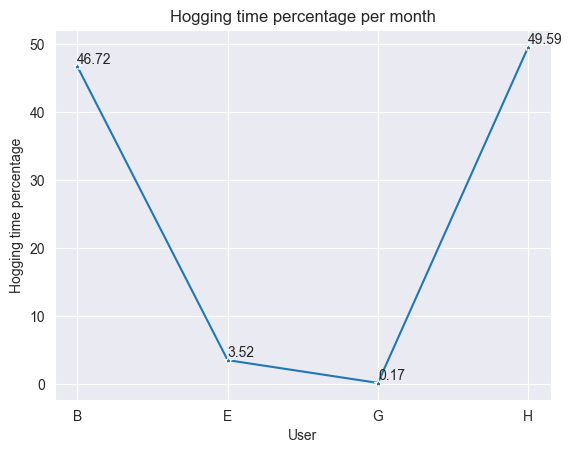

In [281]:
ax = sns.lineplot(
    data=employee_data_nighttime_hogging_user,
    x='User',
    y='Percentage',
    estimator='sum',
    ci=None,
    marker='*'
)
#ax.bar_label(ax.containers[0], fontsize=8.5)
for i, (x_val, y_val) in enumerate(zip(employee_data_nighttime_hogging_user['User'], employee_data_nighttime_hogging_user['Percentage'])):
    plt.text(i, y_val, f'{y_val:.2f}', ha='left', va='bottom')
plt.xlabel('User')
plt.ylabel('Hogging time percentage')
plt.title('Hogging time percentage per month')

# Save figure
#plt.savefig('../Images/Employees/Redo/hogging-time-percentage-per-month', bbox_inches='tight')
plt.show()

### Daytime and nighttime consumption

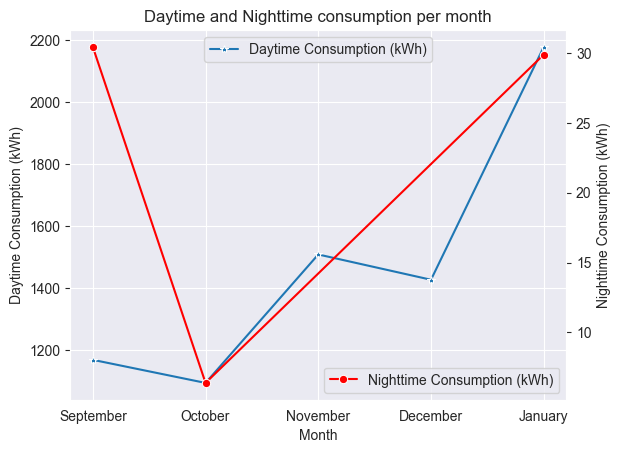

In [282]:
fig, ax = plt.subplots()

sns.lineplot(
    data=employee_data_daytime,
    x='Plugged_in_month',
    y='Consumption(kWh)',
    ax=ax,
    estimator='sum',
    ci=None,
    label='Daytime Consumption (kWh)',
    marker='*'
)
#ax.tick_params(axis='y', labelcolor='blue')
ax.set_xlabel('Month')
ax.set_ylabel('Daytime Consumption (kWh)')
ax.legend(loc='upper center')

ax2 = ax.twinx()
ax2.grid(False)

sns.lineplot(
    data=employee_data_nighttime,
    x='Plugged_in_month',
    y='Consumption(kWh)',
    ax=ax2,
    estimator='sum',
    ci=None,
    color='red',
    label='Nighttime Consumption (kWh)',
    marker='o'
)
#plt.xticks([9, 10, 11, 12, 1], labels=['September', 'October', 'November', 'December', 'January'])
#ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('Nighttime Consumption (kWh)')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines + lines2, labels + labels2)
plt.title('Daytime and Nighttime consumption per month')

# Save figure
#plt.savefig('../Images/Employees/Redo/daytime-nighttime-consumption-per-month')
plt.show()

#### Without outliers

In [363]:
# Extract daytime data
employee_data_concat_daytime = employee_data_concat.set_index('Plugged in at').between_time('6:00', '18:00').reset_index()

# Extract nighttime data
employee_data_concat_nighttime = employee_data_concat.set_index('Plugged in at').between_time('18:01', '5:59').reset_index()

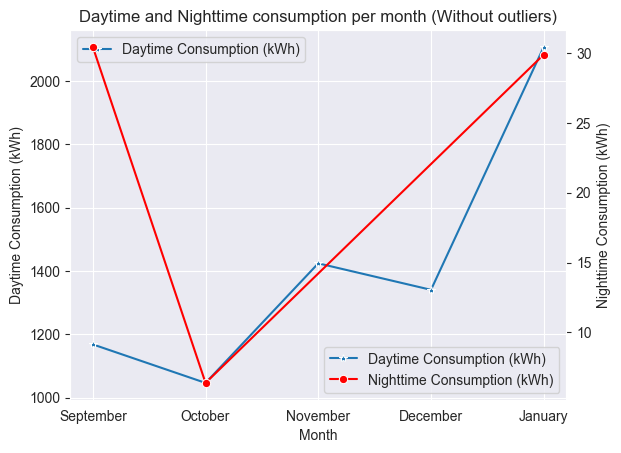

In [364]:
fig, ax = plt.subplots()

sns.lineplot(
    data=employee_data_concat_daytime,
    x='Plugged_in_month',
    y='Consumption(kWh)',
    ax=ax,
    estimator='sum',
    ci=None,
    label='Daytime Consumption (kWh)',
    marker='*'
)
#ax.tick_params(axis='y', labelcolor='blue')
ax.set_xlabel('Month')
ax.set_ylabel('Daytime Consumption (kWh)')

ax2 = ax.twinx()
ax2.grid(False)

sns.lineplot(
    data=employee_data_concat_nighttime,
    x='Plugged_in_month',
    y='Consumption(kWh)',
    ax=ax2,
    estimator='sum',
    ci=None,
    color='red',
    label='Nighttime Consumption (kWh)',
    marker='o'
)
#plt.xticks([9, 10, 11, 12, 1], labels=['September', 'October', 'November', 'December', 'January'])
#ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('Nighttime Consumption (kWh)')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)
plt.title('Daytime and Nighttime consumption per month (Without outliers)')

# Save figure
#plt.savefig('../Images/Employees/Redo/daytime-nighttime-consumption-per-month-without-outlier')
plt.show()

In [365]:
# Check the consumption per month during daytime and nighttime

#employee_data_concat_daytime.groupby('Plugged_in_month')['Verbrauch (kWh)'].sum()
employee_data_concat_nighttime.groupby('Plugged_in_month')['Consumption(kWh)'].sum()

Plugged_in_month
September    30.425
October       6.393
November      0.000
December      0.000
January      29.876
Name: Consumption(kWh), dtype: float64

### Charge sessions per month

In [283]:
monthly_charge_time = employee_data.groupby('Plugged_in_month')['Charging Duration'].count().reset_index()

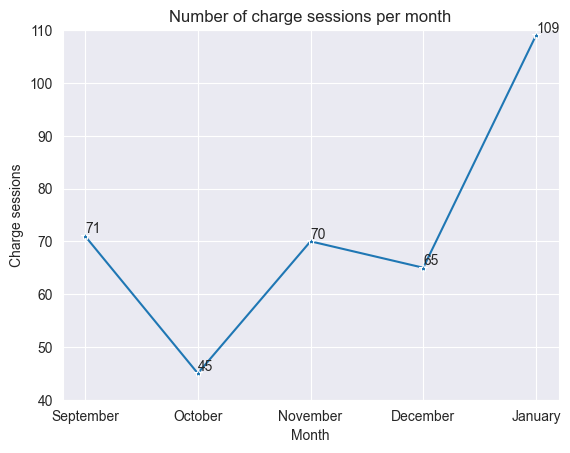

In [284]:
sns.lineplot(
    monthly_charge_time,
    x='Plugged_in_month',
    y='Charging Duration',
    ci=None,
    marker='*'
)
plt.ylim((40, 110))
plt.xlabel('Month')
plt.ylabel('Charge sessions')
plt.title('Number of charge sessions per month')

for i, (x_val, y_val) in enumerate(zip(monthly_charge_time['Plugged_in_month'], monthly_charge_time['Charging Duration'])):
    plt.text(i, y_val, f'{y_val:.0f}', ha='left', va='bottom')

# Save figure
#plt.savefig('../Images/Employees/Redo/charge-sessions-per-month')
plt.show()

### Charge sessions per station

In [285]:
station_charge_time = employee_data.groupby('Charging Station')['Charging Duration'].count().reset_index()

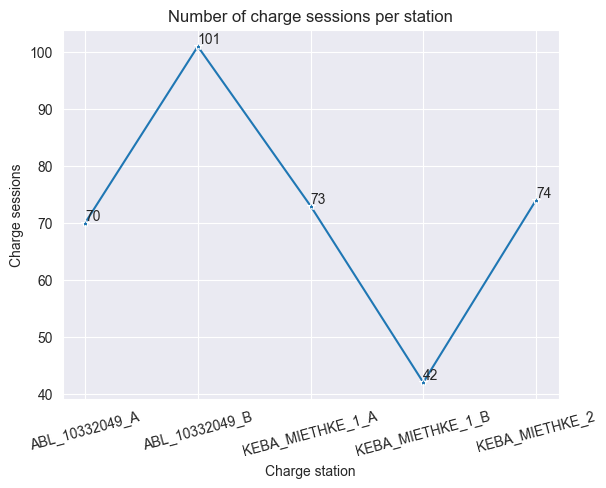

In [286]:
sns.lineplot(
    station_charge_time,
    x='Charging Station',
    y='Charging Duration',
    ci=None,
    marker='*'
)
plt.xlabel('Charge station')
plt.ylabel('Charge sessions')
plt.xticks(rotation=15)
plt.title('Number of charge sessions per station')

# Display the numbers
for i, (x_val, y_val) in enumerate(zip(station_charge_time['Charging Station'], station_charge_time['Charging Duration'])):
    plt.text(i, y_val, f'{y_val:.0f}', ha='left', va='bottom')

# Save figure
#plt.savefig('../Images/Employees/Redo/charge-sessions-per-station')
plt.show()

### Consumption per session per month

In [287]:
# Calculate consumption per session
amount_of_consumption = employee_data.groupby('Plugged_in_month')['Consumption(kWh)'].sum()
num_of_sessions = employee_data.groupby('Plugged_in_month')['Charging Duration'].count()

employee_data_kwh_per_session = (amount_of_consumption / num_of_sessions).reset_index()

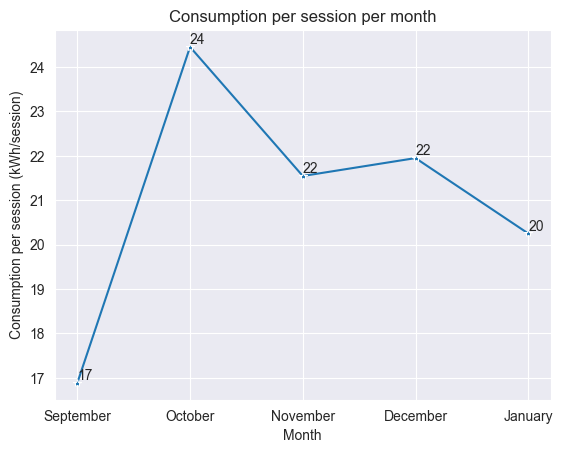

In [288]:
sns.lineplot(
    data=employee_data_kwh_per_session,
    x='Plugged_in_month',
    y=0,
    marker='*'
)
plt.xlabel('Month')
plt.ylabel('Consumption per session (kWh/session)')
plt.title('Consumption per session per month')

# Display the numbers
for i, (x_val, y_val) in enumerate(zip(employee_data_kwh_per_session['Plugged_in_month'], employee_data_kwh_per_session[0])):
    plt.text(i, y_val, f'{y_val:.0f}', ha='left', va='bottom')

# Save figure
#plt.savefig('../Images/Employees/Redo/consumption-per-session-per-month')
plt.show()

In [289]:
employee_data_kwh_per_session[0].mean()

21.014609422282934

### Median energy consumption for each day in each month

In [290]:
# Create a pivot table that contains the total median consumption for each day in each month
median_energy = pd.pivot_table(employee_data, values='Consumption(kWh)', columns=['Plugged_in_dayname'], index=['Plugged_in_month'], aggfunc="median")
median_energy

Plugged_in_dayname   Monday  Tuesday  Wednesday  Thursday   Friday  Saturday
Plugged_in_month                                                            
September           22.4110  11.3080    11.2800    11.961  11.2080       NaN
October             40.8260  18.1150    22.2630    12.360  30.2540     1.077
November            23.1115  15.6400    14.7910    14.133  17.2455       NaN
December            21.2850  21.0110    16.2290    22.917  21.3270     7.239
January             17.6045  21.5595    21.9175    10.883  15.6500    20.367

### Mean energy consumption for each day in each month

In [366]:
# Create a pivot table that contains the mean consumption for each day in each month in the corrected data
mean_energy = pd.pivot_table(employee_data_concat, values='Consumption(kWh)', columns=['Plugged_in_dayname'], index=['Plugged_in_month'], aggfunc="mean")
mean_energy

Plugged_in_dayname     Monday    Tuesday  Wednesday   Thursday     Friday  \
Plugged_in_month                                                            
September           24.343500  16.892214  14.685067  17.278615  13.248294   
October             35.425542  20.507429  23.188500  12.739455  29.932800   
November            24.224485  19.113981  17.788250  18.615692  21.797333   
December            19.669923  20.610556  15.271383  23.719733  23.593095   
January             17.803800  23.931818  22.758909  14.745789  18.105172   

Plugged_in_dayname  Saturday  
Plugged_in_month              
September                NaN  
October                1.077  
November                 NaN  
December               7.239  
January               20.367

### Median connection time for each day in each month

In [291]:
# Create a pivot table that contains the median connection time for each day in each month
median_connection_time = pd.pivot_table(employee_data, values='Blocking Time', columns=['Plugged_in_dayname'], index=['Plugged_in_month'], aggfunc="median")
median_connection_time

Plugged_in_dayname    Monday   Tuesday  Wednesday  Thursday    Friday  \
Plugged_in_month                                                        
September           7.635833  5.723194   3.108333  8.067500  3.569722   
October             7.387222  4.476389   8.796528  7.597500  7.880972   
November            6.599444  3.744722   6.710694  6.062500  3.556389   
December            3.178056  7.056389   3.078889  9.342500  6.344444   
January             4.695139  7.445833   5.129444  5.140556  3.978333   

Plugged_in_dayname  Saturday  
Plugged_in_month              
September                NaN  
October             0.325556  
November                 NaN  
December            0.704722  
January             2.173333

### Mean connection time for each day in each month

In [367]:
# Create a pivot table that contains the mean connection time for each day in each month in the corrected data
mean_connection_time = pd.pivot_table(employee_data_concat, values='Blocking Time', columns=['Plugged_in_dayname'], index=['Plugged_in_month'], aggfunc="mean")
mean_connection_time

Plugged_in_dayname    Monday   Tuesday  Wednesday  Thursday    Friday  \
Plugged_in_month                                                        
September           5.932315  6.635595   3.271574  5.914565  3.767908   
October             7.333646  5.693651   6.880660  6.550606  7.510944   
November            5.923056  4.884872   5.117778  5.406987  4.496806   
December            4.875577  6.652469   4.045694  8.291636  7.653942   
January             5.323941  6.580013   5.194621  5.386944  4.493956   

Plugged_in_dayname  Saturday  
Plugged_in_month              
September                NaN  
October             0.325556  
November                 NaN  
December            0.704722  
January             2.173333

### Average connection and charge time per month

In [292]:
# Create a pivot table that contains the median connection time for each day in each month
avg_connection_time = pd.pivot_table(employee_data, values=['Blocking Time', 'Charging Duration'], index=['Plugged_in_month'], aggfunc="mean")
avg_connection_time

Blocking Time  Charging Duration
Plugged_in_month                                  
September              6.688451           4.083228
October                6.690259           2.816259
November               5.205845           2.693742
December               6.274850           3.024389
January                5.889569           2.713830

#### Without outliers

In [368]:
# Create a pivot table that contains the median connection time for each day in each month in the corrected data
avg_connection_time = pd.pivot_table(employee_data_concat, values=['Blocking Time', 'Charging Duration'], index=['Plugged_in_month'], aggfunc="mean")
avg_connection_time

Blocking Time  Charging Duration
Plugged_in_month                                  
September              4.987373           2.382097
October                6.690259           2.816259
November               5.205845           2.693742
December               6.274850           3.024389
January                5.312615           2.713830

## PREDICTIVE ANALYSIS FOR EMPLOYEE

In [293]:
employee_data_copy = employee_data.copy()

In [294]:
employee_data_copy.set_index('Unplugged at', inplace=True)

In [295]:
train = employee_data_copy[employee_data_copy.index <= pd.to_datetime("2023-12-31 23:59:59", format='%Y-%m-%d %H:%M:%S')]
test = employee_data_copy[employee_data_copy.index >= pd.to_datetime("2024-01-01 00:00:00", format='%Y-%m-%d %H:%M:%S')]

### Consumption

In [299]:
# Extract relevant columns and set 'Plugged in at' as the index
consumption_data_train = train[['Plugged in at', 'Consumption(kWh)']]
consumption_data_train.set_index('Plugged in at', inplace=True)

#ARIMAmodel = ARIMA(y_train, order=(1,1,1))
ARIMAmodel = ARIMA(consumption_data_train, order=(5,1,2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.forecast(len(test))
#res = pd.DataFrame(y_pred, index=X_test.index)

pred_df = pd.DataFrame(y_pred)
pred_df = pred_df.set_index(test.index)

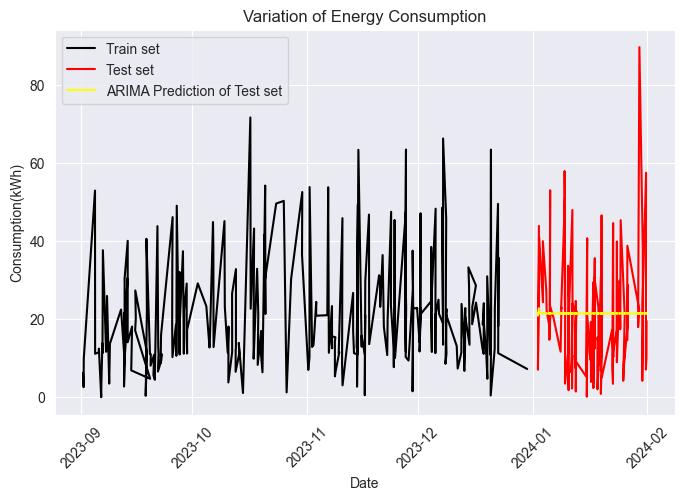

In [300]:
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Consumption(kWh)'], color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(test.index, test['Consumption(kWh)'], color='red', label='Test set')
plt.plot(pred_df, color='Yellow', label='ARIMA Prediction of Test set')
plt.xlabel('Date')
plt.ylabel('Consumption(kWh)')
plt.title('Variation of Energy Consumption')
plt.legend()
plt.show()

In [301]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['Consumption(kWh)'], y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 227.7466179123092
Root Mean Squared Error (RMSE): 15.091276218806321


In [302]:
print(f"The actual january consumption is {test['Consumption(kWh)'].sum()} kWh and the predicted january consumption is {pred_df['predicted_mean'].sum()} kWh")

The actual january consumption is 2207.12 kWh and the predicted january consumption is 2342.384749738668 kWh


### Predict Consumption for the next 12 months

In [303]:
# Forecast future values for each month from Feb to Dec 2024
forecast_steps_per_month = [29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31]  # Days in each month
forecast_values = []

for steps in forecast_steps_per_month:
    forecast_month = ARIMAmodel.get_forecast(steps=steps)
    forecast_values.extend(forecast_month.predicted_mean.tolist())

# Create a DataFrame with timestamp and forecasted values
forecast_dates = pd.date_range(start='2024-02-01', periods=len(forecast_values), freq='D')
forecast_df = pd.DataFrame({'Plugged in at': forecast_dates, 'Predicted Consumption(KWh)': forecast_values})

# Print the forecasted values
print(forecast_df)

    Plugged in at  Predicted Consumption(KWh)
0      2024-02-01                   22.798863
1      2024-02-02                   20.924438
2      2024-02-03                   21.759232
3      2024-02-04                   21.649503
4      2024-02-05                   21.561972
..            ...                         ...
361    2025-01-27                   21.479007
362    2025-01-28                   21.477785
363    2025-01-29                   21.478749
364    2025-01-30                   21.477988
365    2025-01-31                   21.478589

[366 rows x 2 columns]


In [304]:
# Group the forecasted DataFrame by month and sum the values
forecast_df['Month'] = forecast_df['Plugged in at'].dt.to_period('M')
monthly_sum_forecast = forecast_df.groupby('Month')['Predicted Consumption(KWh)'].sum()

# Print the monthly sum forecast
print(monthly_sum_forecast)

Month
2024-02    624.119014
2024-03    667.075591
2024-04    645.597002
2024-05    667.075591
2024-06    645.597002
2024-07    667.075591
2024-08    667.075591
2024-09    645.597002
2024-10    667.075591
2024-11    645.597002
2024-12    667.075591
2025-01    667.075591
Freq: M, Name: Predicted Consumption(KWh), dtype: float64


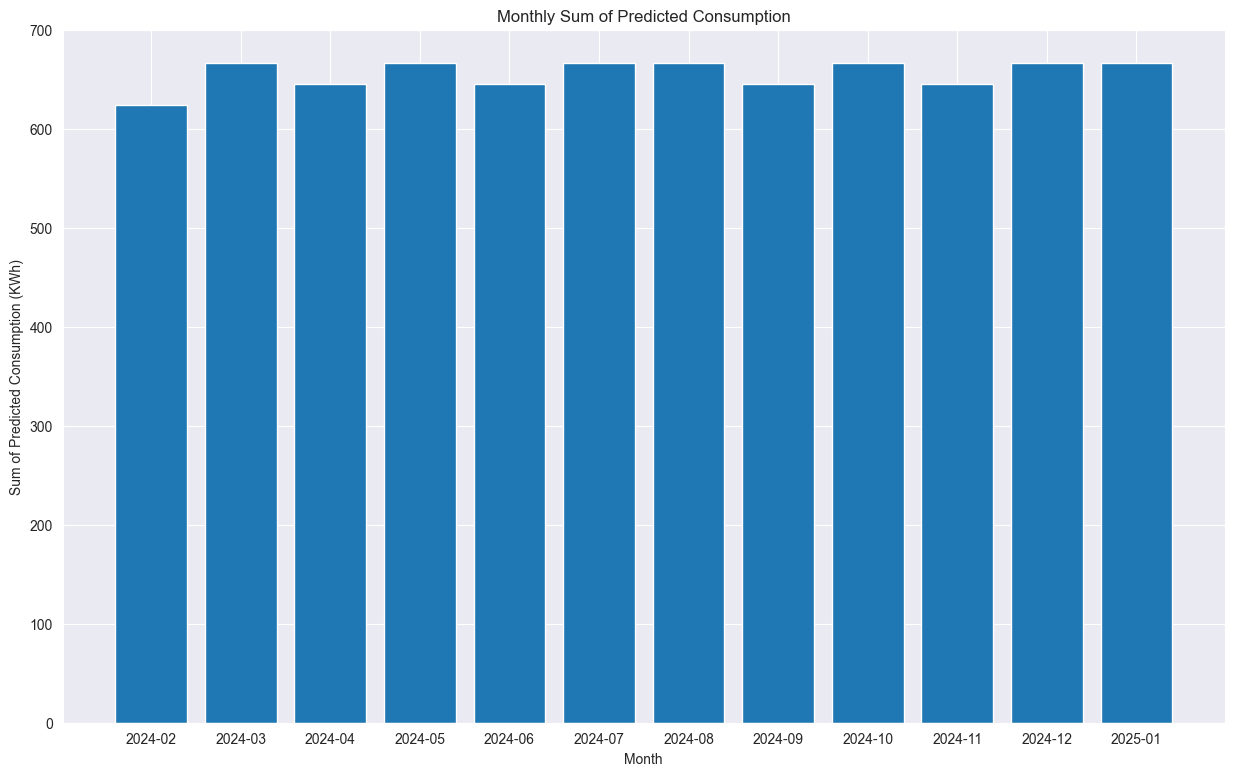

In [305]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 9))
# Plot the monthly sum forecast
plt.bar(monthly_sum_forecast.index.astype(str), monthly_sum_forecast)
plt.xlabel('Month')
plt.ylabel('Sum of Predicted Consumption (KWh)')
plt.title('Monthly Sum of Predicted Consumption')
plt.show()

### Charge Duration

In [307]:
# Extract relevant columns and set 'Plugged in at' as the index
charge_duration_data_train = train[['Plugged in at', 'Charging Duration']]
charge_duration_data_train.set_index('Plugged in at', inplace=True)

#ARIMAmodel = ARIMA(y_train, order=(1,1,1))
ARIMAmodel = ARIMA(charge_duration_data_train, order=(5,1,2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.forecast(len(test))
#res = pd.DataFrame(y_pred, index=X_test.index)

pred_df = pd.DataFrame(y_pred)
pred_df = pred_df.set_index(test.index)

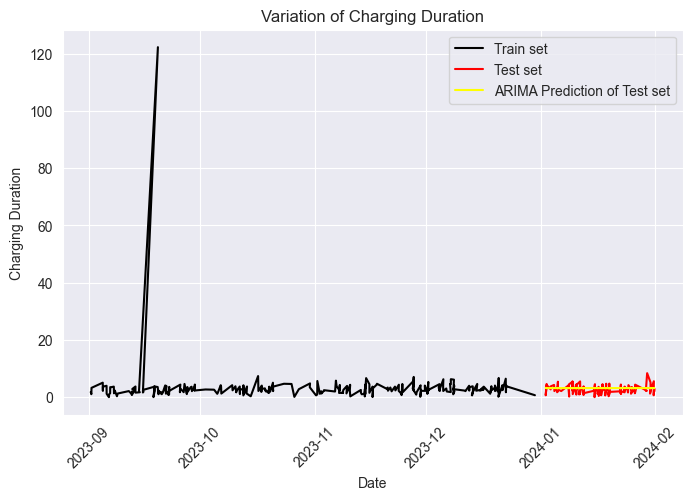

In [308]:
plt.figure(figsize=(8, 5))
plt.plot(train.index, train['Charging Duration'], color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(test.index, test['Charging Duration'], color='red', label='Test set')
plt.plot(pred_df, color='Yellow', label='ARIMA Prediction of Test set')
plt.xlabel('Date')
plt.ylabel('Charging Duration')
plt.title('Variation of Charging Duration')
plt.legend()
plt.show()

In [309]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['Charging Duration'], y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse} hours')

Mean Squared Error (MSE): 2.410867783919559
Root Mean Squared Error (RMSE): 1.5526969388517384 hours


In [310]:
print(f"The actual january charging duration is {test['Charging Duration'].sum()} hours and the predicted january charging duration is {y_pred.sum()} hours")

The actual january charging duration is 295.8075000000001 hours and the predicted january charging duration is 348.1442197827993 hours


### Predict Charge Duration for the next 12 months

In [311]:
# Forecast future values for each month from Feb to Dec 2024
forecast_steps_per_month = [29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31]  # Days in each month
forecast_values = []

for steps in forecast_steps_per_month:
    forecast_month = ARIMAmodel.get_forecast(steps=steps)
    forecast_values.extend(forecast_month.predicted_mean.tolist())

# Create a DataFrame with timestamp and forecasted values
forecast_dates = pd.date_range(start='2024-02-01', periods=len(forecast_values), freq='D')
forecast_df = pd.DataFrame({'Plugged in at': forecast_dates, 'Predicted Charging Duration': forecast_values})

# Print the forecasted values
print(forecast_df)

    Plugged in at  Predicted Charging Duration
0      2024-02-01                     3.180932
1      2024-02-02                     3.256978
2      2024-02-03                     3.195317
3      2024-02-04                     3.187135
4      2024-02-05                     3.180571
..            ...                          ...
361    2025-01-27                     3.189548
362    2025-01-28                     3.197483
363    2025-01-29                     3.189951
364    2025-01-30                     3.197100
365    2025-01-31                     3.190315

[366 rows x 2 columns]


In [312]:
# Group the forecasted DataFrame by month and sum the values
forecast_df['Month'] = forecast_df['Plugged in at'].dt.to_period('M')
monthly_sum_forecast = forecast_df.groupby('Month')['Predicted Charging Duration'].sum()

# Print the monthly sum forecast
print(monthly_sum_forecast)

Month
2024-02    92.652937
2024-03    99.040352
2024-04    95.850038
2024-05    99.040352
2024-06    95.850038
2024-07    99.040352
2024-08    99.040352
2024-09    95.850038
2024-10    99.040352
2024-11    95.850038
2024-12    99.040352
2025-01    99.040352
Freq: M, Name: Predicted Charging Duration, dtype: float64


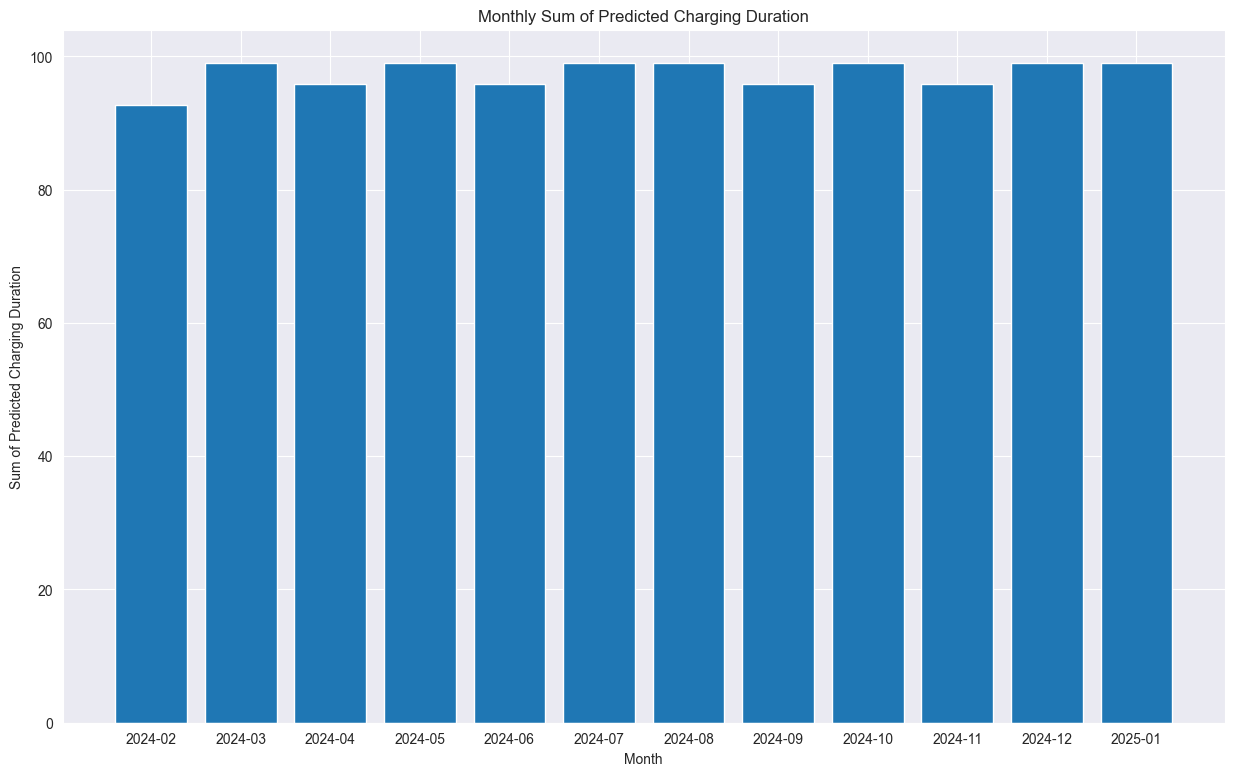

In [313]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 9))
# Plot the monthly sum forecast
plt.bar(monthly_sum_forecast.index.astype(str), monthly_sum_forecast)
plt.xlabel('Month')
plt.ylabel('Sum of Predicted Charging Duration')
plt.title('Monthly Sum of Predicted Charging Duration')
plt.show()

## Without outliers

In [391]:
employee_data_concat_copy = employee_data_concat.copy()

In [392]:
employee_data_concat_copy.set_index('Unplugged at', inplace=True)

In [393]:
concat_train = employee_data_concat_copy[employee_data_concat_copy.index <= pd.to_datetime("2023-12-31 23:59:59", format='%Y-%m-%d %H:%M:%S')]
concat_test = employee_data_concat_copy[employee_data_concat_copy.index >= pd.to_datetime("2024-01-01 00:00:00", format='%Y-%m-%d %H:%M:%S')]

### Consumption

In [411]:
# Extract relevant columns and set 'Plugged in at' as the index
consumption_data_concat_train = concat_train[['Plugged in at', 'Consumption(kWh)']]
consumption_data_concat_train.set_index('Plugged in at', inplace=True)

# Fit the model to the data
#ARIMAmodel = ARIMA(y_train, order=(1,1,1))
ARIMAmodel = ARIMA(consumption_data_concat_train, order=(5,1,2))
ARIMAmodel = ARIMAmodel.fit()

# Predict the test data
#y_pred = ARIMAmodel.forecast(len(concat_test))
#res = pd.DataFrame(y_pred, index=X_test.index)

# Convert test predictions to dataframe
pred_df_concat = pd.DataFrame(ARIMAmodel.forecast(len(concat_test)))
pred_df_concat = pred_df_concat.set_index(concat_test.index)

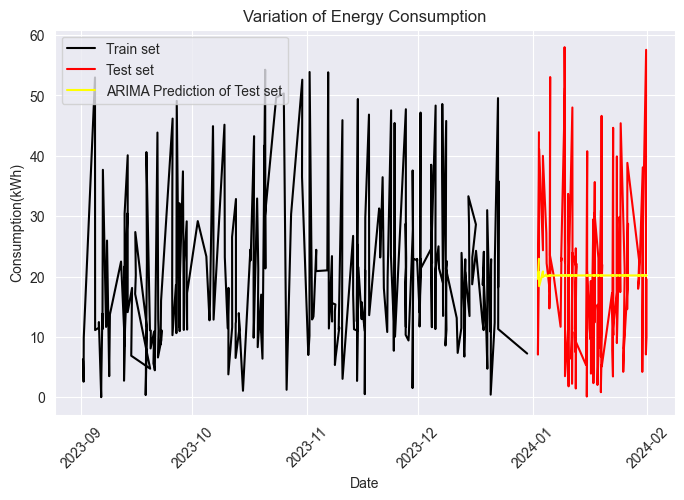

In [413]:
plt.figure(figsize=(8, 5))
plt.plot(concat_train.index, concat_train['Consumption(kWh)'], color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(concat_test.index, concat_test['Consumption(kWh)'], color='red', label='Test set')
plt.plot(pred_df_concat, color='Yellow', label='ARIMA Prediction of Test set')
plt.xlabel('Date')
plt.ylabel('Consumption(kWh)')
plt.title('Variation of Energy Consumption')
plt.legend()
plt.show()

In [414]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(concat_test['Consumption(kWh)'], y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 182.01324784227856
Root Mean Squared Error (RMSE): 13.491228551999205


In [415]:
print(f"The actual january consumption is {concat_test['Consumption(kWh)'].sum()} kWh and the predicted january consumption is {pred_df_concat['predicted_mean'].sum()} kWh")

The actual january consumption is 2137.6438073394497 kWh and the predicted january consumption is 2200.8573640532995 kWh


### Predict Consumption for the next 12 months

In [416]:
# Forecast future values for each month from Feb to Dec 2024
forecast_steps_per_month = [29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31]  # Days in each month
forecast_values = []

for steps in forecast_steps_per_month:
    forecast_month = ARIMAmodel.get_forecast(steps=steps)
    forecast_values.extend(forecast_month.predicted_mean.tolist())

# Create a DataFrame with timestamp and forecasted values
forecast_dates = pd.date_range(start='2024-02-01', periods=len(forecast_values), freq='D')
forecast_df = pd.DataFrame({'Plugged in at': forecast_dates, 'Predicted Consumption(KWh)': forecast_values})

# Print the forecasted values
print(forecast_df)

    Plugged in at  Predicted Consumption(KWh)
0      2024-02-01                   22.935030
1      2024-02-02                   19.606640
2      2024-02-03                   20.784573
3      2024-02-04                   18.397188
4      2024-02-05                   20.837745
..            ...                         ...
361    2025-01-27                   20.178288
362    2025-01-28                   20.178224
363    2025-01-29                   20.178272
364    2025-01-30                   20.178238
365    2025-01-31                   20.178261

[366 rows x 2 columns]


In [417]:
# Group the forecasted DataFrame by month and sum the values
forecast_df['Month'] = forecast_df['Plugged in at'].dt.to_period('M')
monthly_sum_forecast = forecast_df.groupby('Month')['Predicted Consumption(KWh)'].sum()

# Print the monthly sum forecast
print(monthly_sum_forecast)

Month
2024-02    586.597208
2024-03    626.953707
2024-04    606.775446
2024-05    626.953707
2024-06    606.775446
2024-07    626.953707
2024-08    626.953707
2024-09    606.775446
2024-10    626.953707
2024-11    606.775446
2024-12    626.953707
2025-01    626.953707
Freq: M, Name: Predicted Consumption(KWh), dtype: float64


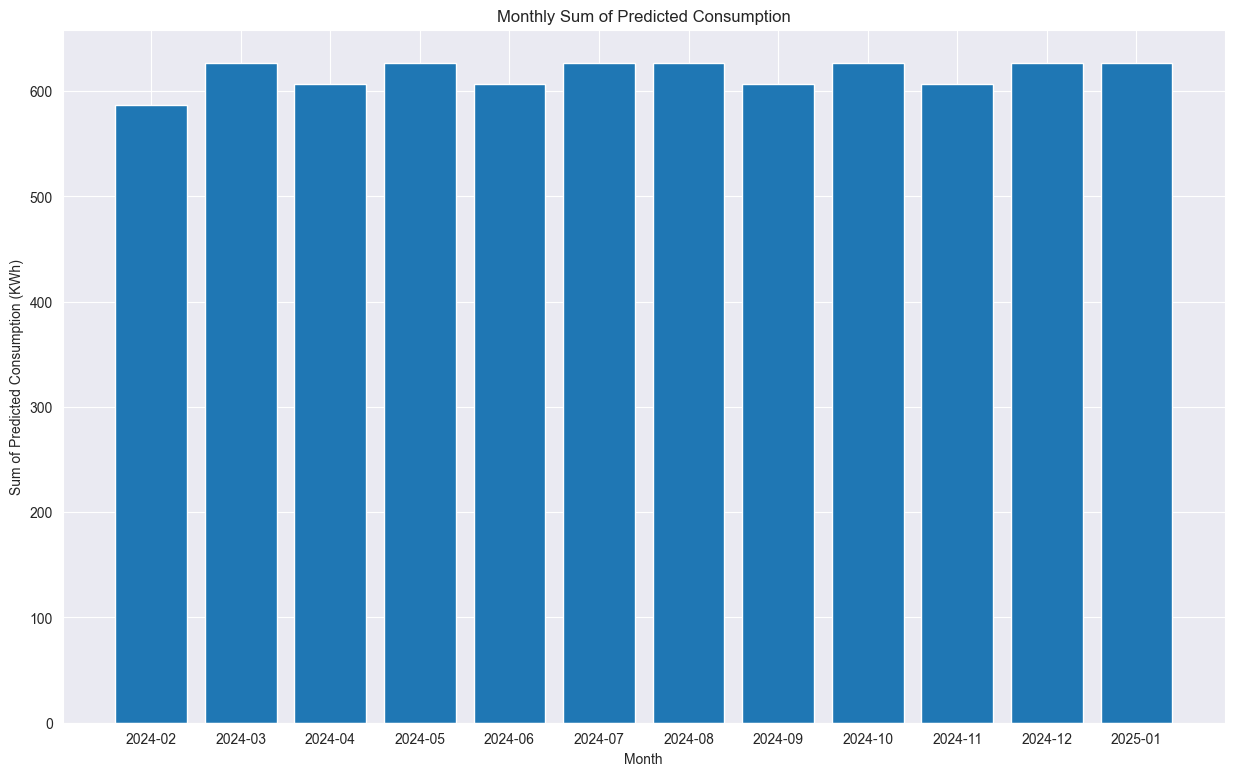

In [418]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 9))
# Plot the monthly sum forecast
plt.bar(monthly_sum_forecast.index.astype(str), monthly_sum_forecast)
plt.xlabel('Month')
plt.ylabel('Sum of Predicted Consumption (KWh)')
plt.title('Monthly Sum of Predicted Consumption')
plt.show()

### Charge Duration

In [420]:
# Extract relevant columns and set 'Plugged in at' as the index
charge_duration_data_concat_train = concat_train[['Plugged in at', 'Charging Duration']]
charge_duration_data_concat_train.set_index('Plugged in at', inplace=True)

#ARIMAmodel = ARIMA(y_train, order=(1,1,1))
ARIMAmodel = ARIMA(charge_duration_data_concat_train, order=(5,1,2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.forecast(len(concat_test))
#res = pd.DataFrame(y_pred, index=X_test.index)

pred_df = pd.DataFrame(y_pred)
pred_df = pred_df.set_index(concat_test.index)

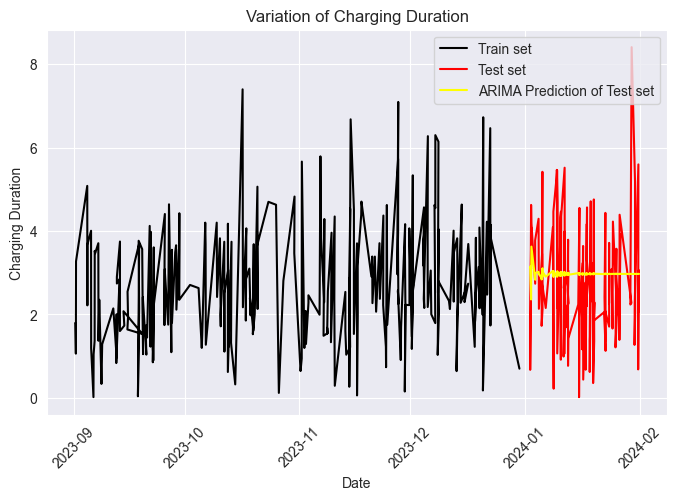

In [421]:
plt.figure(figsize=(8, 5))
plt.plot(concat_train.index, concat_train['Charging Duration'], color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(concat_test.index, concat_test['Charging Duration'], color='red', label='Test set')
plt.plot(pred_df, color='Yellow', label='ARIMA Prediction of Test set')
plt.xlabel('Date')
plt.ylabel('Charging Duration')
plt.title('Variation of Charging Duration')
plt.legend()
plt.show()

In [422]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(concat_test['Charging Duration'], y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse} hours')

Mean Squared Error (MSE): 2.2567486483339043
Root Mean Squared Error (RMSE): 1.5022478651453974 hours


In [423]:
print(f"The actual january charging duration is {concat_test['Charging Duration'].sum()} hours and the predicted january charging duration is {y_pred.sum()} hours")

The actual january charging duration is 295.8075000000001 hours and the predicted january charging duration is 323.8703975630544 hours


### Predict Charge Duration for the next 12 months

In [424]:
# Forecast future values for each month from Feb to Dec 2024
forecast_steps_per_month = [29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31]  # Days in each month
forecast_values = []

for steps in forecast_steps_per_month:
    forecast_month = ARIMAmodel.get_forecast(steps=steps)
    forecast_values.extend(forecast_month.predicted_mean.tolist())

# Create a DataFrame with timestamp and forecasted values
forecast_dates = pd.date_range(start='2024-02-01', periods=len(forecast_values), freq='D')
forecast_df = pd.DataFrame({'Plugged in at': forecast_dates, 'Predicted Charging Duration': forecast_values})

# Print the forecasted values
print(forecast_df)

    Plugged in at  Predicted Charging Duration
0      2024-02-01                     3.098393
1      2024-02-02                     3.147957
2      2024-02-03                     2.357338
3      2024-02-04                     3.624738
4      2024-02-05                     2.829059
..            ...                          ...
361    2025-01-27                     2.924953
362    2025-01-28                     3.011348
363    2025-01-29                     2.928832
364    2025-01-30                     3.007835
365    2025-01-31                     2.932124

[366 rows x 2 columns]


In [425]:
# Group the forecasted DataFrame by month and sum the values
forecast_df['Month'] = forecast_df['Plugged in at'].dt.to_period('M')
monthly_sum_forecast = forecast_df.groupby('Month')['Predicted Charging Duration'].sum()

# Print the monthly sum forecast
print(monthly_sum_forecast)

Month
2024-02    86.317361
2024-03    92.257320
2024-04    89.325196
2024-05    92.257320
2024-06    89.325196
2024-07    92.257320
2024-08    92.257320
2024-09    89.325196
2024-10    92.257320
2024-11    89.325196
2024-12    92.257320
2025-01    92.257320
Freq: M, Name: Predicted Charging Duration, dtype: float64


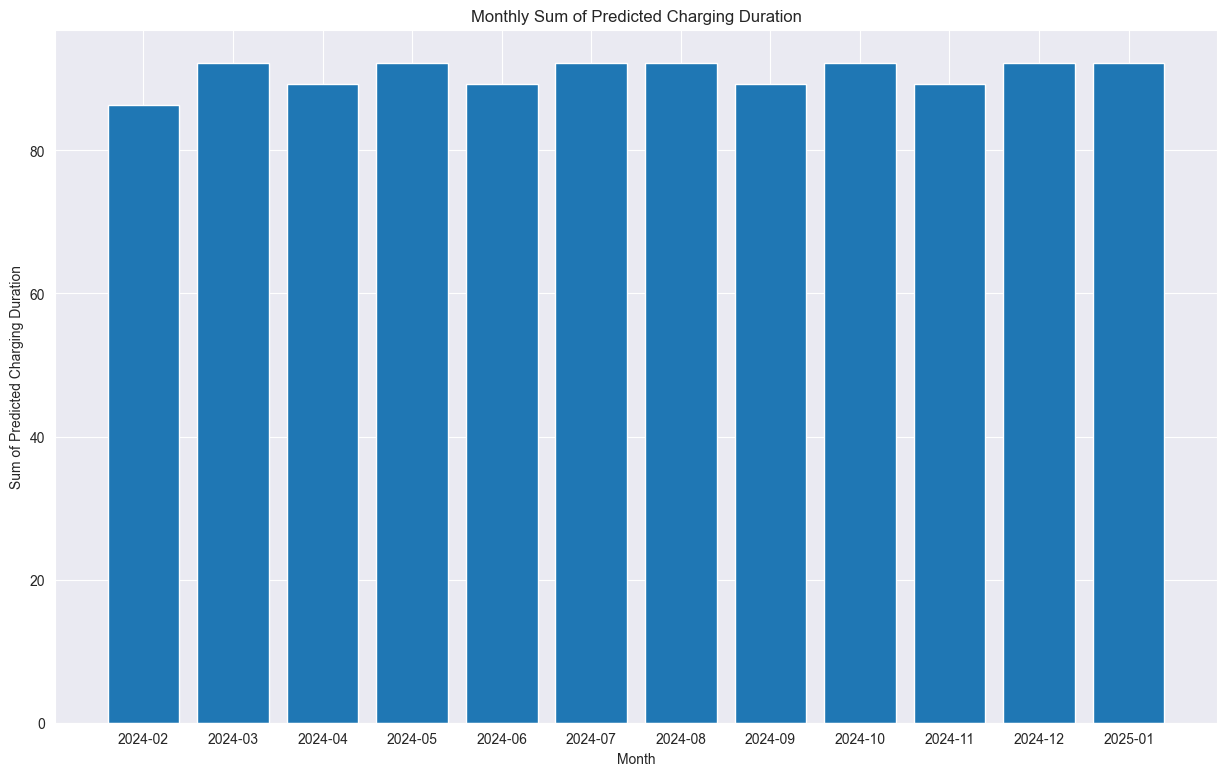

In [426]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 9))
# Plot the monthly sum forecast
plt.bar(monthly_sum_forecast.index.astype(str), monthly_sum_forecast)
plt.xlabel('Month')
plt.ylabel('Sum of Predicted Charging Duration')
plt.title('Monthly Sum of Predicted Charging Duration')
plt.show()

## Initial modeling

In [67]:

# Set 'Unplugged at' as the index
df.set_index('Unplugged at', inplace=True)

In [68]:
df

User Group User  \
Unplugged at                                                           
2023-09-01 10:24:40.874  Mitarbeiter*in Firmenfahrzeuge MIETHKE    G   
2023-09-01 11:23:58.970  Mitarbeiter*in Firmenfahrzeuge MIETHKE    F   
2023-09-01 14:33:57.371  Mitarbeiter*in Firmenfahrzeuge MIETHKE    F   
2023-09-01 15:37:25.712  Mitarbeiter*in Firmenfahrzeuge MIETHKE    G   
2023-09-04 16:32:27.521  Mitarbeiter*in Firmenfahrzeuge MIETHKE    C   
...                                                         ...  ...   
2024-01-30 15:38:28.913  Mitarbeiter*in Firmenfahrzeuge MIETHKE    C   
2024-01-31 15:21:21.154  Mitarbeiter*in Firmenfahrzeuge MIETHKE    D   
2024-01-31 13:55:30.841  Mitarbeiter*in Firmenfahrzeuge MIETHKE    C   
2024-01-31 17:56:35.663  Mitarbeiter*in Firmenfahrzeuge MIETHKE    F   
2024-01-31 18:23:21.916  Mitarbeiter*in Firmenfahrzeuge MIETHKE    H   

                                  Plugged in at Charging Duration  \
Unplugged at                                                        
2023-09-01 10:24:40.874 2023-09-01 08:36:41.452        1h 47m 27s   
2023-09-01 11:23:58.970 2023-09-01 09:36:40.639        1h 46m 52s   
2023-09-01 14:33:57.371 2023-09-01 11:41:08.208        1h 03m 29s   
2023-09-01 15:37:25.712 2023-09-01 11:58:01.090        3h 16m 14s   
2023-09-04 16:32:27.521 2023-09-04 08:23:32.618        5h 04m 48s   
...                                         ...               ...   
2024-01-30 15:38:28.913 2024-01-30 13:22:05.439        2h 15m 37s   
2024-01-31 15:21:21.154 2024-01-31 09:44:08.440        5h 35m 41s   
2024-01-31 13:55:30.841 2024-01-31 13:13:53.423        0h 40m 49s   
2024-01-31 17:56:35.663 2024-01-31 14:52:41.343        3h 03m 34s   
2024-01-31 18:23:21.916 2024-01-31 16:11:56.037        2h 04m 13s   

                        Blocking time                      Location  \
Unplugged at                                                          
2023-09-01 10:24:40.874    1h 47m 59s                       Ulanweg   
2023-09-01 11:23:58.970    1h 47m 18s  Fritz-von-der-Lancken-Straße   
2023-09-01 14:33:57.371    2h 52m 49s  Fritz-von-der-Lancken-Straße   
2023-09-01 15:37:25.712    3h 39m 25s                       Ulanweg   
2023-09-04 16:32:27.521    8h 08m 55s                       Ulanweg   
...                               ...                           ...   
2024-01-30 15:38:28.913    2h 16m 23s  Fritz-von-der-Lancken-Straße   
2024-01-31 15:21:21.154    5h 37m 13s  Fritz-von-der-Lancken-Straße   
2024-01-31 13:55:30.841    0h 41m 37s  Fritz-von-der-Lancken-Straße   
2024-01-31 17:56:35.663    3h 03m 54s                       Ulanweg   
2024-01-31 18:23:21.916    2h 11m 26s                       Ulanweg   

                        Charging Station Connector       EVSE-ID  \
Unplugged at                                                       
2023-09-01 10:24:40.874   KEBA_MIETHKE_1    Point3  DE*ONE*ET6BM   
2023-09-01 11:23:58.970   KEBA_MIETHKE_2    Point1  DE*ONE*ENHW4   
2023-09-01 14:33:57.371   KEBA_MIETHKE_2    Point1  DE*ONE*ENHW4   
2023-09-01 15:37:25.712   KEBA_MIETHKE_1    Point3  DE*ONE*ET6BM   
2023-09-04 16:32:27.521   KEBA_MIETHKE_1    Point2  DE*ONE*EKZC8   
...                                  ...       ...           ...   
2024-01-30 15:38:28.913   KEBA_MIETHKE_2    Point1  DE*ONE*ENHW4   
2024-01-31 15:21:21.154   KEBA_MIETHKE_2    Point1  DE*ONE*ENHW4   
2024-01-31 13:55:30.841   KEBA_MIETHKE_2    Point2  DE*ONE*EJ5HL   
2024-01-31 17:56:35.663     ABL_10332049    Point2  DE*ONE*EE94A   
2024-01-31 18:23:21.916   KEBA_MIETHKE_1    Point4  DE*ONE*EC6M1   

                         Consumption(KWh)  Year_un Month_un Day_of_week_un  \
Unplugged at                                                                 
2023-09-01 10:24:40.874             6.280     2023      Sep         Friday   
2023-09-01 11:23:58.970             5.903     2023      Sep         Friday   
2023-09-01 14:33:57.371             2.573     2023      Sep         Friday   
2023-09-01 15:37:25

In [96]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Extract relevant columns and set 'Plugged in at' as the index
consumption_data = df[['Plugged in at', 'Consumption(KWh)']]
consumption_data.set_index('Plugged in at', inplace=True)

# Fit ARIMA model
order = (5, 1, 2)  # You may need to tune the order parameters
model = ARIMA(consumption_data, order=order)
result = model.fit()

# Forecast future values for each month from Feb to Dec 2024
forecast_steps_per_month = [28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 30]  # Days in each month
forecast_values = []

for steps in forecast_steps_per_month:
    forecast_month = result.get_forecast(steps=steps)
    forecast_values.extend(forecast_month.predicted_mean.tolist())

# Create a DataFrame with timestamp and forecasted values
forecast_dates = pd.date_range(start='2024-02-01', periods=len(forecast_values), freq='D')
forecast_df = pd.DataFrame({'Plugged in at': forecast_dates, 'Predicted Consumption(KWh)': forecast_values})

# Print the forecasted values
print(forecast_df)



C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


    Plugged in at  Predicted Consumption(KWh)
0      2024-02-01                   21.667089
1      2024-02-02                   22.445440
2      2024-02-03                   21.079959
3      2024-02-04                   21.914463
4      2024-02-05                   21.355734
..            ...                         ...
359    2025-01-25                   21.603261
360    2025-01-26                   21.603196
361    2025-01-27                   21.603239
362    2025-01-28                   21.603211
363    2025-01-29                   21.603229

[364 rows x 2 columns]


C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be gi

In [97]:
# Group the forecasted DataFrame by month and sum the values
forecast_df['Month'] = forecast_df['Plugged in at'].dt.to_period('M')
monthly_sum_forecast = forecast_df.groupby('Month')['Predicted Consumption(KWh)'].sum()

# Print the monthly sum forecast
print(monthly_sum_forecast)


Month
2024-02    627.109420
2024-03    670.251988
2024-04    648.648771
2024-05    670.251988
2024-06    648.648771
2024-07    670.251988
2024-08    670.251988
2024-09    648.648771
2024-10    670.251988
2024-11    648.648771
2024-12    670.251988
2025-01    626.981682
Freq: M, Name: Predicted Consumption(KWh), dtype: float64


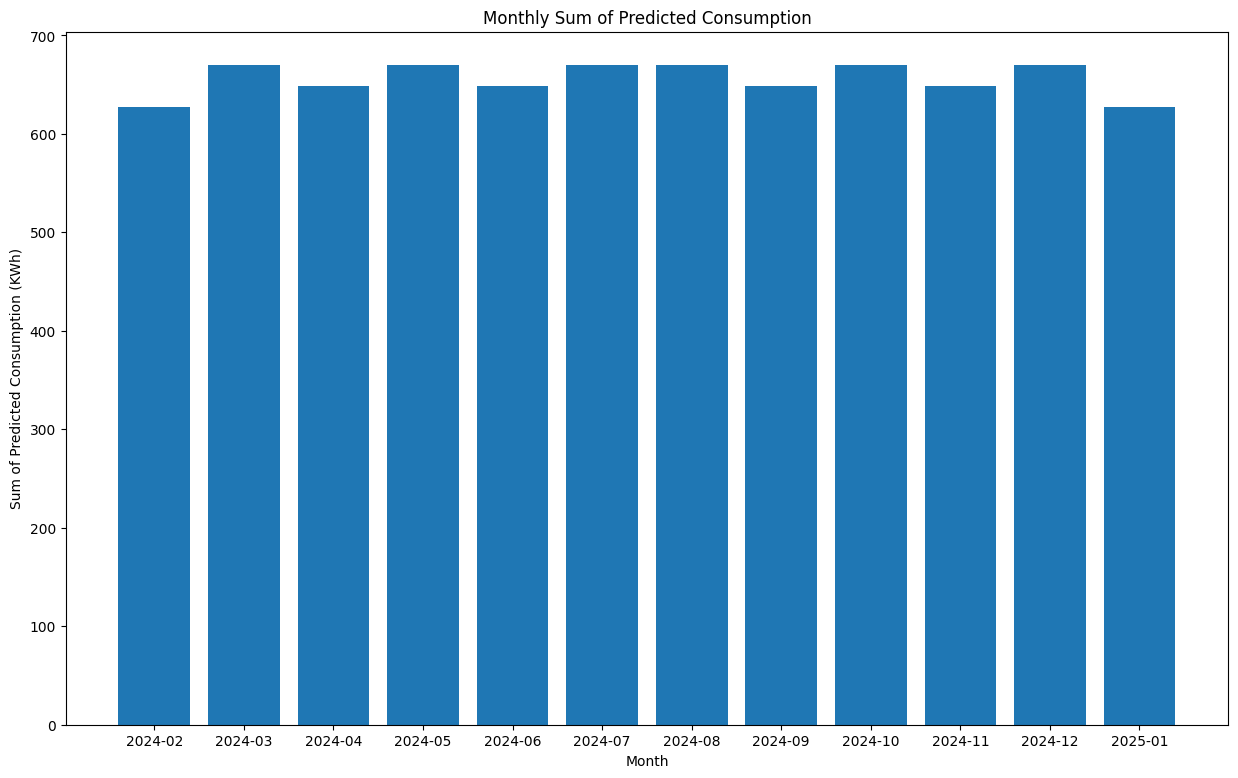

In [108]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 9))
# Plot the monthly sum forecast
plt.bar(monthly_sum_forecast.index.astype(str), monthly_sum_forecast)
plt.xlabel('Month')
plt.ylabel('Sum of Predicted Consumption (KWh)')
plt.title('Monthly Sum of Predicted Consumption')
plt.show()


In [73]:
from sklearn.metrics import mean_squared_error
import numpy as np

actual_data = df

# Extract the actual consumption values for the same forecasted months
actual_values = actual_data['Consumption(KWh)'].values

# Truncate or pad 'forecast_values' to match the length of 'actual_values'
forecast_values_aligned = forecast_values[:len(actual_values)]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, forecast_values_aligned)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Squared Error (MSE): 212.65939410168014
Root Mean Squared Error (RMSE): 14.582845884863493


In [112]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

consumption_data = df[['Plugged in at', 'Charging Duration (Minutes)']]
consumption_data.set_index('Plugged in at', inplace=True)

# Fit ARIMA model
order = (5, 1, 2)  # You may need to tune the order parameters
model = ARIMA(consumption_data, order=order)
result = model.fit()

# Forecast future values for each month from Feb to Dec 2024
forecast_steps_per_month = [28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 30]  # Days in each month
forecast_values = []

for steps in forecast_steps_per_month:
    forecast_month = result.get_forecast(steps=steps)
    forecast_values.extend(forecast_month.predicted_mean.tolist())

# Create a DataFrame with timestamp and forecasted values
forecast_dates = pd.date_range(start='2024-02-01', periods=len(forecast_values), freq='D')
forecast_df = pd.DataFrame({'Plugged in at': forecast_dates, 'Charging Duration (Minutes)': forecast_values})

# Print the forecasted values
print(forecast_df)


C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters foun

    Plugged in at  Charging Duration (Minutes)
0      2024-02-01                   185.891756
1      2024-02-02                   181.756402
2      2024-02-03                   183.609931
3      2024-02-04                   181.435383
4      2024-02-05                   183.443175
..            ...                          ...
359    2025-01-25                   182.337451
360    2025-01-26                   182.970335
361    2025-01-27                   182.362790
362    2025-01-28                   182.946010
363    2025-01-29                   182.386140

[364 rows x 2 columns]


C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\Documents\Python Scripts\envs\Ronke\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be gi

In [149]:
# Group the forecasted DataFrame by month and sum the values
forecast_df['Month'] = forecast_df['Plugged in at'].dt.to_period('M')
monthly_sum_forecast = forecast_df.groupby('Month')['Charging Duration (Minutes)'].sum()

# Print the monthly sum forecast
print(monthly_sum_forecast)


Month
2024-02    5302.703118
2024-03    5665.067107
2024-04    5482.143512
2024-05    5665.067107
2024-06    5482.143512
2024-07    5665.067107
2024-08    5665.067107
2024-09    5482.143512
2024-10    5665.067107
2024-11    5482.143512
2024-12    5665.067107
2025-01    5296.251756
Freq: M, Name: Charging Duration (Minutes), dtype: float64


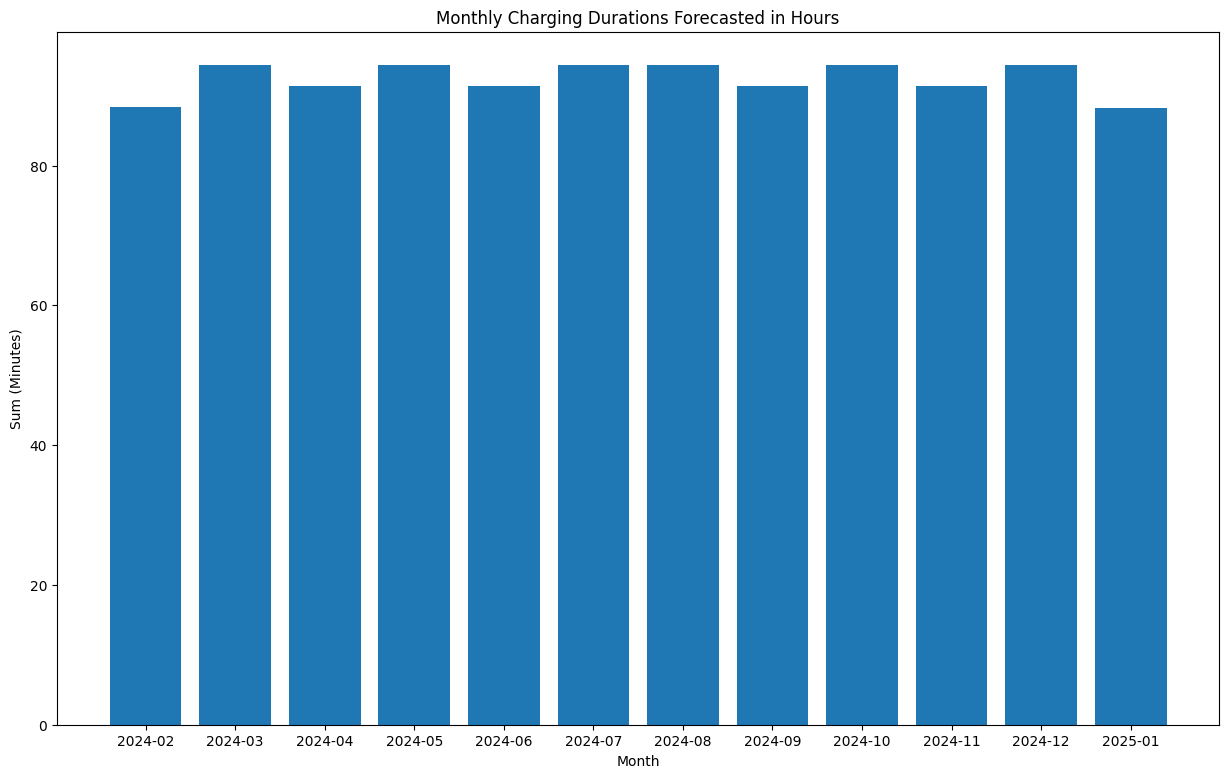

In [104]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 9))
# Plot the monthly sum forecast
plt.bar(monthly_sum_forecast_hours.index.astype(str), monthly_sum_forecast_hours)
plt.xlabel('Month')
plt.ylabel('Sum (Minutes)')
plt.title('Monthly Charging Durations Forecasted in Hours')
plt.show()


In [118]:
# Convert charging duration from minutes to hours
monthly_sum_forecast_hours = monthly_sum_forecast / 60.0

# Print the monthly sum forecast in hours
print(f'monthly_sum_forecast_hours {monthly_sum_forecast_hours}')


monthly_sum_forecast_hours Month
2024-02    88.378385
2024-03    94.417785
2024-04    91.369059
2024-05    94.417785
2024-06    91.369059
2024-07    94.417785
2024-08    94.417785
2024-09    91.369059
2024-10    94.417785
2024-11    91.369059
2024-12    94.417785
2025-01    88.270863
Freq: M, Name: Charging Duration (Minutes), dtype: float64


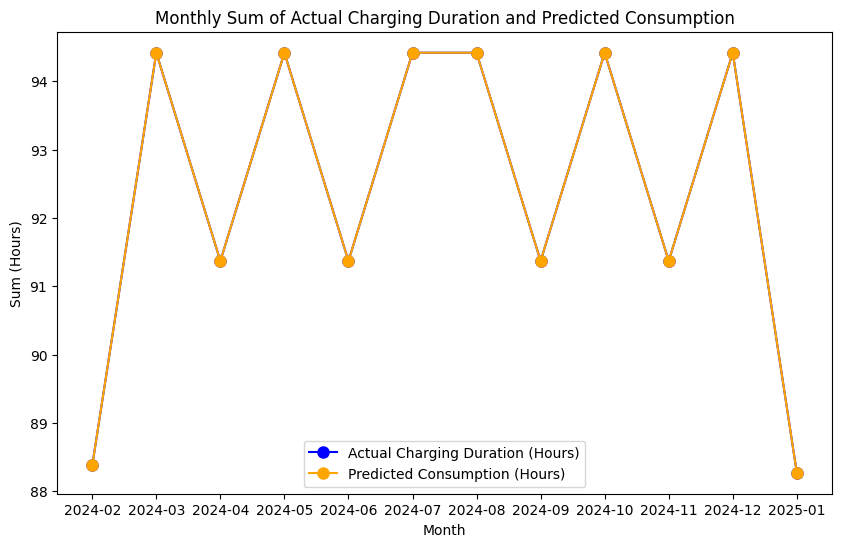

In [84]:
import matplotlib.pyplot as plt

# Plot the actual charging duration and predicted consumption in hours with different colors and markers
plt.figure(figsize=(10, 6))  # Adjust the values (width, height) as needed
plt.plot(monthly_sum_forecast_hours.index.astype(str), monthly_sum_forecast_hours, label='Actual Charging Duration (Hours)', color='blue', marker='o', markersize=8)
plt.plot(monthly_sum_forecast_hours.index.astype(str), monthly_sum_forecast_hours, label='Predicted Consumption (Hours)', color='orange', marker='o', markersize=8)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Sum (Hours)')
plt.title('Monthly Sum of Actual Charging Duration and Predicted Consumption')
plt.legend()
plt.show()


In [85]:
from sklearn.metrics import mean_squared_error
import numpy as np

actual_data = df

# Extract the actual consumption values for the same forecasted months
actual_values = actual_data['Charging Duration (Minutes)'].values

# Truncate or pad 'forecast_values' to match the length of 'actual_values'
forecast_values_aligned = forecast_values[:len(actual_values)]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, forecast_values_aligned)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Squared Error (MSE): 150107.04858340684
Root Mean Squared Error (RMSE): 387.436509099758
